# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 20 #0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 20


Using matplotlib, I look at the noisy time series I just simulated:

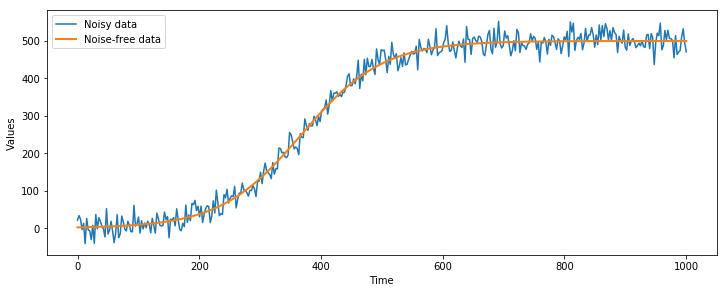

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

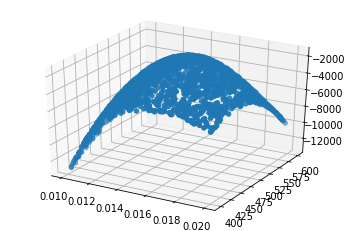

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 192)               24768     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               49408     
_________________________________________________________________
dense_5 (Dense)              (None, 320)               82240     
_________________________________________________________________
dense_6 (Dense)              (None, 384)               123264    
_________________________________________________________________
dense_7 (Dense)              (None, 384)               147840    
__________

In [15]:
emu([0.015, 500])

array([[-1804.8629]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1800.572890779282

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


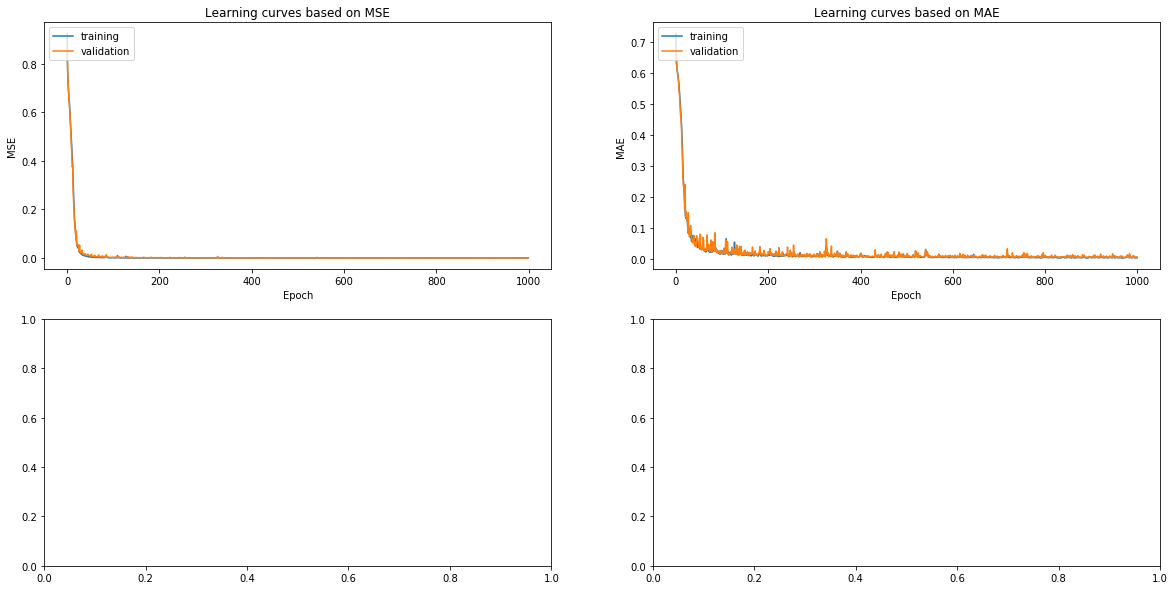

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

#ax3.plot(hist.history['rescaled_mse'])
#ax3.plot(hist.history['val_rescaled_mse'])
#ax3.set_ylabel('Rescaled MSE')
#ax3.set_xlabel('Epoch')
#ax3.legend(['training', 'validation'], loc='upper left')

#ax4.plot(hist.history['rescaled_mae'])
#ax4.plot(hist.history['val_rescaled_mae'])
#ax4.set_ylabel('Rescaled MAE')
#ax4.set_xlabel('Epoch')
#ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

In [18]:
val_mse = hist.history["val_loss"]
print("Minimum MSE during validation:", min(val_mse))
idx_mse = list(val_mse).index(min(val_mse))
print("Best epoch based on validation MSE:", idx_mse)
print("\n")


val_mae = hist.history["val_mean_absolute_error"]
print("Minimum MAE during validation:", min(val_mae))
idx_mae = list(val_mae).index(min(val_mae))
print("Best epoch based on validation MAE:", idx_mae)
print("\n")

print(val_mse[-1])
print(val_mae[-1])

Minimum MSE during validation: 0.00030170455613794426
Best epoch based on validation MSE: 982


Minimum MAE during validation: 0.005183906722813845
Best epoch based on validation MAE: 982


0.00032494794121400145
0.0071057947787145775


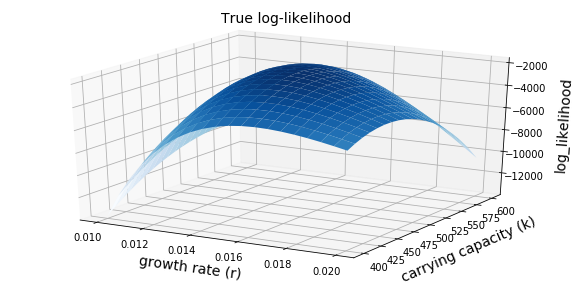

In [19]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

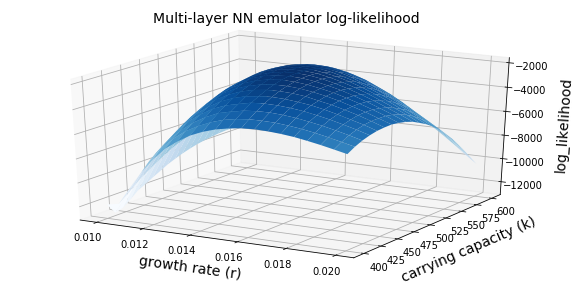

In [20]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [21]:
print(model_prediction.shape)
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

(20, 20)


0.0035369729037566266

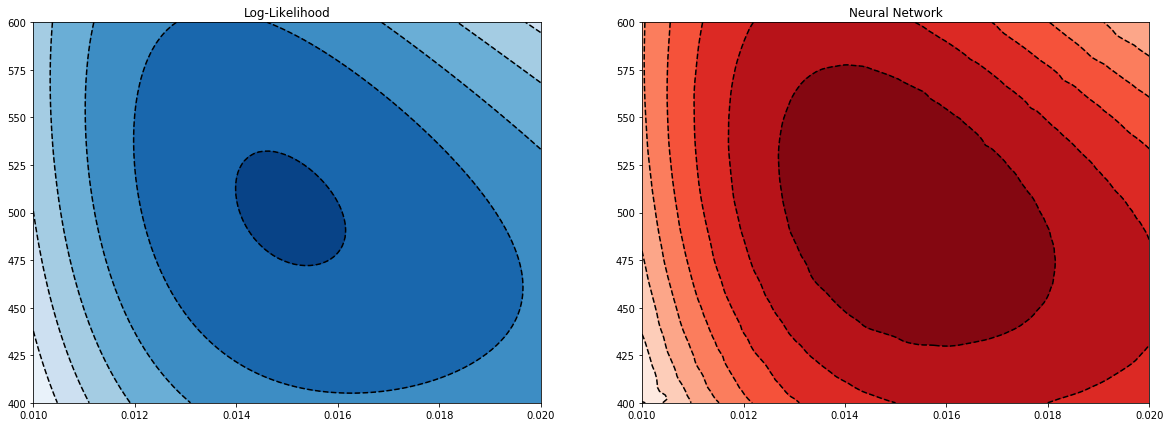

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

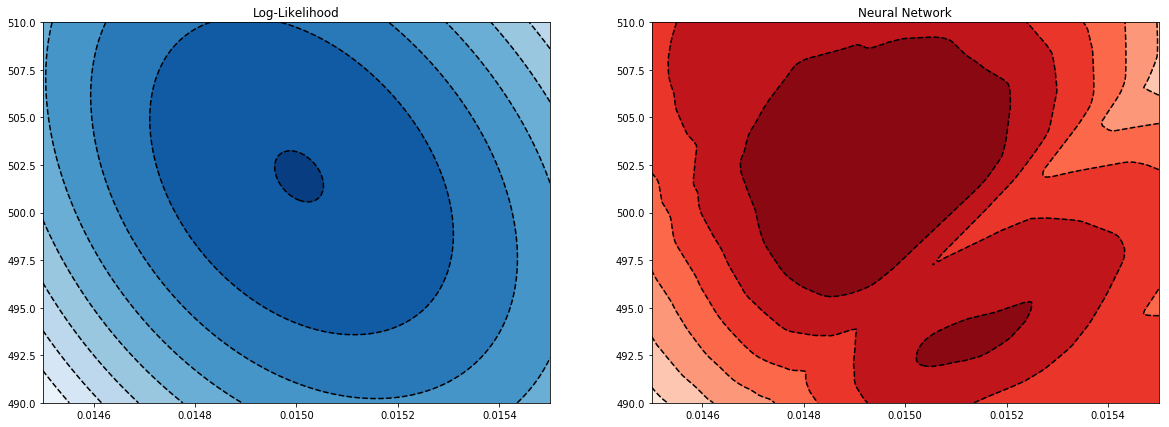

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [24]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [25]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
[1.43986583e-02 4.50433921e+02]
-2693.6014112725934
accepted


[3.32071468e-02 5.26880454e+02]
-inf


[2.01188082e-02 5.70958298e+02]
-inf


[3.43403032e-02 4.51864055e+02]
-inf


[-5.85637574e-03  5.24729051e+02]
-inf


[3.02102798e-02 5.79818287e+02]
-inf


[1.10376363e-02 4.52743959e+02]
-7755.505560502981


[3.02086434e-02 5.26259982e+02]
-inf


[1.02678291e-02 5.74277512e+02]
-8211.997152864247


[9.65273732e-03 4.51881590e+02]
-inf


[1.02685751e-02 5.26454641e+02]
-8505.13088811133


[2.16351181e-02 5.73000284e+02]
-inf


[9.74787528e-03 4.48298053e+02]
-inf


[1.77290997e-02 5.24392418e+02]
-3401.671288366115


[1.51886832e-02 5.76794735e+02]
-3309.1266865707557
accepted


[5.46442160e-03 4.47856357e+02]
-inf


[6.01525842e-03 5.25685203e+02]
-inf


[-5.49690075e-04  5.74222428e+02]
-inf


[1.01658384e-02 4.50283196e+02]
-10830.164525873643


[-6.56438576e-03  5.26134588e+02]
-inf


[3.92728048e-02 5.77804336e+02]
-inf


[1.70988148e-02 4.47200611e+02]
-2736.69095777

[2.75933770e-02 5.28962387e+02]
-inf


[1.13764604e-03 5.78975441e+02]
-inf


[-6.23641750e-03  4.52654288e+02]
-inf


[1.28509955e-02 5.28695087e+02]
-2815.9076514000044


[9.67799818e-03 5.74931170e+02]
-inf


[1.04094875e-02 4.49831040e+02]
-9920.50928622309


[-2.38738740e-03  5.25162336e+02]
-inf


[1.02790330e-02 5.74048226e+02]
-8174.715497555413


[1.68444981e-02 4.52242158e+02]
-2559.5302140416293


[-6.73278269e-03  5.27664358e+02]
-inf


[3.59020881e-02 5.81621056e+02]
-inf


[3.14817307e-02 4.48706996e+02]
-inf


[1.78460351e-03 5.23815178e+02]
-inf


[3.36199383e-02 5.76234097e+02]
-inf


[2.98907788e-03 4.49374697e+02]
-inf


[1.91418249e-02 5.28019907e+02]
-4856.869324505986


[1.93071304e-02 5.79410545e+02]
-7832.337836668154


[1.98133881e-02 4.52457151e+02]
-4129.370788633119


[3.06644790e-02 5.30039126e+02]
-inf


[5.60611216e-03 5.75501965e+02]
-inf


[4.93206521e-03 4.47401956e+02]
-inf


[1.30755301e-02 5.29695628e+02]
-2603.6925667297155


[1.50088359e-02 5.7619



[-2.36430822e-03  4.51251217e+02]
-inf


[3.15927082e-02 5.27323880e+02]
-inf


[2.36725020e-02 5.74992398e+02]
-inf


[6.19797145e-03 4.52372516e+02]
-inf


[2.10377571e-02 5.29560579e+02]
-inf


[2.59758144e-02 5.71186034e+02]
-inf


[2.12749803e-02 4.53906557e+02]
-inf


[2.1201925e-02 5.2396484e+02]
-inf


[1.38619608e-02 5.75473294e+02]
-2938.845601680936


[2.91390089e-03 4.52314558e+02]
-inf


[3.11649994e-02 5.24767527e+02]
-inf


[-7.60166302e-03  5.71941456e+02]
-inf


[1.96408337e-02 4.53374062e+02]
-4009.075791607508


[1.08929138e-02 5.26251522e+02]
-6493.473058042297


[2.91095469e-02 5.69370910e+02]
-inf


[3.92116422e-02 4.53846466e+02]
-inf


[2.57941600e-02 5.29156986e+02]
-inf


[1.59051968e-02 5.75795316e+02]
-3743.4861041528584


[2.48969309e-02 4.53065976e+02]
-inf


[6.74443708e-03 5.24427969e+02]
-inf


[2.79750249e-02 5.74244625e+02]
-inf


[3.41187901e-02 4.55604314e+02]
-inf


[1.49035886e-02 5.21787641e+02]
-1891.8841953707963
accepted


[6.13849494e-03 5.


[1.38195341e-02 5.70825930e+02]
-2816.5209402691817


[1.57600823e-02 4.56032199e+02]
-2283.4630900508755
accepted


[1.46166317e-02 5.20273096e+02]
-1878.7019068574446
accepted


[1.37137825e-02 5.69014368e+02]
-2789.851681313526
accepted


[1.59522815e-02 4.56439553e+02]
-2290.409008613786


[1.45862263e-02 5.20097137e+02]
-1879.6672364049366


[1.37896305e-02 5.69483510e+02]
-2786.7075520754715
accepted


[1.58498978e-02 4.56240938e+02]
-2284.896293752876


[1.46571339e-02 5.20897847e+02]
-1881.133209961624


[1.37000443e-02 5.68591859e+02]
-2782.6157509855157
accepted


[1.58162887e-02 4.56432402e+02]
-2278.624604482512
accepted


[1.47074972e-02 5.20123740e+02]
-1873.5027181880737
accepted


[1.37139944e-02 5.68349447e+02]
-2773.559214006481
accepted


[1.59695180e-02 4.57307111e+02]
-2275.6530745379087
accepted


[1.49406043e-02 5.20764086e+02]
-1884.9643367115375


[1.38525029e-02 5.69502763e+02]
-2777.478490329955


[1.61716226e-02 4.58376929e+02]
-2285.7176292777167


[1.4692



[1.47385288e-02 5.03714886e+02]
-1813.0969216360056


[1.34624088e-02 5.00937034e+02]
-2358.2371553881426


[1.53428040e-02 5.00194883e+02]
-1819.9318654800397


[1.46085513e-02 5.13621204e+02]
-1843.059236440635


[1.35872278e-02 5.35993626e+02]
-2287.545184436808


[1.46531803e-02 4.93763129e+02]
-1856.9964038437245


[1.50277250e-02 4.96645649e+02]
-1806.8283448989587


[1.3486657e-02 4.9675247e+02]
-2377.1788998127995


[1.47691696e-02 5.03532603e+02]
-1810.2757267520342
accepted


[1.50661469e-02 4.93128227e+02]
-1817.9517440732686


[1.36493618e-02 5.42218492e+02]
-2322.183290998577


[1.43447467e-02 5.30407498e+02]
-1995.1629362368974


[1.50735600e-02 5.06867199e+02]
-1809.2844127652581


[1.36718788e-02 5.26360362e+02]
-2179.4720617055677
accepted


[1.36291704e-02 5.44429310e+02]
-2358.259874619733


[1.49825861e-02 5.04424098e+02]
-1801.7156144594721
accepted


[1.32699743e-02 5.42678316e+02]
-2535.713885215559


[1.40682392e-02 5.09989825e+02]
-1968.8260799543568


[1.503

[1.50873511e-02 5.00708851e+02]
-1801.4790222375648


[1.50722551e-02 5.01584575e+02]
-1801.0962585925374
accepted


[1.47961371e-02 5.10758212e+02]
-1819.3271653169975


[1.49778306e-02 4.97445631e+02]
-1806.1202444264702


[1.50844918e-02 4.99880965e+02]
-1801.745881602557


[1.55186652e-02 4.84437796e+02]
-1883.0805623816998


[1.49887612e-02 5.05605017e+02]
-1803.5206393402502


[1.50504514e-02 5.03365891e+02]
-1801.5900979990213
accepted


[1.4783926e-02 4.9957381e+02]
-1814.2203248399053


[1.50159406e-02 5.04498008e+02]
-1802.1785367099285


[1.50008244e-02 5.07398614e+02]
-1807.8668863555554


[1.40983305e-02 5.16412105e+02]
-1962.902757014052


[1.51351303e-02 4.97729092e+02]
-1805.2576071640744


[1.50722199e-02 5.01310528e+02]
-1801.0635612434942
accepted


[1.54174057e-02 4.89703484e+02]
-1845.2086920050285


[1.50821512e-02 5.03785747e+02]
-1803.123684777647


[1.51997770e-02 4.98371166e+02]
-1807.3078328160498


[1.52752583e-02 4.94976310e+02]
-1817.059020351445


[1.4832

[1.50419504e-02 4.99493160e+02]
-1801.5806235564285


[1.50256101e-02 5.06651890e+02]
-1806.6339059796558


[1.50067030e-02 5.04104291e+02]
-1801.5455417806224
accepted


[1.50153533e-02 5.00881904e+02]
-1800.521731502423
accepted


[1.50304634e-02 5.01001861e+02]
-1800.5061332262317
accepted


[1.48647740e-02 5.05099634e+02]
-1804.516239759135


[1.50217760e-02 5.00492233e+02]
-1800.7300977111547
accepted


[1.50500062e-02 4.94598386e+02]
-1812.6272039168502


[1.50701471e-02 5.04916929e+02]
-1804.4690729110337


[1.49244907e-02 5.00446409e+02]
-1802.7299976728245
accepted


[1.51883722e-02 4.97540257e+02]
-1807.5812035324177


[1.49970908e-02 5.05489695e+02]
-1803.4326027349084


[1.49153150e-02 5.00087386e+02]
-1803.576739968409


[1.51257908e-02 4.96521305e+02]
-1807.207219922237


[1.51298888e-02 4.97624879e+02]
-1805.2686107716167


[1.49064667e-02 5.02015779e+02]
-1802.1807970004447
accepted


[1.50935124e-02 4.96843486e+02]
-1806.0643664505928


[1.50740452e-02 5.00399402e+02]


[1.49807900e-02 4.94089486e+02]
-1816.936319708483


[1.51061847e-02 5.01147016e+02]
-1802.050371836293
accepted


[1.49918159e-02 5.01879722e+02]
-1800.325997691745
accepted


[1.50474340e-02 4.95590811e+02]
-1809.4405765828144


[1.50820673e-02 5.00674213e+02]
-1801.3541513149569
accepted


[1.49853007e-02 5.04218352e+02]
-1801.4961981005492
accepted


[1.48014105e-02 4.98623337e+02]
-1814.8332485733738


[1.50287658e-02 5.01199057e+02]
-1800.4411131085074
accepted


[1.50691147e-02 5.03122262e+02]
-1801.8866891253313
accepted


[1.52202103e-02 4.99896869e+02]
-1808.07628547147


[1.50507862e-02 4.99564136e+02]
-1801.5457670146927


[1.49710819e-02 5.04054857e+02]
-1801.3195886299638
accepted


[1.50160472e-02 5.00085109e+02]
-1801.0520648358245
accepted


[1.50267331e-02 5.00027704e+02]
-1801.0688581998097
accepted


[1.49149409e-02 5.05897571e+02]
-1804.1001431580241


[1.48402598e-02 5.06407303e+02]
-1807.057386137268


[1.49658194e-02 5.02226531e+02]
-1800.5566385400255
accepted


accepted


[1.49355937e-02 5.03239047e+02]
-1801.2262857758706
accepted


[1.51436505e-02 5.03501507e+02]
-1805.8609534888708


[1.50620241e-02 5.00653466e+02]
-1800.960668398848
accepted


[1.50150957e-02 5.04959765e+02]
-1802.8530566986865


[1.49630291e-02 5.02965426e+02]
-1800.6973940500955
accepted


[1.50382060e-02 5.00610606e+02]
-1800.711447676957
accepted


[1.50266004e-02 5.02403949e+02]
-1800.502574319475
accepted


[1.49903466e-02 5.04389892e+02]
-1801.7193178948853


[1.51464447e-02 4.97472486e+02]
-1805.9905350361705


[1.48805183e-02 5.09115770e+02]
-1811.9236470038538


[1.49340759e-02 5.02518586e+02]
-1801.1654887402112
accepted


[1.49691965e-02 5.00048783e+02]
-1801.7623464573421


[1.51495404e-02 5.01608732e+02]
-1804.1777700378425
accepted


[1.48418413e-02 5.03611821e+02]
-1804.9575320025695


[1.49260474e-02 5.03725336e+02]
-1801.6356813357118


[1.51462244e-02 4.98851858e+02]
-1804.3440053107195
accepted


[1.49554270e-02 5.02746814e+02]
-1800.744613156308
accep

[1.49345566e-02 5.01362222e+02]
-1801.5521104445818


[1.49341186e-02 5.04291959e+02]
-1801.8674355889564
accepted


[1.51630028e-02 4.93558584e+02]
-1816.2270117077965


[1.50348858e-02 5.02371209e+02]
-1800.595285690252
accepted


[1.50185528e-02 5.03896815e+02]
-1801.4807941137715
accepted


[1.50957790e-02 4.95527916e+02]
-1809.3217970435676


[1.50472022e-02 4.99490366e+02]
-1801.6002269750984
accepted


[1.49930109e-02 5.06716613e+02]
-1805.9194340089584


[1.48802016e-02 5.00796048e+02]
-1804.441479423104


[1.50134218e-02 4.97892174e+02]
-1804.2308830894021


[1.47620787e-02 5.04515024e+02]
-1810.73296943314


[1.51140971e-02 5.03505027e+02]
-1804.192515270354


[1.52393890e-02 4.99240998e+02]
-1809.5204087471782


[1.50154666e-02 5.04854312e+02]
-1802.6932578103783


[1.49769960e-02 4.99975491e+02]
-1801.6698781909301
accepted


[1.49941003e-02 4.99717052e+02]
-1801.653121289561
accepted


[1.49379877e-02 5.07480769e+02]
-1807.1501613615783


[1.49017879e-02 4.97560454e+02]
-1

accepted


[1.50412647e-02 4.95360783e+02]
-1810.2560971775251


[1.51541908e-02 5.01465293e+02]
-1804.3515196460473


[1.50084743e-02 5.09751930e+02]
-1816.124912157188


[1.5052537e-02 4.9770976e+02]
-1804.1960676970914


[1.49653188e-02 4.99776892e+02]
-1802.1887455557414


[1.50099693e-02 5.06362003e+02]
-1805.4772985475142


[1.50615857e-02 4.99026795e+02]
-1802.1920143191498
accepted


[1.49545928e-02 5.04922851e+02]
-1802.3270606432602


[1.50569323e-02 5.04044231e+02]
-1802.5714881902334
accepted


[1.50816923e-02 4.97033156e+02]
-1805.5814364976088


[1.48528476e-02 5.03812474e+02]
-1804.3756526801324


[1.49801464e-02 5.05277316e+02]
-1802.876616450236
accepted


[1.52023565e-02 4.93277293e+02]
-1818.1948616325155


[1.50032705e-02 4.98583090e+02]
-1803.1284991924808


[1.48991595e-02 5.02344555e+02]
-1802.3439493648239
accepted


[1.49429918e-02 4.96396282e+02]
-1810.5280704580086


[1.4987479e-02 5.0351473e+02]
-1800.8665664008347
accepted


[1.48082351e-02 5.00595671e+02]


[1.50764055e-02 5.03410252e+02]
-1802.4348008286706
accepted


[1.49864803e-02 5.03199409e+02]
-1800.6620443606132
accepted


[1.50094948e-02 5.03709380e+02]
-1801.1683280211087
accepted


[1.50767796e-02 5.00061701e+02]
-1801.486242402309
accepted


[1.49913260e-02 5.02845784e+02]
-1800.4869187181664
accepted


[1.50390483e-02 5.05446606e+02]
-1804.3510315053502
accepted


[1.51040213e-02 4.99146510e+02]
-1802.7461102791397


[1.49285027e-02 4.99611625e+02]
-1803.6975825965249


[1.49943561e-02 5.04112193e+02]
-1801.4342900018357
accepted


[1.50002578e-02 4.96132033e+02]
-1808.9252447767906


[1.51587375e-02 5.00778201e+02]
-1804.3349597494391


[1.49687467e-02 5.06281590e+02]
-1804.6055799265207


[1.52808983e-02 4.91579869e+02]
-1827.7387051691019


[1.51070444e-02 5.00598379e+02]
-1802.0800308152068


[1.47547786e-02 5.02436198e+02]
-1812.4103786189528


[1.51277504e-02 5.00208338e+02]
-1802.8995319974665


[1.49347195e-02 5.03824989e+02]
-1801.5165321090326


[1.49711829e-02 5.08

[1.48492241e-02 5.02018985e+02]
-1805.0897341909508


[1.51346983e-02 4.98573195e+02]
-1804.1873151283235


[1.51474203e-02 5.03249357e+02]
-1805.7210081668131


[1.50208430e-02 5.01993981e+02]
-1800.3491865553178
accepted


[1.49234585e-02 5.08380702e+02]
-1809.5287899909115


[1.52358196e-02 4.98030071e+02]
-1809.8390208267695


[1.48294948e-02 5.03980087e+02]
-1805.7179903909744


[1.50990831e-02 5.01281376e+02]
-1801.825296598096


[1.52015608e-02 5.03704713e+02]
-1810.487916553675


[1.51804570e-02 4.97641091e+02]
-1807.0788407013254


[1.49411466e-02 5.02435105e+02]
-1801.000214093331
accepted


[1.47324653e-02 5.07843891e+02]
-1815.9536759731127


[1.50789589e-02 5.00279036e+02]
-1801.4185541499824
accepted


[1.49361254e-02 5.08141224e+02]
-1808.8905326807053


[1.48697505e-02 5.02494412e+02]
-1803.643992418417


[1.49278495e-02 4.98183609e+02]
-1806.4738708988157


[1.50491411e-02 5.02348967e+02]
-1800.8279399068942
accepted


[1.50563996e-02 5.04241850e+02]
-1802.833632541149

[1.51347005e-02 5.02364972e+02]
-1803.9517136761772


[1.49692783e-02 5.03159864e+02]
-1800.71376133303


[1.50751408e-02 4.96001817e+02]
-1808.0254665604969


[1.51069424e-02 5.04385390e+02]
-1805.2251406393957


[1.49772916e-02 5.03894202e+02]
-1801.166497066136
accepted


[1.50151737e-02 5.01459711e+02]
-1800.3368762659425
accepted


[1.49232605e-02 5.09648342e+02]
-1813.5613065118484


[1.51521270e-02 5.01038476e+02]
-1804.0537949908396
accepted


[1.51204262e-02 5.02776275e+02]
-1803.6231379970707


[1.46791749e-02 5.09514125e+02]
-1823.785125683444


[1.52598913e-02 4.99176563e+02]
-1811.159914690915


[1.50636901e-02 5.03771827e+02]
-1802.4319669359181
accepted


[1.49853726e-02 5.00592777e+02]
-1800.935946537605
accepted


[1.49333757e-02 5.05104305e+02]
-1802.7311158181283
accepted


[1.52844596e-02 5.02847793e+02]
-1816.9706031887367


[1.52371735e-02 5.01737908e+02]
-1810.550190145786


[1.50406513e-02 5.08315066e+02]
-1812.2194506548624


[1.51924526e-02 5.03111050e+02]
-18

[1.49579864e-02 5.05500438e+02]
-1803.1450911761747


[1.51214979e-02 5.01340454e+02]
-1802.6927569754514


[1.50646551e-02 5.06067970e+02]
-1806.7156758670992


[1.49263989e-02 5.03139131e+02]
-1801.4110134957589
accepted


[1.49936739e-02 5.01396453e+02]
-1800.4100615454001
accepted


[1.48996013e-02 5.01393300e+02]
-1802.8601343982925


[1.49498412e-02 5.06773182e+02]
-1805.5319977501558


[1.50446942e-02 5.02657885e+02]
-1800.9025593102142
accepted


[1.50280343e-02 5.05016597e+02]
-1803.2408755642348


[1.46638019e-02 4.99713482e+02]
-1829.2209109789064


[1.49768397e-02 5.01638558e+02]
-1800.5037086827294
accepted


[1.48591938e-02 5.11151110e+02]
-1819.2078135548952


[1.49450014e-02 5.01211374e+02]
-1801.3439975865813
accepted


[1.49968286e-02 5.04339638e+02]
-1801.71304255241
accepted


[1.49661126e-02 5.02399859e+02]
-1800.5539237748849
accepted


[1.48938922e-02 5.03520586e+02]
-1802.5011485668108
accepted


[1.50334200e-02 5.01104752e+02]
-1800.494408972272
accepted


[1.5

[1.50213457e-02 5.01136894e+02]
-1800.4272564260446
accepted


[1.51875687e-02 4.90756044e+02]
-1828.2229473974596


[1.48538247e-02 5.06394082e+02]
-1806.4851586708342


[1.48005221e-02 5.04062349e+02]
-1807.6556581420682


[1.48142666e-02 5.06150672e+02]
-1808.017583351491


[1.49519658e-02 4.99869319e+02]
-1802.4588981460022


[1.52021564e-02 5.00373821e+02]
-1806.887058434692


[1.50554812e-02 5.00573742e+02]
-1800.896144720899
accepted


[1.50565540e-02 4.97674365e+02]
-1804.2547942401427


[1.48662775e-02 5.02321612e+02]
-1803.9056322832296


[1.51225289e-02 4.94087060e+02]
-1813.9096587238841


[1.49952703e-02 5.03181336e+02]
-1800.6609349468563
accepted


[1.50523097e-02 4.99105884e+02]
-1802.0444013568372


[1.5100783e-02 4.9681773e+02]
-1806.1920760724563


[1.48831692e-02 5.07731581e+02]
-1808.1988297528262


[1.50940532e-02 5.02428370e+02]
-1802.1635850653895


[1.50785594e-02 4.96192324e+02]
-1807.5248426699902


[1.50837920e-02 5.04177813e+02]
-1803.7675428257332


[1.517

[1.48514089e-02 5.01863754e+02]
-1805.073756927411


[1.50404402e-02 4.99864065e+02]
-1801.2245781606407
accepted


[1.50847743e-02 5.01111482e+02]
-1801.3752281591935


[1.50094878e-02 5.03966427e+02]
-1801.4278254275766
accepted


[1.53409902e-02 4.98399662e+02]
-1818.9978007941352


[1.49190610e-02 4.99173147e+02]
-1804.8698086473694


[1.52227223e-02 5.04036931e+02]
-1813.088487197526


[1.48859843e-02 4.99543994e+02]
-1805.9918549287142


[1.48645692e-02 5.06902464e+02]
-1806.951721955571


[1.49785308e-02 5.02085662e+02]
-1800.4126428376555
accepted


[1.50576598e-02 5.00703891e+02]
-1800.8768903481043
accepted


[1.51855692e-02 4.98302080e+02]
-1806.6005192986836


[1.49994533e-02 4.99920866e+02]
-1801.353137516555


[1.51856586e-02 5.06920719e+02]
-1817.8438235717065


[1.51338944e-02 5.04433570e+02]
-1806.8834732086066


[1.49430734e-02 5.03990201e+02]
-1801.4939018812236


[1.52667595e-02 5.01782138e+02]
-1813.3764090171642


[1.51428436e-02 4.96620509e+02]
-1807.393534477031



[1.50182768e-02 5.04232346e+02]
-1801.869497495849
accepted


[1.48636729e-02 5.03969702e+02]
-1803.8816127354578


[1.51226772e-02 4.99073909e+02]
-1803.3294263301063


[1.51032637e-02 4.99181668e+02]
-1802.6962478261432
accepted


[1.50163101e-02 4.99157946e+02]
-1802.0753635687504


[1.51639568e-02 4.97681124e+02]
-1806.3194735295795


[1.50147946e-02 5.00492108e+02]
-1800.7442745409915
accepted


[1.50507513e-02 4.99745671e+02]
-1801.3800727410035
accepted


[1.50560652e-02 5.04345757e+02]
-1802.977282418807


[1.50039347e-02 5.00230943e+02]
-1801.011089234984
accepted


[1.50576250e-02 5.02636981e+02]
-1801.1749415601796
accepted


[1.50923676e-02 5.00366372e+02]
-1801.6989146893627
accepted


[1.49839677e-02 5.01781082e+02]
-1800.3946818421978
accepted


[1.50294467e-02 5.02633568e+02]
-1800.6372594426439
accepted


[1.49743081e-02 4.96370448e+02]
-1809.1468576152645


[1.49294955e-02 5.05791878e+02]
-1803.749243617526


[1.49702677e-02 5.03309567e+02]
-1800.7808703022783
accep

[1.47839679e-02 5.02416916e+02]
-1809.6801388974682


[1.49587665e-02 4.97293980e+02]
-1807.219481212872


[1.48403963e-02 5.06528662e+02]
-1807.227979410408


[1.49624574e-02 4.99050811e+02]
-1803.3459756986365


[1.48272038e-02 5.03997370e+02]
-1805.860635914348


[1.50286304e-02 5.09323273e+02]
-1815.3499653278202


[1.50269771e-02 5.01150906e+02]
-1800.443828803588
accepted


[1.50019667e-02 5.02551878e+02]
-1800.3889931804097


[1.53257857e-02 5.04280480e+02]
-1825.5139878974067


[1.52913541e-02 5.03908539e+02]
-1820.1404897402006


[1.49090694e-02 4.99308165e+02]
-1805.1256695259058


[1.50137403e-02 5.02171298e+02]
-1800.335587448948
accepted


[1.49081563e-02 5.04824115e+02]
-1802.8701547033477


[1.49353783e-02 5.02188176e+02]
-1801.1761799906815


[1.49939458e-02 5.02739235e+02]
-1800.4446436732756
accepted


[1.48576830e-02 5.06489431e+02]
-1806.4878639204244


[1.50783665e-02 4.97960425e+02]
-1803.8272351337507


[1.46194806e-02 5.05572518e+02]
-1827.0299714855585


[1.503

[1.48922824e-02 5.00813430e+02]
-1803.7735323350819


[1.46217771e-02 4.99366219e+02]
-1837.153460255645


[1.52450881e-02 4.96854285e+02]
-1811.7291329502345


[1.49950250e-02 4.99972531e+02]
-1801.3578266739942
accepted


[1.48442273e-02 5.00942706e+02]
-1806.529943121611


[1.52552880e-02 5.04514741e+02]
-1817.583167491562


[1.53339557e-02 4.92872776e+02]
-1826.7439877615907


[1.51122559e-02 4.96419072e+02]
-1807.2069543185974


[1.50070769e-02 4.99114337e+02]
-1802.2422294488233


[1.51103418e-02 4.99054584e+02]
-1802.9903842111867


[1.53831524e-02 5.06923172e+02]
-1844.0870499886976


[1.50400249e-02 5.04307664e+02]
-1802.4462504403532


[1.49986628e-02 4.98434240e+02]
-1803.4767962316043


[1.46638586e-02 4.98722529e+02]
-1832.2791618720833


[1.51876547e-02 4.99715394e+02]
-1805.9443451582617


[1.47429533e-02 5.05316983e+02]
-1812.5966987756099


[1.48795749e-02 5.02874049e+02]
-1803.060231138838


[1.52179295e-02 4.96633407e+02]
-1810.4202182656084


[1.50618121e-02 5.03420

[1.48425994e-02 4.98132527e+02]
-1812.3575405016907


[1.49856412e-02 4.96130834e+02]
-1809.4286994662666


[1.53259932e-02 5.01854715e+02]
-1820.0142044564047


[1.50811826e-02 4.98798326e+02]
-1802.6721546685299


[1.47338105e-02 5.00692646e+02]
-1817.3369845134189


[1.49792387e-02 5.04854626e+02]
-1802.245862202541
accepted


[1.49965928e-02 5.00764392e+02]
-1800.6831341161485
accepted


[1.50087963e-02 5.05065619e+02]
-1802.904950829043


[1.47474210e-02 5.04134642e+02]
-1812.0881287374912


[1.51025693e-02 4.93736039e+02]
-1815.128155279748


[1.50643092e-02 5.01997242e+02]
-1801.015167248148
accepted


[1.49182383e-02 5.02474109e+02]
-1801.6230088256696
accepted


[1.50652844e-02 4.95690508e+02]
-1808.938136487886


[1.4973796e-02 5.0797719e+02]
-1808.884941700986


[1.52226912e-02 4.96227704e+02]
-1811.3711618447724


[1.48228621e-02 5.05337496e+02]
-1806.7421285176451


[1.50481720e-02 4.99943105e+02]
-1801.2001062432669


[1.49274502e-02 4.91158632e+02]
-1835.1314107274195




[1.49939926e-02 4.99313802e+02]
-1802.1682780592662
accepted


[1.50640645e-02 4.99618102e+02]
-1801.6124069204916


[1.49468924e-02 5.02642713e+02]
-1800.8804931225104
accepted


[1.49320911e-02 5.01486487e+02]
-1801.5528755772855
accepted


[1.52180537e-02 5.03398254e+02]
-1811.343816258796


[1.49954760e-02 5.01632455e+02]
-1800.3396334294348
accepted


[1.48381993e-02 4.98813992e+02]
-1810.9692701251538


[1.49820669e-02 5.04506289e+02]
-1801.8109139146702


[1.50331845e-02 5.02708178e+02]
-1800.7305191982261
accepted


[1.47175022e-02 5.04644222e+02]
-1814.9963363025347


[1.49933893e-02 5.03597836e+02]
-1800.9468744360656


[1.51105177e-02 4.93065128e+02]
-1817.6745352920564


[1.48015298e-02 5.00469142e+02]
-1810.6931516225845


[1.49995574e-02 4.96196122e+02]
-1808.7578582011326


[1.49652268e-02 5.02669221e+02]
-1800.5967465370331
accepted


[1.48691393e-02 5.01631341e+02]
-1804.2108581741147


[1.50885912e-02 5.01783093e+02]
-1801.6167124536641
accepted


[1.49997085e-02 5.02

[1.50728105e-02 5.02059543e+02]
-1801.2577110656046


[1.49534368e-02 5.03345098e+02]
-1800.9643196252966
accepted


[1.49112423e-02 5.02330864e+02]
-1801.8894059416332
accepted


[1.51644623e-02 4.97656595e+02]
-1806.3727520156854


[1.48249585e-02 5.09783719e+02]
-1815.176411763836


[1.49629530e-02 5.05953466e+02]
-1803.9319567407304


[1.47307368e-02 4.99271376e+02]
-1821.0781971411216


[1.49000280e-02 5.04174172e+02]
-1802.5747608271315


[1.48250044e-02 5.03394821e+02]
-1806.011273081553


[1.49794321e-02 5.06866461e+02]
-1806.0309458085926


[1.49015185e-02 5.07644161e+02]
-1807.715191445508


[1.49846442e-02 5.04176162e+02]
-1801.4486808107692
accepted


[1.50211259e-02 4.97731443e+02]
-1804.4322053616308


[1.49273471e-02 5.05654359e+02]
-1803.560422968883


[1.50492385e-02 4.96937883e+02]
-1805.837589434181


[1.48072766e-02 5.09223006e+02]
-1814.2348389974868


[1.49468801e-02 5.02993884e+02]
-1800.938607645875
accepted


[1.51266577e-02 5.06772049e+02]
-1812.3491208978699


-1820.8910021487143


[1.49017745e-02 5.02055704e+02]
-1802.3501587907954


[1.50079480e-02 4.97004331e+02]
-1806.3351386805368
accepted


[1.48064584e-02 5.09874387e+02]
-1816.1099005357912


[1.49437354e-02 4.99252701e+02]
-1803.662143235809


[1.49541463e-02 4.93814632e+02]
-1819.5735671645375


[1.4939729e-02 5.0522196e+02]
-1802.8177352076998


[1.49038502e-02 5.01850389e+02]
-1802.3683342256406


[1.50320595e-02 4.98600486e+02]
-1802.7550461736034
accepted


[1.49723161e-02 5.06794427e+02]
-1805.7601046678628


[1.49696690e-02 5.02791918e+02]
-1800.5770931883415
accepted


[1.51197920e-02 4.96301432e+02]
-1807.586180943242


[1.48723073e-02 5.05370463e+02]
-1804.4957978418995


[1.50621536e-02 5.00078875e+02]
-1801.2438076241142
accepted


[1.51695012e-02 5.01772111e+02]
-1805.4652657150036


[1.50776292e-02 4.99855227e+02]
-1801.629884581725


[1.49764268e-02 5.01003403e+02]
-1800.790732268981
accepted


[1.48599480e-02 5.07116955e+02]
-1807.491361675807


[1.48980037e-02 5.0158

accepted


[1.49960726e-02 4.99764094e+02]
-1801.569169505938


[1.47645791e-02 5.04571171e+02]
-1810.5230853293842


[1.53592626e-02 4.91647866e+02]
-1832.7106451623993


[1.52482722e-02 5.01691256e+02]
-1811.4966044797475


[1.50544042e-02 4.95146117e+02]
-1810.7152032820022


[1.50098950e-02 4.98644718e+02]
-1802.917962625447


[1.47897299e-02 5.02908730e+02]
-1808.822882469989


[1.5094623e-02 5.0410521e+02]
-1804.1368735414678


[1.51597500e-02 4.97407244e+02]
-1806.5489846148644


[1.52156375e-02 4.99274551e+02]
-1807.8109981905454


[1.47893613e-02 5.01472617e+02]
-1810.24058017559


[1.53951650e-02 5.00431771e+02]
-1826.912804545281


[1.52002528e-02 5.02168543e+02]
-1807.997902553644


[1.48286877e-02 5.09647776e+02]
-1814.6482520447873


[1.50977361e-02 4.99461390e+02]
-1802.3320382923982
accepted


[1.51120678e-02 4.97069269e+02]
-1805.8446880159697


[1.49808817e-02 5.07130282e+02]
-1806.705120047208


[1.51975557e-02 4.96101981e+02]
-1810.3673088860949


[1.51196825e-02 5.

[1.51512248e-02 4.99075278e+02]
-1804.3765576855465


[1.52329458e-02 5.00643409e+02]
-1809.28388451824


[1.49865281e-02 5.01240368e+02]
-1800.5324163656157
accepted


[1.52022322e-02 4.99659095e+02]
-1806.8533875858468


[1.51254749e-02 5.01799827e+02]
-1803.074059035929


[1.49794558e-02 5.01459190e+02]
-1800.528116678685
accepted


[1.49415765e-02 5.04695456e+02]
-1802.157824740643


[1.47709818e-02 5.07853972e+02]
-1813.141791887513


[1.47574566e-02 5.05827803e+02]
-1811.6199312819244


[1.5229116e-02 5.0098206e+02]
-1809.1816130264215


[1.49011084e-02 5.09750810e+02]
-1813.8342062677152


[1.50644873e-02 5.00602356e+02]
-1801.0187426493924


[1.52176800e-02 4.95803338e+02]
-1811.9229811632313


[1.49759167e-02 5.00596479e+02]
-1801.0884979055888
accepted


[1.49539691e-02 5.00394694e+02]
-1801.784745507992


[1.51586786e-02 5.01619822e+02]
-1804.6998556229926


[1.50242139e-02 5.00146228e+02]
-1800.9747996535586
accepted


[1.51406177e-02 5.03243766e+02]
-1805.2976873904831


[

-1805.301715821643


[1.49524733e-02 5.02638643e+02]
-1800.777924959925
accepted


[1.49287446e-02 5.00186547e+02]
-1802.8759363458714


[1.47717326e-02 5.03431433e+02]
-1810.0913445105912


[1.51989596e-02 5.01945487e+02]
-1807.6562226514827


[1.47711349e-02 5.03251695e+02]
-1810.2303871436657


[1.51232326e-02 5.04478699e+02]
-1806.3155122553806


[1.50449289e-02 5.03802186e+02]
-1801.920077456962
accepted


[1.50243914e-02 5.02725579e+02]
-1800.6199691568918
accepted


[1.50207895e-02 5.02552417e+02]
-1800.500230784151
accepted


[1.48094845e-02 5.03383680e+02]
-1807.0839768290598


[1.50696478e-02 5.05711479e+02]
-1806.100771470564


[1.50652177e-02 5.00655041e+02]
-1801.0131607967887
accepted


[1.49256675e-02 5.06779916e+02]
-1805.581513298836


[1.49411706e-02 5.09124862e+02]
-1811.955353666907


[1.49566932e-02 5.01421134e+02]
-1800.9341275427103
accepted


[1.50963747e-02 4.99902641e+02]
-1802.0073855213727
accepted


[1.51530092e-02 5.00203944e+02]
-1804.0078453580825


[1.4

[1.54875155e-02 4.93688061e+02]
-1841.2348451173323


[1.50148131e-02 4.97681050e+02]
-1804.6400562550148


[1.51167903e-02 4.99902693e+02]
-1802.6066678032641


[1.49912850e-02 5.00941845e+02]
-1800.6302170081794
accepted


[1.48998695e-02 4.98786660e+02]
-1806.6584932160038


[1.50672248e-02 5.02453985e+02]
-1801.3092672183418
accepted


[1.48555745e-02 5.00700177e+02]
-1806.0788867143685


[1.51108243e-02 5.01066910e+02]
-1802.2084759067354
accepted


[1.49320633e-02 5.06892548e+02]
-1805.7885960073738


[1.50605699e-02 4.99929892e+02]
-1801.3252714043686
accepted


[1.51410444e-02 5.04784487e+02]
-1808.0824973537144


[1.51643806e-02 5.01945472e+02]
-1805.2872888667564


[1.56035358e-02 4.90469338e+02]
-1865.7840307398558


[1.50987686e-02 5.04323585e+02]
-1804.6983321354207


[1.50491224e-02 5.02548721e+02]
-1800.9290653340156
accepted


[1.50439423e-02 5.00353787e+02]
-1800.8892923339038
accepted


[1.50026778e-02 5.04426053e+02]
-1801.8833256828393
accepted


[1.51484432e-02 5.0

[1.50007687e-02 5.00112562e+02]
-1801.1487131403712
accepted


[1.50834920e-02 5.07522912e+02]
-1811.872644972941


[1.50067584e-02 5.00879575e+02]
-1800.547604367967
accepted


[1.50504761e-02 4.94087264e+02]
-1814.4748186319246


[1.52270070e-02 4.95432184e+02]
-1813.184723320421


[1.51158162e-02 5.02526801e+02]
-1803.1592078020901


[1.49408757e-02 5.04460009e+02]
-1801.9238241581916
accepted


[1.49980131e-02 5.02957281e+02]
-1800.5449358477965
accepted


[1.49540452e-02 4.99226389e+02]
-1803.3331053675904


[1.49466544e-02 5.09002482e+02]
-1811.622061110417


[1.49320659e-02 5.05353403e+02]
-1803.0737364238419
accepted


[1.51118742e-02 4.95334372e+02]
-1809.9545513316402


[1.47929786e-02 5.03397497e+02]
-1808.3292195166443


[1.47815889e-02 5.06877117e+02]
-1810.9154333422814


[1.50887819e-02 4.93830873e+02]
-1814.8579129773152


[1.49413939e-02 5.02155505e+02]
-1801.030715494432
accepted


[1.51816452e-02 5.04212265e+02]
-1809.868416054021


[1.50790139e-02 4.98682943e+02]
-1

[1.54069739e-02 4.96363217e+02]
-1827.4546753959


[1.53205646e-02 5.02569973e+02]
-1820.6540527295267


[1.50520549e-02 5.03225015e+02]
-1801.4969023470537
accepted


[1.49718482e-02 4.95226264e+02]
-1813.0013172787924


[1.50240683e-02 4.98395973e+02]
-1803.1529786042765


[1.50046480e-02 5.05492149e+02]
-1803.566438193479


[1.52681705e-02 5.01298005e+02]
-1812.9436306460605


[1.52425724e-02 5.03447952e+02]
-1813.756728748858


[1.50075971e-02 5.02002900e+02]
-1800.2950674489714
accepted


[1.53089172e-02 4.99968941e+02]
-1815.9766765533072


[1.53606894e-02 5.03826524e+02]
-1829.0569202953668


[1.47851010e-02 5.03564227e+02]
-1808.9093801106806


[1.53613793e-02 5.05041105e+02]
-1833.0127912914793


[1.48846832e-02 5.03054311e+02]
-1802.817066950426


[1.49520037e-02 5.02962906e+02]
-1800.8452271136464


[1.51684312e-02 4.99132661e+02]
-1805.1239425769575


[1.49783729e-02 5.08029293e+02]
-1809.1328073354605


[1.47544085e-02 5.04338040e+02]
-1811.4127734498472


[1.51964789e-02 

[1.50405396e-02 5.05228259e+02]
-1803.9761474124361


[1.51037780e-02 5.00094339e+02]
-1802.1174063965511


[1.50193554e-02 4.97999747e+02]
-1803.9264253637887


[1.49578451e-02 5.03697871e+02]
-1801.1146011576132
accepted


[1.50325582e-02 4.99528552e+02]
-1801.5394245513764


[1.51017284e-02 5.00416524e+02]
-1801.948067001434
accepted


[1.52506647e-02 5.00311217e+02]
-1810.5943042053832


[1.51073793e-02 5.11504389e+02]
-1831.0539380693374


[1.50315172e-02 5.00546967e+02]
-1800.7114445036182
accepted


[1.49313955e-02 5.04239477e+02]
-1801.8695738356503
accepted


[1.50729635e-02 4.94698563e+02]
-1811.946773803918


[1.51616835e-02 4.93492064e+02]
-1816.4354363405287


[1.49681183e-02 4.99821537e+02]
-1802.0590902757874
accepted


[1.52080239e-02 4.94640829e+02]
-1814.232712510705


[1.51582975e-02 5.07196477e+02]
-1816.2992633839212


[1.49359488e-02 4.95380398e+02]
-1814.3787802787767


[1.49720170e-02 4.98447278e+02]
-1804.1338833407879


[1.50812328e-02 4.98832581e+02]
-1802.63

[1.48026296e-02 5.01837885e+02]
-1808.649608412243


[1.49697101e-02 5.02384990e+02]
-1800.508950965382
accepted


[1.49971587e-02 4.96343751e+02]
-1808.4038688320056


[1.51845981e-02 5.00585759e+02]
-1805.7932328253985


[1.48620447e-02 5.00839136e+02]
-1805.4732417039513


[1.49268459e-02 4.96520180e+02]
-1811.0411316936313


[1.48842005e-02 5.06190940e+02]
-1805.198625460994


[1.48462227e-02 5.05690121e+02]
-1805.891442008797


[1.49987872e-02 4.97698945e+02]
-1804.93602930012


[1.48100339e-02 5.05053473e+02]
-1807.315202228947


[1.51862259e-02 5.07648681e+02]
-1820.5995457519641


[1.47628116e-02 4.96394399e+02]
-1826.713337565377


[1.48402938e-02 5.08526438e+02]
-1811.2041849423651


[1.50194222e-02 4.94030868e+02]
-1815.5615414990968


[1.49484351e-02 4.98490515e+02]
-1804.8848013055506


[1.48902114e-02 5.09633355e+02]
-1813.4715198662827


[1.50777331e-02 4.98289491e+02]
-1803.3095528523236


[1.49003659e-02 5.01398561e+02]
-1802.821569902053


[1.47876335e-02 4.99967705e+

[1.47466754e-02 4.99897896e+02]
-1817.55013600181


[1.51106529e-02 5.02357664e+02]
-1802.7845588838238


[1.50759640e-02 4.97561017e+02]
-1804.5078965382559


[1.49478830e-02 4.99977466e+02]
-1802.4507919742705


[1.49098216e-02 5.05231950e+02]
-1803.2764721550398


[1.50835168e-02 5.02980790e+02]
-1802.2407041811728


[1.48379754e-02 5.05365166e+02]
-1805.9609685263604


[1.50783744e-02 5.09739600e+02]
-1820.0360952834928


[1.50489197e-02 5.04135518e+02]
-1802.4533689175028
accepted


[1.48506312e-02 4.95887050e+02]
-1819.0323790210052


[1.49398372e-02 5.06312368e+02]
-1804.5881546419757


[1.49765703e-02 5.04664207e+02]
-1801.9848707883862
accepted


[1.50661591e-02 4.96933008e+02]
-1805.7691900805087


[1.48140046e-02 5.09015870e+02]
-1813.409763151741


[1.49273884e-02 4.98810980e+02]
-1805.1603772010465


[1.51826380e-02 5.02610176e+02]
-1807.2245541256057


[1.48801979e-02 4.98708943e+02]
-1808.0588130309616


[1.50759436e-02 5.07669835e+02]
-1811.909190499399


[1.49693129e-0

-1805.2868399702224


[1.51081656e-02 4.98609611e+02]
-1803.3960635594967
accepted


[1.50307387e-02 5.04404569e+02]
-1802.3524491215317


[1.51464546e-02 4.98756939e+02]
-1804.4343653477017


[1.53195408e-02 4.97850330e+02]
-1816.9266384775328


[1.49054221e-02 5.04120082e+02]
-1802.3823215552516


[1.52241623e-02 4.90862811e+02]
-1828.493548989328


[1.48117212e-02 5.02962337e+02]
-1807.07334634428


[1.50992987e-02 5.04208956e+02]
-1804.5296667171635


[1.51233505e-02 4.98794070e+02]
-1803.6049098329697


[1.51153439e-02 4.99696478e+02]
-1802.6632037576032
accepted


[1.49971348e-02 5.03172957e+02]
-1800.661704287649
accepted


[1.50771614e-02 4.90360729e+02]
-1831.1277644578888


[1.50577006e-02 5.03208589e+02]
-1801.631200562651
accepted


[1.50866265e-02 5.09212570e+02]
-1818.3661721458268


[1.50380433e-02 4.98582996e+02]
-1802.7511152850868


[1.49930850e-02 5.13995224e+02]
-1836.7607378859802


[1.50309035e-02 5.00802888e+02]
-1800.5833946657192
accepted


[1.50332479e-02 4.94

[1.50221794e-02 4.99511695e+02]
-1801.5935183019374
accepted


[1.51485675e-02 5.07946497e+02]
-1818.207881270576


[1.49412210e-02 5.08001703e+02]
-1808.5313811654653


[1.49606291e-02 4.98058106e+02]
-1805.3232107449778


[1.49155297e-02 5.05260616e+02]
-1803.1986757282812


[1.51113849e-02 5.00062225e+02]
-1802.3634542965876
accepted


[1.53659902e-02 4.94715353e+02]
-1825.1215646679414


[1.51837226e-02 4.98942411e+02]
-1806.020300348863


[1.54575797e-02 4.96757032e+02]
-1833.8790386807198


[1.49569715e-02 4.96308558e+02]
-1810.0982040689878


[1.50831123e-02 4.98663875e+02]
-1802.863567483473


[1.5183246e-02 4.9781039e+02]
-1807.0008844046688


[1.50522775e-02 4.98379248e+02]
-1803.040117501581


[1.52744212e-02 5.00383836e+02]
-1812.7770548120168


[1.52450102e-02 5.00740892e+02]
-1810.3473527917092


[1.50699375e-02 4.99992026e+02]
-1801.4110125205905
accepted


[1.49126092e-02 5.10712285e+02]
-1817.4505524064639


[1.53181011e-02 4.90466806e+02]
-1834.4091443519342


[1.5041



[1.46682382e-02 5.02939873e+02]
-1822.0334585981693


[1.51739444e-02 4.97894653e+02]
-1806.471368265551


[1.49179463e-02 5.04396035e+02]
-1802.261576832666


[1.49452984e-02 5.07272881e+02]
-1806.6650232331183


[1.50904600e-02 5.00054595e+02]
-1801.78140579096
accepted


[1.49521342e-02 5.00815664e+02]
-1801.4444390041
accepted


[1.49488874e-02 5.02286468e+02]
-1800.8441179793467
accepted


[1.52854397e-02 4.97856620e+02]
-1813.7893768240976


[1.50556222e-02 5.04717146e+02]
-1803.5591224896689


[1.49531945e-02 4.93850723e+02]
-1819.4740720259829


[1.49277438e-02 4.97879054e+02]
-1807.1995666642538


[1.50000605e-02 4.97678327e+02]
-1804.9506456365214


[1.50414170e-02 5.03074929e+02]
-1801.1245639390474


[1.49093282e-02 4.97317035e+02]
-1809.7230114991432


[1.50832531e-02 5.05877775e+02]
-1807.1531339721387


[1.50405514e-02 4.99286864e+02]
-1801.80475728101


[1.49277825e-02 4.97899860e+02]
-1807.146860919617


[1.51252865e-02 4.97211490e+02]
-1805.8437183568687


[1.490736

[1.50313738e-02 5.08150917e+02]
-1811.239616428846


[1.49062424e-02 4.96135745e+02]
-1813.6212023103326


[1.51172605e-02 4.97861570e+02]
-1804.595635032718


[1.49810895e-02 5.03856534e+02]
-1801.1336308729506


[1.48889638e-02 5.06633090e+02]
-1805.8212069678557


[1.50658200e-02 5.01238543e+02]
-1800.9225487320875
accepted


[1.51023854e-02 5.00938306e+02]
-1801.9041983440272


[1.47745805e-02 4.99490864e+02]
-1815.3943324267718


[1.48411486e-02 5.03903049e+02]
-1805.0240795058592


[1.48738802e-02 5.08018129e+02]
-1809.0616460191425


[1.52205148e-02 5.05424239e+02]
-1816.4585521316596


[1.49945899e-02 5.06908855e+02]
-1806.4223633090903


[1.49586932e-02 4.97741298e+02]
-1806.1174085296834


[1.51922380e-02 5.03681192e+02]
-1809.6651927120315


[1.50618370e-02 5.05577518e+02]
-1805.4624391257896


[1.47142339e-02 5.08132645e+02]
-1817.964135886709


[1.47658799e-02 5.00707125e+02]
-1813.7394687263989


[1.49922902e-02 4.98674473e+02]
-1803.188537214907


[1.48346927e-02 5.06593

[1.49099828e-02 5.04614645e+02]
-1802.63115614494


[1.47158415e-02 4.99300373e+02]
-1822.9322676529146


[1.48084164e-02 5.04158748e+02]
-1807.1059581114066


[1.49551455e-02 5.03502574e+02]
-1801.0236221066154
accepted


[1.49235771e-02 5.01169919e+02]
-1802.0603196851073


[1.47719576e-02 5.01774232e+02]
-1811.4766419091156


[1.49308888e-02 4.98168009e+02]
-1806.3593812045572


[1.53505377e-02 4.99589284e+02]
-1820.399229088509


[1.51328252e-02 4.99340801e+02]
-1803.4743043190101


[1.49774433e-02 5.04651443e+02]
-1801.9716261082012
accepted


[1.50149524e-02 5.03692567e+02]
-1801.2190145398495
accepted


[1.48040935e-02 5.04360188e+02]
-1807.4374081625672


[1.50169877e-02 5.06156014e+02]
-1805.1948509099486


[1.50976037e-02 5.05659691e+02]
-1807.3967765882862


[1.50230613e-02 4.98571912e+02]
-1802.873131114906


[1.49305669e-02 5.06447303e+02]
-1804.8885290479525


[1.51613414e-02 5.03892612e+02]
-1807.7006346872172


[1.49698483e-02 4.98982746e+02]
-1803.235600654405


[1.492

[1.51062114e-02 4.98783905e+02]
-1803.1562650846984


[1.48508650e-02 5.02187797e+02]
-1804.8703531354608


[1.48761584e-02 5.06300157e+02]
-1805.5919883403792


[1.50407959e-02 4.97866687e+02]
-1803.954851687173


[1.52192918e-02 5.02137720e+02]
-1809.4866416673979


[1.49676467e-02 5.10188425e+02]
-1816.4105493777863


[1.50177846e-02 5.03133480e+02]
-1800.7903828506378


[1.51633425e-02 5.00873472e+02]
-1804.6123314515528


[1.53119109e-02 5.03901509e+02]
-1822.6544810927069


[1.49664719e-02 4.99447688e+02]
-1802.607366434556


[1.51187407e-02 5.02279431e+02]
-1803.0872093657817


[1.47853593e-02 5.07755406e+02]
-1812.067824096144


[1.50071885e-02 5.00607015e+02]
-1800.7036230163735
accepted


[1.47641250e-02 5.06116236e+02]
-1811.3172361584693


[1.51208978e-02 5.05654242e+02]
-1808.7918410150608


[1.50423966e-02 5.00994355e+02]
-1800.6006816775912
accepted


[1.49654417e-02 5.00259645e+02]
-1801.6239382357917


[1.50714044e-02 5.05093579e+02]
-1804.8625323340518


[1.49557640e-


[1.50200794e-02 4.96775227e+02]
-1806.6431399133207


[1.47673904e-02 5.09834277e+02]
-1817.8595912964613


[1.50461627e-02 4.96391878e+02]
-1807.2098047996965


[1.49756970e-02 5.03277649e+02]
-1800.733459853878
accepted


[1.52880850e-02 4.98986884e+02]
-1813.6481164661411


[1.50039371e-02 5.02960870e+02]
-1800.5698333714747
accepted


[1.51050453e-02 5.00326895e+02]
-1802.0739212837864


[1.52189494e-02 4.98122552e+02]
-1808.6574818452093


[1.49549414e-02 5.03760312e+02]
-1801.1857438737359


[1.48035790e-02 5.07006312e+02]
-1809.7644650167726


[1.48233546e-02 5.08356353e+02]
-1811.4106010033752


[1.51155377e-02 5.03671586e+02]
-1804.5059240131814


[1.50483023e-02 5.04330336e+02]
-1802.7111961392009
accepted


[1.50595574e-02 5.02180975e+02]
-1800.975921081747
accepted


[1.52396718e-02 5.00472332e+02]
-1809.745873268502


[1.50940362e-02 5.05426271e+02]
-1806.6566542440876


[1.53420227e-02 5.02794093e+02]
-1823.860695772247


[1.50219817e-02 4.99915138e+02]
-1801.17942142584

accepted


[1.46660083e-02 5.04592106e+02]
-1820.9978764051946


[1.46615405e-02 5.05108379e+02]
-1821.422223119235


[1.49712724e-02 5.09736995e+02]
-1814.7483963695813


[1.47737865e-02 5.05090415e+02]
-1809.9036598170842


[1.49298482e-02 5.01959370e+02]
-1801.397566887398
accepted


[1.48916432e-02 5.04985010e+02]
-1803.4694759978784


[1.49720321e-02 5.03841446e+02]
-1801.1318902910978
accepted


[1.49390979e-02 5.09020863e+02]
-1811.58763143149


[1.48897085e-02 5.06870369e+02]
-1806.2457393640514


[1.48028526e-02 5.08186205e+02]
-1811.957702453688


[1.49399667e-02 5.01324247e+02]
-1801.413684998646
accepted


[1.49639111e-02 5.15900797e+02]
-1847.3891604739852


[1.47967873e-02 4.97655759e+02]
-1818.1735612026926


[1.4823707e-02 5.0286997e+02]
-1806.26181272765


[1.51491720e-02 4.96939365e+02]
-1806.9675228046751


[1.50287734e-02 5.02454178e+02]
-1800.547428359184
accepted


[1.47969408e-02 5.07211462e+02]
-1810.4618661242775


[1.52771626e-02 5.06164012e+02]
-1825.33487486

[1.47109169e-02 5.07421510e+02]
-1817.2424831375733


[1.49582084e-02 5.02987357e+02]
-1800.762967144626


[1.49516406e-02 4.97436747e+02]
-1807.1600362011377


[1.50839056e-02 5.05627213e+02]
-1806.5907723020064


[1.50107870e-02 5.03227982e+02]
-1800.7842755184306


[1.50068984e-02 5.01482652e+02]
-1800.331215992397
accepted


[1.49204927e-02 5.04170842e+02]
-1802.0331900317185
accepted


[1.47732568e-02 5.02287851e+02]
-1810.7719805384625


[1.49443763e-02 5.00162125e+02]
-1802.3382779092108


[1.50102146e-02 5.02265403e+02]
-1800.3386351627275
accepted


[1.50631915e-02 4.98560688e+02]
-1802.8051001403567


[1.51704909e-02 5.01398891e+02]
-1805.267490614647


[1.49930069e-02 5.07086019e+02]
-1806.8361924372707


[1.48662475e-02 5.07725503e+02]
-1808.5614686697793


[1.49553518e-02 5.02269955e+02]
-1800.721308281746


[1.48101568e-02 5.03615215e+02]
-1806.989325900733


[1.51835573e-02 4.96771760e+02]
-1808.5183083738818


[1.51997540e-02 5.02015276e+02]
-1807.7894424600056


[1.481

[1.51714195e-02 5.04659670e+02]
-1810.035788115297


[1.51494566e-02 5.02768296e+02]
-1805.2142483997666


[1.49205921e-02 5.02949667e+02]
-1801.5368455253433


[1.50571380e-02 5.04265641e+02]
-1802.8927311456428
accepted


[1.50976882e-02 4.97529584e+02]
-1804.7752052295868


[1.50875696e-02 5.07483397e+02]
-1811.9922046431598


[1.51689600e-02 5.05160801e+02]
-1811.0448020104802


[1.52206654e-02 4.96834375e+02]
-1810.2606687402406


[1.51664500e-02 5.04419957e+02]
-1809.122128974604


[1.49578911e-02 5.10917172e+02]
-1819.169717673158


[1.50963625e-02 5.03201661e+02]
-1802.979741587927


[1.51161075e-02 5.02090904e+02]
-1802.8303704855812


[1.50064447e-02 5.06261564e+02]
-1805.1640746601663


[1.51030108e-02 4.99955200e+02]
-1802.1581809970571


[1.50058275e-02 5.00070110e+02]
-1801.137645269695


[1.51264449e-02 4.98862798e+02]
-1803.634759513957
accepted


[1.51106267e-02 5.04750274e+02]
-1806.1209900638198


[1.50365331e-02 5.02074817e+02]
-1800.5222728002693
accepted


[1.5155

[1.50710292e-02 5.08217062e+02]
-1813.5041346180512


[1.51065105e-02 5.02084543e+02]
-1802.418476390259


[1.49234880e-02 5.04472401e+02]
-1802.211543907141
accepted


[1.51032241e-02 5.01829638e+02]
-1802.1498761385096


[1.49470295e-02 4.98688292e+02]
-1804.5491559730672


[1.48149033e-02 5.01668832e+02]
-1807.839753344804


[1.48649386e-02 5.02876621e+02]
-1803.7726944102212


[1.50158028e-02 5.05289685e+02]
-1803.4276650918782


[1.49572526e-02 5.09765587e+02]
-1814.5033137804635


[1.51128355e-02 5.03388561e+02]
-1803.9710856619822


[1.49711176e-02 5.03750892e+02]
-1801.0635122740762
accepted


[1.49566153e-02 5.03344464e+02]
-1800.9242930726919
accepted


[1.51106616e-02 4.98718836e+02]
-1803.3339960719184


[1.46707481e-02 5.08650104e+02]
-1822.9961053684574


[1.48671384e-02 5.03807810e+02]
-1803.6752690049557


[1.49865760e-02 4.96221737e+02]
-1809.120186787224


[1.49852371e-02 4.98266075e+02]
-1804.106766752903


[1.50357684e-02 5.00896647e+02]
-1800.5747784991897
accepted

[1.51214172e-02 4.97879331e+02]
-1804.66852806884


[1.51305326e-02 4.97534102e+02]
-1805.4281843796


[1.49151967e-02 4.99350800e+02]
-1804.739875185354


[1.49665252e-02 5.02258444e+02]
-1800.5460545957274
accepted


[1.49963380e-02 5.06909724e+02]
-1806.4638378349725


[1.49896331e-02 5.02225309e+02]
-1800.3376265306883
accepted


[1.48646505e-02 5.04323763e+02]
-1803.9814983031883


[1.51102732e-02 4.94224404e+02]
-1813.3938864169975


[1.49860261e-02 5.03215112e+02]
-1800.6712643731528


[1.50128233e-02 5.05155330e+02]
-1803.1311058402748


[1.48089152e-02 5.04514505e+02]
-1807.1485499192188


[1.48922797e-02 5.01189226e+02]
-1803.3833656943445


[1.48635140e-02 5.05363732e+02]
-1804.8187597755239


[1.49259232e-02 5.03668342e+02]
-1801.6098549902702
accepted


[1.48466972e-02 5.03089024e+02]
-1804.727759347684


[1.47677038e-02 5.04017424e+02]
-1810.2699980354043


[1.50429428e-02 5.04783097e+02]
-1803.2600037535256


[1.49187423e-02 5.00537530e+02]
-1802.8597798992114


[1.48992

[1.48905836e-02 4.99743074e+02]
-1805.3740855789729


[1.52438566e-02 4.94806186e+02]
-1815.5290676530738


[1.52252743e-02 5.04102816e+02]
-1813.4809876755758


[1.50504814e-02 5.01486528e+02]
-1800.6444534301436
accepted


[1.51441119e-02 4.99420392e+02]
-1803.8651217000645


[1.50034926e-02 5.01784308e+02]
-1800.2946940053769
accepted


[1.49097601e-02 5.02855187e+02]
-1801.8680982294966


[1.52522654e-02 4.96189610e+02]
-1813.204259192189


[1.48466301e-02 5.03070073e+02]
-1804.7358800820173


[1.49979163e-02 5.02531042e+02]
-1800.3774621758657
accepted


[1.50438363e-02 5.00669728e+02]
-1800.7276852819944
accepted


[1.50860261e-02 5.01925043e+02]
-1801.5917283585338


[1.47640382e-02 5.08337978e+02]
-1814.5095808191131


[1.50700421e-02 4.98206640e+02]
-1803.3714404837322


[1.51978626e-02 4.99787694e+02]
-1806.5604328044667


[1.47344112e-02 5.05298171e+02]
-1813.3794829142587


[1.50674092e-02 4.95284524e+02]
-1810.1241731112946


[1.50910001e-02 4.97233990e+02]
-1805.244477888



[1.49415042e-02 5.01591525e+02]
-1801.2214358761871
accepted


[1.49857819e-02 5.03050011e+02]
-1800.5844657854057
accepted


[1.47600726e-02 5.06442916e+02]
-1811.940080093922


[1.48943322e-02 5.02453200e+02]
-1802.5089237057275


[1.51721616e-02 5.01219666e+02]
-1805.2695722018254


[1.51431368e-02 4.99799500e+02]
-1803.6507396127424


[1.49157061e-02 5.02183115e+02]
-1801.7765120943477
accepted


[1.48967816e-02 5.07122215e+02]
-1806.618863858696


[1.50757728e-02 4.98080562e+02]
-1803.6117327620148


[1.51802967e-02 4.98937463e+02]
-1805.8414813126737


[1.50925131e-02 5.04421528e+02]
-1804.5654044464404


[1.50291993e-02 5.02783358e+02]
-1800.7143646428708


[1.48452889e-02 5.07292566e+02]
-1808.3246614202778


[1.50094500e-02 5.00872659e+02]
-1800.5401558813242
accepted


[1.51358323e-02 5.03423566e+02]
-1805.2703961089142


[1.48901866e-02 5.08257315e+02]
-1809.3859940665373


[1.50292543e-02 5.06585791e+02]
-1806.5898412036106


[1.52669723e-02 5.04525779e+02]
-1818.91723707



[1.49261867e-02 5.03670863e+02]
-1801.6051473972695


[1.49494841e-02 5.04035964e+02]
-1801.4486482268933
accepted


[1.49290421e-02 4.99337148e+02]
-1804.1209136977052


[1.48219717e-02 5.05770203e+02]
-1807.180772419897


[1.49593975e-02 4.99584604e+02]
-1802.6169027249543


[1.50140344e-02 5.00957274e+02]
-1800.4893767144827
accepted


[1.50162893e-02 5.00356888e+02]
-1800.8336608448637
accepted


[1.48014142e-02 5.06085213e+02]
-1808.6994332560078


[1.51207896e-02 4.93785852e+02]
-1814.9513106558577


[1.50380512e-02 5.00663084e+02]
-1800.6855333871347
accepted


[1.48912127e-02 5.05151640e+02]
-1803.6514303429774


[1.51521936e-02 5.01916295e+02]
-1804.5371998468493


[1.51248635e-02 4.98590671e+02]
-1803.859413345673


[1.50089340e-02 5.01190566e+02]
-1800.4074134195846
accepted


[1.49903514e-02 4.94895879e+02]
-1813.3753779068154


[1.49832502e-02 4.97197504e+02]
-1806.5510795466491


[1.50578355e-02 4.98093269e+02]
-1803.506949608046


[1.50684040e-02 5.02258428e+02]
-1801.

accepted


[1.52654810e-02 4.93900229e+02]
-1819.1150062487807


[1.47973588e-02 5.04161459e+02]
-1807.891373809569


[1.50898715e-02 5.04373487e+02]
-1804.358845107233


[1.49325801e-02 4.94187082e+02]
-1819.3510802844376


[1.49366112e-02 5.00165653e+02]
-1802.6040676838822
accepted


[1.49957516e-02 5.05418446e+02]
-1803.2866224376655


[1.50343073e-02 4.96793958e+02]
-1806.3488958654325


[1.51514943e-02 4.99415342e+02]
-1804.182388702863


[1.50084012e-02 5.00535441e+02]
-1800.7441723201696
accepted


[1.48973100e-02 5.06285612e+02]
-1805.0422459672932


[1.51072387e-02 4.99338338e+02]
-1802.6670605691663
accepted


[1.51166336e-02 4.99859283e+02]
-1802.6213046939902


[1.51642280e-02 5.01609176e+02]
-1805.0210567131842


[1.53741787e-02 4.88699807e+02]
-1846.2846152598097


[1.51063114e-02 4.98012764e+02]
-1804.1387958030787


[1.50561527e-02 4.95826988e+02]
-1808.6346621583314


[1.50155559e-02 4.98128385e+02]
-1803.7387582380363
accepted


[1.50686757e-02 4.98796997e+02]
-1802.

[1.51831677e-02 4.98508879e+02]
-1806.2980165274953


[1.50488636e-02 4.98343547e+02]
-1803.0971432478905


[1.5106219e-02 4.9834004e+02]
-1803.6835620698366


[1.49804880e-02 5.00566134e+02]
-1801.0331737612862
accepted


[1.50376263e-02 5.04805012e+02]
-1803.1419298368082


[1.50291406e-02 5.04539872e+02]
-1802.5101429643494
accepted


[1.49889289e-02 5.02741624e+02]
-1800.4507427951532
accepted


[1.50859332e-02 4.98029246e+02]
-1803.7939807629084


[1.50494962e-02 5.07742770e+02]
-1810.7371464722914


[1.49140071e-02 5.04298166e+02]
-1802.276321035156
accepted


[1.49149037e-02 5.00762682e+02]
-1802.7749590970284


[1.49390211e-02 5.04973469e+02]
-1802.505864887398
accepted


[1.50836838e-02 5.02775515e+02]
-1802.0604334594777
accepted


[1.48684476e-02 4.99909238e+02]
-1806.450214913405


[1.50155822e-02 5.01336765e+02]
-1800.362476110881
accepted


[1.50429819e-02 5.04333331e+02]
-1802.5627388436455
accepted


[1.50047831e-02 5.01957409e+02]
-1800.2905141685465
accepted


[1.5003

[1.47339237e-02 5.07998781e+02]
-1816.0862659984161


[1.51105530e-02 5.00085219e+02]
-1802.3279871809825


[1.51077246e-02 5.01609907e+02]
-1802.2283068155514


[1.48258638e-02 5.05006179e+02]
-1806.3343153049389


[1.49676884e-02 5.05436907e+02]
-1803.061032891585


[1.48845059e-02 5.03640924e+02]
-1802.8887861370542


[1.48835101e-02 5.05496122e+02]
-1804.2675492275912


[1.49699785e-02 5.09020481e+02]
-1812.1210964912013


[1.52774084e-02 5.02288596e+02]
-1815.208136825151


[1.48592806e-02 5.01291387e+02]
-1805.118558304331


[1.48474497e-02 5.02635721e+02]
-1804.8327097960441


[1.49897721e-02 5.09211166e+02]
-1813.3505235906941


[1.48648156e-02 5.01969074e+02]
-1804.1968259543785


[1.49678934e-02 4.98682990e+02]
-1803.818886903465


[1.48880705e-02 5.00721423e+02]
-1804.1007770665012


[1.49893987e-02 5.04285055e+02]
-1801.5912364203098
accepted


[1.48596313e-02 5.00164193e+02]
-1806.6119300716211


[1.47881154e-02 5.01459913e+02]
-1810.3707336430089


[1.5075422e-02 5.053551

[1.50407796e-02 4.99558300e+02]
-1801.5113462616848
accepted


[1.50471086e-02 5.03017332e+02]
-1801.2012347978794
accepted


[1.50121136e-02 4.98743522e+02]
-1802.7280466440727
accepted


[1.50688216e-02 4.96191867e+02]
-1807.547770119868


[1.51721380e-02 5.07406849e+02]
-1818.3125678198717


[1.50254831e-02 5.00259924e+02]
-1800.8867299599497
accepted


[1.5108821e-02 5.0312932e+02]
-1803.4539505655891


[1.48970804e-02 5.05142229e+02]
-1803.4778938740717


[1.49015815e-02 5.06714618e+02]
-1805.7276852742812


[1.51435164e-02 4.98270296e+02]
-1804.81945811357


[1.51193522e-02 5.01771522e+02]
-1802.781867891185


[1.51002047e-02 5.00376728e+02]
-1801.9136312979404


[1.53024040e-02 4.97662187e+02]
-1815.412023696453


[1.50902814e-02 5.02399459e+02]
-1802.004090081028


[1.50454228e-02 5.01775539e+02]
-1800.590226147426
accepted


[1.51116138e-02 4.98390498e+02]
-1803.7399327729254


[1.50790960e-02 5.00946861e+02]
-1801.237399349444
accepted


[1.50210776e-02 4.97664110e+02]
-1804.



[1.49109017e-02 5.00016693e+02]
-1803.881721521101


[1.51546286e-02 4.93752785e+02]
-1815.410615319142


[1.49729773e-02 5.11655546e+02]
-1823.0486685830829


[1.52015398e-02 5.05154424e+02]
-1813.855160579144


[1.50176460e-02 5.05915437e+02]
-1804.690138563319


[1.47564162e-02 5.10748234e+02]
-1821.1791856892996


[1.49349971e-02 5.05483086e+02]
-1803.2268424786362


[1.50643014e-02 4.97562820e+02]
-1804.465878335109


[1.45165907e-02 5.09512755e+02]
-1845.2915719414896


[1.5125563e-02 5.0542251e+02]
-1808.5218157668505


[1.52935603e-02 4.97960907e+02]
-1814.4387083016677


[1.50667378e-02 4.99127398e+02]
-1802.1223487306686


[1.49282959e-02 5.04263328e+02]
-1801.9444026063818


[1.50350433e-02 4.99846364e+02]
-1801.2272927212318
accepted


[1.51176356e-02 5.08430257e+02]
-1817.516400236475


[1.49686811e-02 5.01699258e+02]
-1800.601115603166
accepted


[1.49527903e-02 5.02595573e+02]
-1800.7684754508555
accepted


[1.50347475e-02 5.05604050e+02]
-1804.5323439318377


[1.49638

[1.51010503e-02 4.97591407e+02]
-1804.7169530158233


[1.53502707e-02 5.03083612e+02]
-1825.6381574905718


[1.52196462e-02 4.99206355e+02]
-1808.1014688527725


[1.48854333e-02 5.00175953e+02]
-1804.981093588538


[1.49487758e-02 4.95278985e+02]
-1814.0012341722572


[1.49601482e-02 5.00621229e+02]
-1801.4052023047118


[1.47469596e-02 5.03172667e+02]
-1812.5635011184004


[1.51042612e-02 5.05200350e+02]
-1806.711437056064


[1.48125229e-02 5.05287616e+02]
-1807.3121364239355


[1.50095933e-02 5.05766679e+02]
-1804.1913106395898
accepted


[1.49772211e-02 5.00783046e+02]
-1800.9229751027635
accepted


[1.51256807e-02 4.96822408e+02]
-1806.584982757843


[1.50075810e-02 5.08650616e+02]
-1811.9797813160735


[1.49737951e-02 5.03836849e+02]
-1801.1233187887824


[1.50328929e-02 5.05078498e+02]
-1803.477193000808
accepted


[1.50320832e-02 5.06154756e+02]
-1805.6453176246791


[1.51381853e-02 4.98862018e+02]
-1804.0330557494497


[1.49926035e-02 5.03174077e+02]
-1800.65069586837
accepted


[1.51352312e-02 5.05649902e+02]
-1809.7507172269413


[1.52380752e-02 4.99893810e+02]
-1809.4260892030768


[1.50246623e-02 5.03453398e+02]
-1801.1382529055713


[1.49587541e-02 5.08937049e+02]
-1811.6023329224017


[1.49858038e-02 4.99483933e+02]
-1802.0925505473926


[1.50146180e-02 5.05314648e+02]
-1803.4463864210607


[1.50890044e-02 5.02856933e+02]
-1802.3279247009057
accepted


[1.51850535e-02 5.00318235e+02]
-1805.7709770898193


[1.49031080e-02 4.98031421e+02]
-1808.2074512662118


[1.50930768e-02 5.05364914e+02]
-1806.467869490399


[1.49176530e-02 5.00975475e+02]
-1802.4531642116222


[1.49284625e-02 4.99987892e+02]
-1803.1487385877556


[1.52059498e-02 5.00472072e+02]
-1807.1755922322507


[1.49425591e-02 5.01660518e+02]
-1801.1611781840968
accepted


[1.50757115e-02 5.04164074e+02]
-1803.4133644884785


[1.52199838e-02 4.95179537e+02]
-1813.406688423635


[1.47192796e-02 5.04196284e+02]
-1814.9033673722408


[1.50452936e-02 4.96947028e+02]
-1805.8508320949898


[1.49440421e



[1.50443147e-02 5.06706452e+02]
-1807.4661042716962


[1.51595885e-02 4.95399798e+02]
-1810.6097763233709


[1.49412327e-02 4.92316425e+02]
-1827.6276017716518


[1.49198767e-02 4.99624103e+02]
-1804.058930563729


[1.50342886e-02 5.01971814e+02]
-1800.4712877763457
accepted


[1.52116652e-02 5.08215746e+02]
-1825.6472460064886


[1.50996231e-02 5.03897953e+02]
-1804.0501521689662


[1.48557189e-02 5.02101153e+02]
-1804.6347075388474


[1.50673684e-02 5.07264111e+02]
-1810.1388882360213


[1.50740518e-02 5.01559177e+02]
-1801.1365943679255
accepted


[1.50175173e-02 4.99740298e+02]
-1801.3728102679743
accepted


[1.48930334e-02 5.01979954e+02]
-1802.7618998895048
accepted


[1.49891939e-02 5.04198775e+02]
-1801.4942691276472


[1.48246236e-02 5.04361361e+02]
-1806.100516623055


[1.49407240e-02 5.06632123e+02]
-1805.2208568939875


[1.49603515e-02 4.99580771e+02]
-1802.5937535136284


[1.50456035e-02 5.00969364e+02]
-1800.6414453650075
accepted


[1.47819049e-02 5.07255039e+02]
-1811

[1.48358894e-02 5.03718253e+02]
-1805.3091073619541


[1.49709465e-02 5.02514015e+02]
-1800.508130896001
accepted


[1.49707645e-02 5.01466748e+02]
-1800.6485475587706
accepted


[1.50205858e-02 5.04486800e+02]
-1802.2501555085244


[1.50213027e-02 5.07286901e+02]
-1808.1886955696643


[1.49575665e-02 5.02297298e+02]
-1800.6811383556533
accepted


[1.51825278e-02 5.01988744e+02]
-1806.5157948442454


[1.51921708e-02 5.01639490e+02]
-1806.8750381184248


[1.48134293e-02 5.06375304e+02]
-1808.3361376567013


[1.50510231e-02 4.97783303e+02]
-1804.061987502068


[1.48659475e-02 5.01875628e+02]
-1804.1992999097886


[1.48464814e-02 5.05382302e+02]
-1805.5668807077573


[1.50904550e-02 5.05162357e+02]
-1805.8928101511622


[1.49928602e-02 5.03038816e+02]
-1800.576682134863
accepted


[1.49162226e-02 5.01002525e+02]
-1802.485695711186


[1.50770373e-02 5.07541804e+02]
-1811.5520453139654


[1.47737292e-02 5.02517058e+02]
-1810.512650348742


[1.50530332e-02 5.01258586e+02]
-1800.6908955323245

[1.46883690e-02 5.01643294e+02]
-1821.2576648105721


[1.51887070e-02 4.99754702e+02]
-1806.0005197204923


[1.50386426e-02 5.03685204e+02]
-1801.6361565095117
accepted


[1.50201337e-02 5.05138386e+02]
-1803.2593058532764
accepted


[1.49246773e-02 5.02685265e+02]
-1801.4107927531147
accepted


[1.50625134e-02 5.00022642e+02]
-1801.2850115310096
accepted


[1.51944318e-02 5.09419551e+02]
-1829.2220025023535


[1.49392812e-02 5.02553056e+02]
-1801.038873152961
accepted


[1.50229668e-02 4.97012347e+02]
-1806.001914661137


[1.49170974e-02 5.03317134e+02]
-1801.7014403324258
accepted


[1.48772008e-02 5.09410582e+02]
-1812.86934271797


[1.51219784e-02 5.07736789e+02]
-1815.2434371538359


[1.50690519e-02 5.04898512e+02]
-1804.3895575870329


[1.48913998e-02 5.00522218e+02]
-1804.171757024006


[1.49333695e-02 4.97735079e+02]
-1807.268872866958


[1.51148057e-02 5.02759451e+02]
-1803.3334423920905


[1.49487522e-02 5.02814885e+02]
-1800.8672773789328
accepted


[1.52310576e-02 4.9078554

[1.50319736e-02 5.07892486e+02]
-1810.4232202847652


[1.49695439e-02 5.06591945e+02]
-1805.2708137649229


[1.48582375e-02 5.07044385e+02]
-1807.4112124655717


[1.49903105e-02 5.06370360e+02]
-1805.074155834185


[1.48546072e-02 4.98844086e+02]
-1809.5834914217953


[1.50722127e-02 4.96503820e+02]
-1806.7574129332866


[1.51004885e-02 4.99168780e+02]
-1802.6417075550976


[1.49498842e-02 5.05264384e+02]
-1802.808533533009


[1.51673843e-02 4.97763238e+02]
-1806.3508815208797


[1.5078433e-02 5.0309352e+02]
-1802.1689923202237
accepted


[1.49917564e-02 5.03549444e+02]
-1800.9026765775448
accepted


[1.49742892e-02 5.03606282e+02]
-1800.94544345891
accepted


[1.51498550e-02 4.97612757e+02]
-1805.8935151407532


[1.50057228e-02 5.02974806e+02]
-1800.5871512528306
accepted


[1.48740460e-02 5.06406132e+02]
-1805.821425865023


[1.51757821e-02 5.00246646e+02]
-1805.2146733253348


[1.48873520e-02 5.02397135e+02]
-1802.8299638109854


[1.50199879e-02 5.06367744e+02]
-1805.7647298709078



[1.49270388e-02 4.98874249e+02]
-1805.0530279255088


[1.51707783e-02 5.00055136e+02]
-1804.9393333683777


[1.50724234e-02 4.99904145e+02]
-1801.5082646276678


[1.47840106e-02 5.01914861e+02]
-1810.1813345528583


[1.51232375e-02 5.02890014e+02]
-1803.8882181688716


[1.49126272e-02 5.03278594e+02]
-1801.8218915245654


[1.48356679e-02 5.04802615e+02]
-1805.6656596861712


[1.49130882e-02 5.06367259e+02]
-1804.9130231263684


[1.49883553e-02 5.04923789e+02]
-1802.4084715539832


[1.51344433e-02 5.01025981e+02]
-1803.1797859361068


[1.50796242e-02 5.04682872e+02]
-1804.4412723047242


[1.49421257e-02 4.98039644e+02]
-1806.1259565564023


[1.4852185e-02 5.0818881e+02]
-1810.0155939488304


[1.49516731e-02 5.04318485e+02]
-1801.6738419439123
accepted


[1.51641905e-02 5.06445967e+02]
-1814.3038417927812


[1.48986505e-02 4.98204966e+02]
-1808.0541523196343


[1.48245010e-02 5.13089419e+02]
-1827.987003366108


[1.50256625e-02 5.04480829e+02]
-1802.3465571490951


[1.50825909e-02 5.0209

[1.49558286e-02 5.01586347e+02]
-1800.8776365155986
accepted


[1.48175787e-02 5.06618909e+02]
-1808.4402691377334


[1.50733033e-02 5.04383882e+02]
-1803.6636534734728


[1.48629690e-02 5.04194051e+02]
-1803.9972116391816


[1.49196129e-02 5.05679383e+02]
-1803.6991435156315


[1.50044743e-02 4.96914858e+02]
-1806.6462891868025


[1.48100642e-02 5.03299013e+02]
-1807.0658315505113


[1.49028102e-02 4.99291469e+02]
-1805.4893522658601


[1.51055719e-02 4.99432168e+02]
-1802.550974463238


[1.51007962e-02 5.00623864e+02]
-1801.8763916754276


[1.49209664e-02 5.01379977e+02]
-1801.9988532807083


[1.48894025e-02 5.06251715e+02]
-1805.1630836303145


[1.48706647e-02 5.01808668e+02]
-1803.9859632934706
accepted


[1.48534563e-02 5.00812142e+02]
-1806.0688744919094


[1.49546687e-02 5.04003121e+02]
-1801.3695943156376
accepted


[1.50200209e-02 5.04073077e+02]
-1801.7052853419207
accepted


[1.48092631e-02 4.96504948e+02]
-1820.8360029702535


[1.51965648e-02 4.97682649e+02]
-1807.816348784

[1.49188769e-02 4.99937220e+02]
-1803.6285249461316


[1.50468786e-02 5.00669295e+02]
-1800.7569027285815
accepted


[1.49778166e-02 5.06112831e+02]
-1804.3538793985326


[1.50541343e-02 5.02310397e+02]
-1800.913047743243
accepted


[1.47543459e-02 5.08352122e+02]
-1815.1927003636504


[1.50766492e-02 5.05545142e+02]
-1806.049415919602


[1.48725711e-02 5.00079266e+02]
-1805.9031639355196


[1.51821527e-02 5.00028490e+02]
-1805.5855991347378


[1.49704729e-02 5.01484798e+02]
-1800.6460623242804
accepted


[1.50892711e-02 4.94311152e+02]
-1813.1351116196472


[1.50368890e-02 5.01414529e+02]
-1800.4709868724249
accepted


[1.50019856e-02 4.99503882e+02]
-1801.7950298146432
accepted


[1.49876733e-02 5.10074198e+02]
-1816.6024532577771


[1.50273829e-02 5.03067494e+02]
-1800.8706359305027
accepted


[1.50868705e-02 4.95515806e+02]
-1809.3452437324595


[1.50047541e-02 5.00710497e+02]
-1800.6532333693547
accepted


[1.49956975e-02 4.98295908e+02]
-1803.794856697987


[1.47950125e-02 4.9899

accepted


[1.51855117e-02 4.95595773e+02]
-1810.9633538831451


[1.50147002e-02 4.97129685e+02]
-1805.879895591209


[1.48991909e-02 5.03451669e+02]
-1802.2961188047295
accepted


[1.51150423e-02 4.98909593e+02]
-1803.2533014865696


[1.49948995e-02 5.04381001e+02]
-1801.7451555046778


[1.48950658e-02 5.00756592e+02]
-1803.6973864185395


[1.47155942e-02 5.06005076e+02]
-1815.5055122276378


[1.48681352e-02 5.00929926e+02]
-1804.983840363369


[1.48483229e-02 5.03166164e+02]
-1804.6190789110906


[1.50178421e-02 5.04199088e+02]
-1801.8205216324493
accepted


[1.49845140e-02 5.02643993e+02]
-1800.4346930956701
accepted


[1.49351578e-02 5.04048233e+02]
-1801.6584909405192
accepted


[1.52560351e-02 4.99390409e+02]
-1810.8319810687308


[1.50512508e-02 5.03229128e+02]
-1801.4803484580452
accepted


[1.48652496e-02 5.05991893e+02]
-1805.496519343984


[1.52693010e-02 4.92491171e+02]
-1823.7531978317174


[1.51534522e-02 5.00764456e+02]
-1804.0533780025335


[1.47429563e-02 5.10033044e+0



[1.47474276e-02 5.09237208e+02]
-1817.5716693703996


[1.49091694e-02 5.08853866e+02]
-1810.9269397736855


[1.50454511e-02 4.93157985e+02]
-1818.3311243533328


[1.50947432e-02 5.06327381e+02]
-1808.947402330636


[1.49620435e-02 5.05890168e+02]
-1803.8129234191547


[1.48705651e-02 5.05458046e+02]
-1804.653326535519


[1.50778773e-02 5.00995367e+02]
-1801.2035064221632
accepted


[1.46825726e-02 5.08764047e+02]
-1821.9914846617676


[1.48733664e-02 4.92612609e+02]
-1831.946282390514


[1.50746954e-02 5.00093288e+02]
-1801.4301060735756
accepted


[1.50843905e-02 5.03936361e+02]
-1803.4274967830916


[1.49538893e-02 4.98352481e+02]
-1804.9529410869898


[1.51271808e-02 4.99196181e+02]
-1803.3780267282305
accepted


[1.52171752e-02 4.93829743e+02]
-1816.9380317867544


[1.50821779e-02 4.98758481e+02]
-1802.7339656489364


[1.53021780e-02 4.98956318e+02]
-1814.9870837284068


[1.46553919e-02 5.05039899e+02]
-1822.2256963196253


[1.48634933e-02 5.00379058e+02]
-1806.0188070552172


[1

[1.50349638e-02 4.96524872e+02]
-1807.0186301192095


[1.49497789e-02 5.03545078e+02]
-1801.1147085305881
accepted


[1.51785581e-02 4.96011480e+02]
-1809.781936009396


[1.50365731e-02 5.02616774e+02]
-1800.7342728945573


[1.48965877e-02 5.05569357e+02]
-1803.998751934186


[1.48873492e-02 5.02557187e+02]
-1802.7794360059793


[1.50923874e-02 4.98120281e+02]
-1803.740936727442


[1.4861945e-02 4.9776550e+02]
-1811.7921851199433


[1.48107095e-02 5.01010243e+02]
-1809.020437152912


[1.50433622e-02 5.02676930e+02]
-1800.8880473823626
accepted


[1.50497369e-02 5.01629733e+02]
-1800.640867095129
accepted


[1.50730442e-02 4.98649500e+02]
-1802.7615323825223


[1.51062534e-02 5.03600377e+02]
-1803.9352840632703


[1.48630113e-02 5.05487219e+02]
-1804.9679626131858


[1.51057522e-02 4.98865252e+02]
-1803.0596888652278


[1.50549204e-02 5.00829402e+02]
-1800.7981807920173
accepted


[1.51660191e-02 5.03331686e+02]
-1807.0745516634245


[1.50254738e-02 4.97934766e+02]
-1803.9698099191282



[1.49684844e-02 5.05955510e+02]
-1803.9661727995567


[1.50432212e-02 5.00145841e+02]
-1801.0184363571789
accepted


[1.51238506e-02 5.01539108e+02]
-1802.8693403745178
accepted


[1.48115495e-02 5.05733985e+02]
-1807.7381970814627


[1.52096057e-02 4.99396117e+02]
-1807.3799990117595


[1.51591885e-02 5.08795944e+02]
-1822.6635313745542


[1.48430351e-02 5.04851439e+02]
-1805.3112261389638


[1.53995119e-02 4.93198879e+02]
-1831.7801678953751


[1.51204728e-02 4.98760723e+02]
-1803.5533749333956


[1.50016256e-02 5.02068183e+02]
-1800.296179434506
accepted


[1.51811736e-02 4.96529730e+02]
-1808.850873625556


[1.52428569e-02 4.99047597e+02]
-1809.8221125973378


[1.50509438e-02 5.03477037e+02]
-1801.7154677539304


[1.50489127e-02 4.95227170e+02]
-1810.5432919603447


[1.51062586e-02 4.99012561e+02]
-1802.9253321693957


[1.48868589e-02 5.01895749e+02]
-1803.096090901122


[1.51958644e-02 5.01876791e+02]
-1807.357341564785


[1.51622701e-02 5.02473162e+02]
-1805.6720232391697


[1.51



[1.49125912e-02 4.96220879e+02]
-1812.903105329823


[1.51329250e-02 5.00851173e+02]
-1803.080944286574


[1.51055529e-02 4.94900846e+02]
-1811.193772124577


[1.49800429e-02 5.04002242e+02]
-1801.2646568938305


[1.48655268e-02 5.00071254e+02]
-1806.3699304709926


[1.50828119e-02 4.95139245e+02]
-1810.4674929613889


[1.49366581e-02 5.06729020e+02]
-1805.4289858362818


[1.52127081e-02 5.00169562e+02]
-1807.5764869189682


[1.49293454e-02 5.02775693e+02]
-1801.286170321714


[1.49070137e-02 4.99357741e+02]
-1805.1435172979452


[1.50879043e-02 5.08722463e+02]
-1816.4753653583668


[1.48432466e-02 5.09020193e+02]
-1812.4098995719814


[1.51380445e-02 4.96928610e+02]
-1806.672050136168


[1.51932074e-02 5.02007459e+02]
-1807.2940280727403


[1.51561716e-02 5.02679371e+02]
-1805.5225317652198


[1.49953780e-02 5.00685491e+02]
-1800.7458793230103


[1.48758628e-02 5.13420240e+02]
-1829.4792722402683


[1.46989607e-02 4.95196936e+02]
-1841.2706456712795


[1.51152236e-02 5.02318778e+02]

[1.50038000e-02 5.06190313e+02]
-1804.9470815731124


[1.51593191e-02 5.06211096e+02]
-1813.168643788207


[1.51025289e-02 5.02393208e+02]
-1802.4692997980285


[1.49455447e-02 5.04256616e+02]
-1801.6792371402685
accepted


[1.51954561e-02 4.98501991e+02]
-1806.9618466598095


[1.48226424e-02 5.01295628e+02]
-1807.6724690032568


[1.51305614e-02 5.02895299e+02]
-1804.2800376712987


[1.53245997e-02 5.01813383e+02]
-1819.7782449907718


[1.49231523e-02 5.03772284e+02]
-1801.7259135804122
accepted


[1.48177446e-02 5.07675412e+02]
-1810.2036544930575


[1.51584234e-02 5.07140108e+02]
-1816.112908375547


[1.51157758e-02 5.06062780e+02]
-1809.5275185739908


[1.49793450e-02 5.04062964e+02]
-1801.3218251436444
accepted


[1.50009330e-02 5.08900148e+02]
-1812.6127390687634


[1.48830531e-02 5.10902243e+02]
-1818.0886590789949


[1.50222359e-02 5.05069474e+02]
-1803.1896871054807


[1.4935395e-02 4.9687042e+02]
-1809.5007437670624


[1.49505497e-02 5.05095786e+02]
-1802.5724238683215


[1.51



[1.50431114e-02 4.94928876e+02]
-1811.6289829931427


[1.50126325e-02 5.10530081e+02]
-1819.601550931283


[1.49495573e-02 5.05000651e+02]
-1802.4530107789928


[1.52488806e-02 4.98954017e+02]
-1810.309652514205


[1.50399091e-02 5.00463870e+02]
-1800.7987299590857
accepted


[1.48060189e-02 5.01278803e+02]
-1809.0407211117333


[1.50871988e-02 4.92534226e+02]
-1820.117017158782


[1.51463763e-02 5.04691349e+02]
-1808.2466916498947


[1.49423700e-02 5.06189598e+02]
-1804.3504850785282


[1.51455480e-02 4.97161978e+02]
-1806.4669625495144


[1.50342576e-02 4.97629951e+02]
-1804.4727860965795


[1.49188430e-02 5.01144042e+02]
-1802.2588766351812


[1.50303245e-02 5.06512547e+02]
-1806.4434543357647


[1.51160026e-02 4.97928839e+02]
-1804.467448178946


[1.49293055e-02 5.01457440e+02]
-1801.6596130433613


[1.51186596e-02 5.01228463e+02]
-1802.543008261212


[1.50254445e-02 4.97703387e+02]
-1804.4281246965181


[1.50907532e-02 4.94884291e+02]
-1811.2352930775685


[1.49500367e-02 4.9854

[1.53151006e-02 5.04783239e+02]
-1825.6016782036797


[1.49355662e-02 5.03410649e+02]
-1801.2891828906534
accepted


[1.49765580e-02 5.09794534e+02]
-1815.123087475715


[1.47826404e-02 5.13227550e+02]
-1829.5803042061611


[1.51479420e-02 5.00231213e+02]
-1803.7629003817344


[1.50772025e-02 5.02442391e+02]
-1801.593809395175


[1.53709838e-02 4.96093074e+02]
-1823.5928098030843


[1.51008234e-02 5.08106175e+02]
-1815.0336155159134


[1.51699924e-02 4.97146312e+02]
-1807.3435759114484


[1.48334467e-02 4.99740103e+02]
-1809.323740676231


[1.48564138e-02 5.09257782e+02]
-1812.7572269864067


[1.48103927e-02 5.06558081e+02]
-1808.7419152620143


[1.51608134e-02 5.08442197e+02]
-1821.3143056329816


[1.49713664e-02 5.05545113e+02]
-1803.2554547002464


[1.50581772e-02 5.04300810e+02]
-1802.9795976062842


[1.50301893e-02 5.03878061e+02]
-1801.6694983714685
accepted


[1.47734503e-02 5.06363830e+02]
-1810.8599948203741


[1.47870576e-02 4.99732917e+02]
-1813.5424316126657


[1.51263915e-


[1.48644423e-02 4.99608806e+02]
-1807.2596285652485


[1.50971985e-02 4.93900877e+02]
-1814.5471518469344


[1.51628394e-02 5.09897055e+02]
-1828.129679210905


[1.51048397e-02 4.98763213e+02]
-1803.146901782901


[1.51922316e-02 5.01442963e+02]
-1806.7244775677552


[1.49134715e-02 4.99260565e+02]
-1804.9868970164619


[1.46853810e-02 5.04516698e+02]
-1818.6304688375246


[1.52684490e-02 4.94701588e+02]
-1817.2362177652444


[1.52388639e-02 5.00645161e+02]
-1809.7699462803646


[1.51582596e-02 4.93258974e+02]
-1817.2140427609315


[1.50437074e-02 5.05855374e+02]
-1805.3686429189427


[1.51377025e-02 4.96605512e+02]
-1807.2930158827794


[1.51079257e-02 5.04623394e+02]
-1805.721794068599


[1.50081664e-02 5.08179356e+02]
-1810.4308030451537


[1.50391184e-02 5.00761489e+02]
-1800.6504470623493
accepted


[1.49666837e-02 5.02298513e+02]
-1800.5436439085265
accepted


[1.50898750e-02 5.02464439e+02]
-1802.035740790814


[1.48773422e-02 4.98256241e+02]
-1809.3335247120062


[1.48730461e-

[1.50460975e-02 5.05352649e+02]
-1804.3986338688576


[1.47251066e-02 5.01952400e+02]
-1816.2018394052886


[1.49921255e-02 4.97278459e+02]
-1806.078705346244


[1.51308687e-02 5.01890816e+02]
-1803.3868728563782


[1.50140540e-02 4.98909344e+02]
-1802.450308884126
accepted


[1.48057426e-02 5.05790498e+02]
-1808.140556557678


[1.50805437e-02 5.07010587e+02]
-1810.09004455842


[1.52329548e-02 4.98296833e+02]
-1809.4460550935412


[1.51615063e-02 5.02853293e+02]
-1806.0812396518206


[1.51541180e-02 5.03643068e+02]
-1806.76475706209


[1.50827155e-02 4.97609306e+02]
-1804.466995472257


[1.49593986e-02 5.01169712e+02]
-1801.013520065683


[1.48418868e-02 5.09869220e+02]
-1814.9641114314038


[1.51332979e-02 5.01483980e+02]
-1803.2806349357368


[1.51825020e-02 5.05290498e+02]
-1812.5129549508786


[1.50905054e-02 5.04455414e+02]
-1804.5299131727695


[1.49745849e-02 4.97352634e+02]
-1806.4593227834246
accepted


[1.48867141e-02 5.04687428e+02]
-1803.3609744053185


[1.52396426e-02 4.9

[1.52176523e-02 4.98416123e+02]
-1808.3511545868228


[1.52017002e-02 4.96369865e+02]
-1810.0458992339245


[1.48933474e-02 5.05547096e+02]
-1804.0523812732806


[1.48662036e-02 5.08613740e+02]
-1810.7383728602333


[1.51597192e-02 5.04838012e+02]
-1809.542582439294


[1.46310600e-02 5.08750071e+02]
-1827.6320912735955


[1.47829408e-02 5.03581919e+02]
-1809.081310652959


[1.50887668e-02 4.97829816e+02]
-1804.1482809513084


[1.50155311e-02 5.02097624e+02]
-1800.3321721348266
accepted


[1.52131041e-02 4.98397457e+02]
-1808.0787536630335


[1.49195193e-02 5.02166518e+02]
-1801.6530991161355
accepted


[1.50979373e-02 4.96468370e+02]
-1806.9349395234472


[1.51113333e-02 5.01889216e+02]
-1802.5025629632053
accepted


[1.4989938e-02 5.0310056e+02]
-1800.6071378668232
accepted


[1.49131095e-02 5.00283541e+02]
-1803.4138518955197


[1.53177553e-02 4.99545187e+02]
-1816.7002656253294


[1.49593668e-02 5.03880049e+02]
-1801.2322746403017
accepted


[1.50571411e-02 4.99149602e+02]
-1802.019

[1.50293853e-02 5.01419976e+02]
-1800.4058502547396
accepted


[1.47584584e-02 5.05311427e+02]
-1811.2426115819758


[1.48280170e-02 5.01395884e+02]
-1807.1424687022552


[1.50740250e-02 5.00379038e+02]
-1801.2767933551934


[1.48208958e-02 5.04139468e+02]
-1806.2780635296795


[1.51838938e-02 4.99309231e+02]
-1805.8463479819193


[1.49996836e-02 5.02879546e+02]
-1800.5118942528572
accepted


[1.50262264e-02 5.05044979e+02]
-1803.2440235463998


[1.49129958e-02 5.02645435e+02]
-1801.771652395718


[1.49928241e-02 5.03625811e+02]
-1800.967155409008


[1.48278406e-02 5.04973205e+02]
-1806.2013609774792


[1.51406815e-02 4.94585979e+02]
-1812.4915353447134


[1.50501500e-02 4.98344127e+02]
-1803.095261206275


[1.48783485e-02 5.06709681e+02]
-1806.214347760136


[1.48748897e-02 5.01521901e+02]
-1803.9848336194812


[1.49632610e-02 5.00835426e+02]
-1801.1566851166094


[1.51078180e-02 5.03282485e+02]
-1803.5911221649542


[1.49687043e-02 4.99142426e+02]
-1803.008272080734


[1.50012147e-02

[1.51805914e-02 4.98784449e+02]
-1805.9568200754647


[1.51446606e-02 4.95061858e+02]
-1811.168713056579


[1.49778344e-02 5.02375254e+02]
-1800.4270990598943
accepted


[1.51107555e-02 5.02236700e+02]
-1802.6981196668003


[1.49490621e-02 4.97494415e+02]
-1807.1283727219213


[1.51444382e-02 4.97781550e+02]
-1805.4715760705674


[1.49874016e-02 5.02643192e+02]
-1800.423683860201
accepted


[1.48682017e-02 5.06008464e+02]
-1805.4165951895704


[1.50583885e-02 5.01094949e+02]
-1800.7953690664153
accepted


[1.52852767e-02 5.03119210e+02]
-1817.6100393284632


[1.48506106e-02 5.06834918e+02]
-1807.306939921172


[1.51287636e-02 5.01731362e+02]
-1803.1895926140076
accepted


[1.52293415e-02 5.06371929e+02]
-1820.427224060904


[1.48302120e-02 5.00478036e+02]
-1808.254188689327


[1.50467373e-02 5.06497098e+02]
-1807.0185012927489


[1.50368539e-02 4.99644646e+02]
-1801.4191409571208


[1.46834934e-02 5.01095168e+02]
-1822.9633485637992


[1.51038088e-02 5.04184295e+02]
-1804.7128272634632

[1.49463874e-02 4.95395903e+02]
-1813.7104507950135


[1.47825560e-02 5.05137644e+02]
-1809.253840582687


[1.49487059e-02 5.01453735e+02]
-1801.1038550574906


[1.51994824e-02 4.91967489e+02]
-1823.0512103371675


[1.49489809e-02 4.98059393e+02]
-1805.783057657005


[1.49023342e-02 5.02557507e+02]
-1802.1640647260342
accepted


[1.48371316e-02 5.03489394e+02]
-1805.2371867706045


[1.46514159e-02 5.09820680e+02]
-1827.2521329273625


[1.49281544e-02 5.00595242e+02]
-1802.423337511449
accepted


[1.49751047e-02 5.02740586e+02]
-1800.5168348218006
accepted


[1.50393296e-02 4.95301889e+02]
-1810.4810420976435


[1.49212161e-02 5.04631501e+02]
-1802.4015261067009
accepted


[1.47586404e-02 5.07919041e+02]
-1814.0915819047323


[1.49232009e-02 4.99223419e+02]
-1804.5821684772957


[1.48449783e-02 5.01819933e+02]
-1805.5221772337813
accepted


[1.49344890e-02 5.04755671e+02]
-1802.309403197727


[1.52256371e-02 5.02429509e+02]
-1810.417104465875


[1.49174388e-02 4.98668927e+02]
-1805.9401



[1.47124979e-02 5.07642266e+02]
-1817.3857719480814


[1.49887022e-02 5.02331451e+02]
-1800.3533147542976
accepted


[1.51089877e-02 4.96664647e+02]
-1806.621117907963


[1.50403656e-02 4.96135859e+02]
-1807.976645139626


[1.49761398e-02 4.98705341e+02]
-1803.5344714176283


[1.49921543e-02 5.01154585e+02]
-1800.5146248009617
accepted


[1.46912618e-02 5.02626510e+02]
-1819.4035888994865


[1.51808107e-02 5.06648975e+02]
-1816.4506140814608


[1.51683687e-02 5.00867376e+02]
-1804.8967251082317


[1.48380749e-02 5.02444752e+02]
-1805.5185851868043


[1.49404518e-02 5.03262944e+02]
-1801.1378994188904


[1.47780156e-02 4.98519474e+02]
-1817.5824390577036


[1.48092619e-02 4.97781958e+02]
-1816.4809360331978


[1.50329769e-02 5.02087850e+02]
-1800.4803663817875
accepted


[1.52273311e-02 4.96958243e+02]
-1810.4701866854195


[1.48871189e-02 5.13696845e+02]
-1831.0667622453373


[1.48793624e-02 5.02579887e+02]
-1803.1379999791109


[1.52330327e-02 4.99549514e+02]
-1809.011857517447


[1

[1.49387714e-02 5.05618668e+02]
-1803.398855714712


[1.51345228e-02 4.97157812e+02]
-1806.164207417166


[1.50741187e-02 5.03950900e+02]
-1803.0393693423143


[1.50562537e-02 5.03349509e+02]
-1801.7283511218095


[1.51586984e-02 5.01810605e+02]
-1804.8350901957047


[1.48513433e-02 4.99341305e+02]
-1808.7352060779424


[1.50408348e-02 5.08039005e+02]
-1811.293338291413


[1.50053201e-02 4.93023178e+02]
-1820.3904686686826


[1.50312576e-02 5.03472831e+02]
-1801.2695246439941
accepted


[1.51458058e-02 4.98366507e+02]
-1804.7939789074583


[1.49706020e-02 5.08371353e+02]
-1810.010769968139


[1.48876786e-02 5.03308361e+02]
-1802.701710243262


[1.51462379e-02 4.96257892e+02]
-1808.237927170811


[1.49687980e-02 4.99536392e+02]
-1802.4179366462085


[1.49700881e-02 5.07405248e+02]
-1807.2362033108855


[1.50334590e-02 5.06166654e+02]
-1805.7187073467207


[1.48226765e-02 4.97044749e+02]
-1817.529686388617


[1.51721630e-02 5.08285274e+02]
-1821.7609762956797


[1.49169710e-02 4.97893279

[1.48758621e-02 5.00894084e+02]
-1804.5711292124845


[1.49969785e-02 5.00243670e+02]
-1801.0722485594836


[1.49625709e-02 5.03075816e+02]
-1800.7411323662934
accepted


[1.50691823e-02 5.07833084e+02]
-1812.066234292659


[1.49352829e-02 5.01776098e+02]
-1801.310507977143


[1.50790612e-02 4.99589859e+02]
-1801.850126856625


[1.50642533e-02 5.04810677e+02]
-1804.0384114438134


[1.49220071e-02 4.98037304e+02]
-1807.1171474455543


[1.49732002e-02 5.06491946e+02]
-1805.0921637294414


[1.51584986e-02 5.00299501e+02]
-1804.2757083662962


[1.49199660e-02 5.03512551e+02]
-1801.686773238449


[1.48783935e-02 5.00434026e+02]
-1805.016221021345


[1.52064149e-02 5.00505746e+02]
-1807.2189253159465


[1.51393909e-02 5.00534583e+02]
-1803.3512255363933


[1.49166216e-02 5.08309195e+02]
-1809.328962520234


[1.51957541e-02 4.99337932e+02]
-1806.5234228741353


[1.49035401e-02 5.03186442e+02]
-1802.0979515532288


[1.49982646e-02 5.03523828e+02]
-1800.9121434828278
accepted


[1.49543360e-02 

[1.49839329e-02 5.00390289e+02]
-1801.124868054652


[1.50388352e-02 5.02406267e+02]
-1800.6694624053569
accepted


[1.51851087e-02 5.02593850e+02]
-1807.3832935100647


[1.48043916e-02 5.06708634e+02]
-1809.28434924899


[1.50003948e-02 5.00298658e+02]
-1800.9874463955405


[1.52493004e-02 4.91567413e+02]
-1826.3156116908274


[1.48739103e-02 5.06437789e+02]
-1805.876343222292


[1.49367336e-02 5.05172355e+02]
-1802.7806580030842


[1.52602512e-02 5.05456951e+02]
-1820.8844133527425


[1.48768309e-02 5.04626949e+02]
-1803.6661760834547


[1.48125487e-02 5.09467545e+02]
-1814.6905375378549


[1.52284851e-02 5.05433410e+02]
-1817.305967331526


[1.48992594e-02 5.03427191e+02]
-1802.2880552364516
accepted


[1.50961638e-02 4.99567512e+02]
-1802.2156335752327


[1.49551407e-02 5.05196385e+02]
-1802.6928998463447
accepted


[1.48195636e-02 5.06568644e+02]
-1808.2671902287136


[1.52369584e-02 4.99508715e+02]
-1809.3107625520488


[1.47986506e-02 5.07981193e+02]
-1811.7513079298205


[1.471



[1.48223906e-02 5.06791847e+02]
-1808.4509797714754


[1.48276918e-02 5.03368441e+02]
-1805.8407189167353


[1.5233335e-02 5.0217975e+02]
-1810.7527751537336


[1.50819029e-02 5.04277811e+02]
-1803.8462631515347


[1.49176617e-02 5.03393457e+02]
-1801.7074828060302


[1.50203233e-02 4.98553700e+02]
-1802.9314795446858


[1.52537785e-02 4.99606097e+02]
-1810.6573924598276


[1.49904132e-02 4.98906089e+02]
-1802.8450155701996


[1.50257094e-02 4.97506601e+02]
-1804.8353317625158


[1.48307911e-02 5.03598607e+02]
-1805.6190940359918


[1.51266675e-02 5.09052050e+02]
-1820.8134235185867


[1.50983416e-02 4.97179364e+02]
-1805.4312965019194


[1.48121117e-02 5.01688118e+02]
-1808.0400185576757


[1.52796716e-02 4.97582556e+02]
-1813.5020231435044


[1.49104341e-02 5.02800382e+02]
-1801.8467373768435
accepted


[1.51577320e-02 4.95939586e+02]
-1809.2583968216086


[1.50194901e-02 5.04376125e+02]
-1802.0778100679595


[1.49233571e-02 5.01222157e+02]
-1802.0275893474652
accepted


[1.4961449

[1.51399275e-02 5.02457244e+02]
-1804.322229589829


[1.49277182e-02 5.04809845e+02]
-1802.467186707457


[1.48886212e-02 5.02440734e+02]
-1802.758431483813


[1.50103171e-02 5.03297890e+02]
-1800.8304216915922
accepted


[1.48211520e-02 5.03504962e+02]
-1806.2489504657012


[1.52734886e-02 5.04906612e+02]
-1820.7533977361238


[1.50928104e-02 4.95116203e+02]
-1810.5163701479898


[1.49775165e-02 5.01827926e+02]
-1800.4520704421438
accepted


[1.50702622e-02 4.97844352e+02]
-1803.969216364641


[1.48846041e-02 5.03895737e+02]
-1802.9671292682474


[1.49790089e-02 5.02338302e+02]
-1800.4139586301424
accepted


[1.49742945e-02 5.00323613e+02]
-1801.3623928511927


[1.48794783e-02 4.99574740e+02]
-1806.3354397408352


[1.48203641e-02 5.02231130e+02]
-1806.8938876082248


[1.48527966e-02 5.01897417e+02]
-1804.9605325238106


[1.49236434e-02 4.99192131e+02]
-1804.617552479891


[1.48742338e-02 5.00162969e+02]
-1805.6671136042187


[1.50158826e-02 5.01455878e+02]
-1800.338861951472
accepted


[1.52298266e-02 4.99941912e+02]
-1808.7950823414476


[1.51129969e-02 5.03760222e+02]
-1804.5061215543412


[1.50700768e-02 4.97942276e+02]
-1803.8004275305636


[1.48260925e-02 5.05668516e+02]
-1806.8575607722285


[1.48604979e-02 5.04729531e+02]
-1804.4047026859853


[1.52364271e-02 5.02434026e+02]
-1811.3893454168326


[1.51992153e-02 5.02742404e+02]
-1808.6619453184542


[1.51727443e-02 5.06805008e+02]
-1816.2352727982316


[1.50121105e-02 5.02112502e+02]
-1800.3188396876894
accepted


[1.52281874e-02 4.99399223e+02]
-1808.6653870458802


[1.49912120e-02 5.00444603e+02]
-1800.9727045104999
accepted


[1.51374565e-02 5.04777879e+02]
-1807.8265290044765


[1.50290943e-02 4.96596799e+02]
-1806.9299314559178


[1.50547323e-02 5.04389614e+02]
-1803.0003563127927


[1.50064299e-02 5.01723125e+02]
-1800.2970270607518
accepted


[1.52067931e-02 5.01088543e+02]
-1807.5255404556708


[1.50704056e-02 5.04697960e+02]
-1804.0802372586083


[1.51309942e-02 5.09005070e+02]
-1820.9840040499914


[

[1.49895467e-02 4.98953056e+02]
-1802.7886218024526


[1.48523379e-02 5.05399583e+02]
-1805.3194083422356


[1.49202647e-02 5.02047612e+02]
-1801.6683310071396


[1.49578673e-02 5.03229194e+02]
-1800.8567434358504


[1.48611895e-02 5.00692596e+02]
-1805.720604013486


[1.49461736e-02 5.04533867e+02]
-1801.938698307803


[1.51756915e-02 4.98421305e+02]
-1806.002270543937


[1.50145206e-02 5.00452870e+02]
-1800.7719000765767
accepted


[1.50324721e-02 5.03852602e+02]
-1801.6876404147022


[1.50845052e-02 5.00507575e+02]
-1801.456639802796


[1.52276517e-02 5.00714966e+02]
-1808.898723424352


[1.50634576e-02 5.05806975e+02]
-1806.0443871831123


[1.49318499e-02 5.03440891e+02]
-1801.3783433212047
accepted


[1.50225945e-02 5.01855103e+02]
-1800.3473582517581
accepted


[1.50491626e-02 5.05020923e+02]
-1803.8732057002317


[1.48257349e-02 5.05307339e+02]
-1806.5575195485212


[1.49973486e-02 5.04041890e+02]
-1801.3827657037705


[1.50410666e-02 5.01024556e+02]
-1800.5795252261844
accepted

[1.48429724e-02 5.11217128e+02]
-1819.6841280678107


[1.48909246e-02 5.01870083e+02]
-1802.9207181564989


[1.49692599e-02 5.03756451e+02]
-1801.075669647795
accepted


[1.50322085e-02 5.02514079e+02]
-1800.6181331742382
accepted


[1.50208270e-02 4.98091316e+02]
-1803.732980486026


[1.49074314e-02 5.04952251e+02]
-1803.0167757603763


[1.47847040e-02 5.06704939e+02]
-1810.4845467664218


[1.49539695e-02 5.04723499e+02]
-1802.086706142966
accepted


[1.49725533e-02 5.00767496e+02]
-1801.0174772045395
accepted


[1.51743413e-02 4.97431366e+02]
-1807.0923069399294


[1.49903733e-02 5.02881053e+02]
-1800.502210142347
accepted


[1.48655256e-02 4.99903497e+02]
-1806.6533117504955


[1.51474401e-02 5.01031073e+02]
-1803.8091272920474


[1.51984785e-02 5.03618015e+02]
-1810.0612491460015


[1.48180041e-02 5.02515127e+02]
-1806.8624407303685


[1.49289698e-02 5.02363527e+02]
-1801.3182905908131
accepted


[1.46587117e-02 5.08721154e+02]
-1824.3982469720625


[1.48532045e-02 5.01513641e+02]


-1804.2803098015208


[1.50000358e-02 5.03849555e+02]
-1801.210701706347
accepted


[1.49216736e-02 5.01389165e+02]
-1801.9667983939617


[1.50967327e-02 5.06439105e+02]
-1809.3738517352274


[1.50677217e-02 5.04310646e+02]
-1803.3321397402342


[1.49788623e-02 4.98811118e+02]
-1803.2763315781874


[1.50966357e-02 5.02481360e+02]
-1802.3022190654212


[1.51590090e-02 5.00182437e+02]
-1804.308172910279


[1.48811055e-02 4.99942920e+02]
-1805.5988305366945


[1.49986343e-02 5.05065563e+02]
-1802.74214189633
accepted


[1.49896239e-02 5.07524171e+02]
-1807.9320536703315


[1.50179363e-02 5.02001061e+02]
-1800.3320621798725
accepted


[1.49202410e-02 5.05603152e+02]
-1803.5789290800851
accepted


[1.49103981e-02 5.03300347e+02]
-1801.8945390391027
accepted


[1.48726224e-02 5.04100752e+02]
-1803.5331083987005


[1.47642057e-02 5.04827916e+02]
-1810.597482316367


[1.48590441e-02 5.04910326e+02]
-1804.5993715121028
accepted


[1.48774188e-02 5.01254266e+02]
-1804.0940078780118


[1.50226186

[1.50497463e-02 5.00878612e+02]
-1800.7154632928346
accepted


[1.50615325e-02 5.02112710e+02]
-1800.993399949731
accepted


[1.49744619e-02 4.97784590e+02]
-1805.4420782778946


[1.49422247e-02 4.97728844e+02]
-1806.8572196442315


[1.52345787e-02 5.02362937e+02]
-1811.1176515202699


[1.50958431e-02 5.04176250e+02]
-1804.3089651171515


[1.50153914e-02 4.97440137e+02]
-1805.1507765603933


[1.49371832e-02 5.03111769e+02]
-1801.155926941688
accepted


[1.50519105e-02 5.06001205e+02]
-1806.0124752346167


[1.51027188e-02 4.98734110e+02]
-1803.1316203846043


[1.47810616e-02 5.09649436e+02]
-1816.616676227485


[1.51019253e-02 5.00948991e+02]
-1801.8891410131089


[1.49100312e-02 5.00975756e+02]
-1802.7687388584648


[1.51593601e-02 5.01481089e+02]
-1804.6533338375718


[1.51288396e-02 4.95114597e+02]
-1810.7605889767299


[1.52873747e-02 4.96862823e+02]
-1814.8313298358262


[1.50428686e-02 4.99536558e+02]
-1801.5383550643016
accepted


[1.48612828e-02 5.04071222e+02]
-1804.02751613992

[1.49946014e-02 4.98660830e+02]
-1803.1628690259145


[1.49268000e-02 5.02265594e+02]
-1801.3993870603274
accepted


[1.48701784e-02 5.01199738e+02]
-1804.5591350286388


[1.46379454e-02 5.01240002e+02]
-1829.3746338639708


[1.50203900e-02 4.99766071e+02]
-1801.3304727665159
accepted


[1.51447590e-02 5.01770208e+02]
-1804.0206359485644


[1.48894679e-02 5.04277556e+02]
-1802.9800024613337


[1.50136889e-02 5.03234308e+02]
-1800.8171750070874
accepted


[1.50630049e-02 5.01275309e+02]
-1800.865377074559
accepted


[1.50100775e-02 5.08357214e+02]
-1811.0784000321971


[1.49096183e-02 5.06472994e+02]
-1805.1527993109275


[1.51898835e-02 4.94238201e+02]
-1814.7133879222233


[1.49759743e-02 5.02981937e+02]
-1800.5919310040347
accepted


[1.51257944e-02 4.97730232e+02]
-1805.0003712254654
accepted


[1.52107801e-02 5.01639168e+02]
-1808.2582362690248


[1.49973260e-02 5.03532887e+02]
-1800.914059488914
accepted


[1.51694454e-02 4.91220562e+02]
-1825.8150833063144


[1.49541091e-02 5.032

-1821.8268878410252


[1.49673456e-02 4.97248672e+02]
-1806.9896187424768


[1.48719865e-02 5.05871980e+02]
-1805.1058468736642


[1.51469688e-02 5.04832412e+02]
-1808.5991484783094


[1.48469687e-02 5.03655089e+02]
-1804.6706532321803


[1.48861678e-02 5.04819105e+02]
-1803.4884193995886
accepted


[1.51332874e-02 5.01120657e+02]
-1803.1498771865097


[1.47244430e-02 5.06565255e+02]
-1815.0711814895583


[1.47633268e-02 5.09618981e+02]
-1817.5135822905984


[1.48429011e-02 5.06145005e+02]
-1806.5841421654864


[1.52257541e-02 4.99715310e+02]
-1808.4704112529246


[1.49028612e-02 5.02113241e+02]
-1802.2810045657445
accepted


[1.50048228e-02 4.95207744e+02]
-1811.7270540787279


[1.48322717e-02 5.01668419e+02]
-1806.5346622943764


[1.49973220e-02 5.01497969e+02]
-1800.3591772303262
accepted


[1.48233136e-02 5.04644484e+02]
-1806.2866111609858


[1.50002652e-02 5.02342422e+02]
-1800.332848809139
accepted


[1.48926069e-02 5.03169438e+02]
-1802.495635704315


[1.51050055e-02 4.95900395

[1.49909082e-02 4.99256133e+02]
-1802.3058231591358
accepted


[1.49113441e-02 4.98961271e+02]
-1805.6636182468976


[1.51731454e-02 5.01177398e+02]
-1805.3082571614234


[1.51155494e-02 5.04493601e+02]
-1805.8971511929303


[1.48431906e-02 5.04911908e+02]
-1805.343839251313


[1.52749434e-02 5.01992474e+02]
-1814.4953468170245


[1.49133912e-02 4.96431202e+02]
-1812.155435918683


[1.49645998e-02 4.97574333e+02]
-1806.2851336149854


[1.46266536e-02 5.03198511e+02]
-1827.684819304872


[1.49134199e-02 5.01173990e+02]
-1802.4483970432236
accepted


[1.47990012e-02 5.03069934e+02]
-1807.9883063942586


[1.52563659e-02 4.94270870e+02]
-1817.584403215698


[1.49124543e-02 4.98661245e+02]
-1806.2193603543806


[1.48904625e-02 4.99974283e+02]
-1805.0048509898393


[1.47366781e-02 4.97024908e+02]
-1827.6720277926818


[1.47575700e-02 4.98876829e+02]
-1818.8959267511577


[1.52774775e-02 5.04128881e+02]
-1819.0719170940727


[1.50345463e-02 5.02181620e+02]
-1800.5252109135074
accepted


[1.51

[1.50867936e-02 4.96994556e+02]
-1805.692849258


[1.49209913e-02 4.95673251e+02]
-1814.2571265549543


[1.50927851e-02 5.04531662e+02]
-1804.7736523824396


[1.51119987e-02 4.99030333e+02]
-1803.05682885517


[1.49011165e-02 4.99452543e+02]
-1805.2892213431576


[1.52826813e-02 5.00557200e+02]
-1813.6948347027094


[1.50134543e-02 4.98721537e+02]
-1802.7450217981225


[1.51556566e-02 4.97363516e+02]
-1806.4686826118757


[1.52477431e-02 4.96220489e+02]
-1812.8617063040163


[1.48757385e-02 4.97950622e+02]
-1810.2385879941485


[1.50425215e-02 4.94618385e+02]
-1812.7127927654597


[1.49920327e-02 5.04896489e+02]
-1802.4048266143595


[1.50055495e-02 4.96326860e+02]
-1808.2017561334646


[1.51148545e-02 4.97918148e+02]
-1804.457183832371


[1.49034555e-02 5.02646018e+02]
-1802.1066685991125


[1.51234696e-02 4.98683733e+02]
-1803.7197707077146


[1.48111548e-02 4.98018290e+02]
-1815.5772967917212


[1.51182305e-02 5.03788651e+02]
-1804.8269742199693


[1.52496891e-02 4.93713979e+02]
-18

[1.51226204e-02 4.99892745e+02]
-1802.8113412080604


[1.47558401e-02 5.04358866e+02]
-1811.282275264243


[1.50519373e-02 4.94550676e+02]
-1812.7577179006855


[1.51287426e-02 5.00103873e+02]
-1802.9649473448058


[1.49909302e-02 5.01153745e+02]
-1800.5262850933202
accepted


[1.49493118e-02 5.01882125e+02]
-1800.9145021592142
accepted


[1.50670571e-02 5.02065143e+02]
-1801.1084407530336
accepted


[1.51958029e-02 5.00518603e+02]
-1806.4975697162988


[1.50163585e-02 5.06297920e+02]
-1805.4990202666365


[1.51322048e-02 4.96199611e+02]
-1808.0432513121746


[1.49353131e-02 5.06265561e+02]
-1804.518874744124


[1.50051873e-02 5.07689248e+02]
-1808.824635434207


[1.51081591e-02 4.90259603e+02]
-1830.9367239163182


[1.50384885e-02 5.02825036e+02]
-1800.8892102923717
accepted


[1.50551647e-02 5.01974868e+02]
-1800.8068550843418
accepted


[1.49927709e-02 5.02335744e+02]
-1800.3399522153995
accepted


[1.49121791e-02 5.05864462e+02]
-1804.0933409853797


[1.48841184e-02 5.01373934e+02]

[1.49372324e-02 5.01398566e+02]
-1801.4481522694382
accepted


[1.47907489e-02 5.06829447e+02]
-1810.2642959787863


[1.51589409e-02 5.04406277e+02]
-1808.5352593174982


[1.50375907e-02 5.01971294e+02]
-1800.5127289800564
accepted


[1.47704773e-02 5.09662212e+02]
-1817.2180562719934


[1.52142079e-02 4.96463135e+02]
-1810.5043046200783


[1.48532300e-02 5.08211203e+02]
-1810.0390073489298


[1.51098050e-02 4.99249991e+02]
-1802.8069698579377


[1.50807540e-02 5.05330929e+02]
-1805.775009644736


[1.51468953e-02 5.03439254e+02]
-1805.9689703025217


[1.53431828e-02 5.05080563e+02]
-1830.4633530248805


[1.49903017e-02 4.98083579e+02]
-1804.3382516163185


[1.49451292e-02 5.01140577e+02]
-1801.388517174844


[1.51495696e-02 5.02969667e+02]
-1805.4723896870803


[1.52453435e-02 4.97446687e+02]
-1811.0326425151482


[1.50195677e-02 4.99128711e+02]
-1802.0850263735672


[1.50812736e-02 5.03454044e+02]
-1802.665810469744


[1.51296103e-02 4.98209529e+02]
-1804.443109412356


[1.49811845e-0


[1.49171421e-02 5.01035971e+02]
-1802.4186140045274


[1.51041929e-02 5.01558401e+02]
-1802.0761605016894


[1.48947657e-02 5.00350445e+02]
-1804.2213110086293


[1.51342261e-02 4.95719542e+02]
-1809.2287956369594


[1.50104670e-02 5.08091906e+02]
-1810.2307416740362


[1.50264664e-02 5.02118358e+02]
-1800.4169878493635
accepted


[1.50886581e-02 4.98182572e+02]
-1803.595892243067


[1.52333911e-02 5.00289510e+02]
-1809.1613802485347


[1.49658636e-02 5.10409061e+02]
-1817.2556869271639


[1.50503384e-02 4.96095817e+02]
-1807.9507085146824


[1.49858808e-02 4.98087286e+02]
-1804.4468828132642


[1.51060815e-02 5.00906479e+02]
-1802.028407288122


[1.49831741e-02 5.03954229e+02]
-1801.2243972633369
accepted


[1.51282006e-02 4.97452344e+02]
-1805.5004568076167


[1.48471587e-02 5.06708501e+02]
-1807.2293343693807


[1.49997522e-02 5.03024634e+02]
-1800.585768890059
accepted


[1.51544273e-02 5.04100270e+02]
-1807.6031132459168


[1.48609000e-02 5.04129783e+02]
-1804.0670659016444


[1.


[1.50258630e-02 5.05458389e+02]
-1803.9859059657617


[1.50049257e-02 4.99771547e+02]
-1801.447768957805
accepted


[1.50643047e-02 5.04548577e+02]
-1803.5876979283928


[1.50853066e-02 5.04098168e+02]
-1803.7084961472567


[1.49179941e-02 4.97858078e+02]
-1807.7737985625129


[1.49521538e-02 5.04043869e+02]
-1801.426800700467
accepted


[1.50059505e-02 4.97116538e+02]
-1806.1069648448308


[1.50357176e-02 5.07011359e+02]
-1807.949702351284


[1.48012716e-02 5.05366355e+02]
-1808.0790254554634


[1.49031595e-02 5.04352006e+02]
-1802.600280620404


[1.49633753e-02 4.98760926e+02]
-1803.8215195035314


[1.48767187e-02 4.99171778e+02]
-1807.292823581591


[1.48948281e-02 5.09283439e+02]
-1812.3114319429856


[1.50760719e-02 4.90191955e+02]
-1832.104518743293


[1.50085307e-02 5.04231318e+02]
-1801.717397369033
accepted


[1.4974397e-02 4.9898134e+02]
-1803.1101390926265


[1.49774060e-02 4.99048897e+02]
-1802.9211730767709
accepted


[1.48723520e-02 5.09589461e+02]
-1813.4976400071066




[1.47603612e-02 4.95512437e+02]
-1830.7785759263268


[1.50201409e-02 5.03340887e+02]
-1800.9759942810138
accepted


[1.49751477e-02 4.98214103e+02]
-1804.4993448916468


[1.50885450e-02 4.99964386e+02]
-1801.784640894823
accepted


[1.51817210e-02 4.97867446e+02]
-1806.8615487465177


[1.50562708e-02 4.99749192e+02]
-1801.4211887297845
accepted


[1.50434682e-02 4.97987796e+02]
-1803.7167371742437
accepted


[1.49763097e-02 5.00963364e+02]
-1800.8172792739915
accepted


[1.51196168e-02 4.95790350e+02]
-1808.816038776758


[1.48138748e-02 5.00644194e+02]
-1809.3160294641343


[1.49611391e-02 5.00925878e+02]
-1801.1371111063074
accepted


[1.50348072e-02 5.03058968e+02]
-1800.9858496084976
accepted


[1.49685327e-02 4.98056442e+02]
-1805.0438096640996


[1.48564555e-02 5.09388642e+02]
-1813.1461818218372


[1.49198890e-02 5.01358234e+02]
-1802.0538172267402
accepted


[1.51483929e-02 4.95431216e+02]
-1810.254059570384


[1.51211136e-02 5.02268724e+02]
-1803.1897607610595


[1.49816525e-

[1.51247243e-02 4.98584676e+02]
-1803.8617671407087


[1.49555071e-02 5.07830035e+02]
-1808.1849777941998


[1.49121987e-02 5.03302949e+02]
-1801.8402674760205
accepted


[1.48131428e-02 4.96599029e+02]
-1820.0759038651183


[1.48870963e-02 5.00470437e+02]
-1804.4717675974648


[1.48805260e-02 5.04984874e+02]
-1803.8253753751303


[1.49472877e-02 4.97721759e+02]
-1806.6443532380902


[1.49485317e-02 5.07824123e+02]
-1808.0996598862864


[1.49274819e-02 5.03978091e+02]
-1801.7528898722649
accepted


[1.50252420e-02 4.98277374e+02]
-1803.3444587494064


[1.48323820e-02 5.05383751e+02]
-1806.2631265039004


[1.48752352e-02 4.98691151e+02]
-1808.4359244153966


[1.50215971e-02 4.99005497e+02]
-1802.2363046807554


[1.49293176e-02 5.02877638e+02]
-1801.294831355702
accepted


[1.50323551e-02 4.95423609e+02]
-1810.2410103639024


[1.48873941e-02 4.99811451e+02]
-1805.4436147288784


[1.50380638e-02 4.98879379e+02]
-1802.321629266018


[1.48999856e-02 4.99266475e+02]
-1805.691833077472


[1.5

[1.49524377e-02 4.97135017e+02]
-1807.9155670542743


[1.50015617e-02 5.02816337e+02]
-1800.4888202710936
accepted


[1.51424833e-02 4.97354066e+02]
-1806.0548205212879


[1.47964284e-02 5.06526972e+02]
-1809.516066463065


[1.51089592e-02 5.02481993e+02]
-1802.8112880413855
accepted


[1.51356375e-02 4.97192865e+02]
-1806.1320928111281


[1.49788374e-02 4.94151538e+02]
-1816.7786081375768


[1.50487737e-02 5.02636328e+02]
-1800.9726349149041
accepted


[1.51828976e-02 4.96262132e+02]
-1809.432700904747


[1.50136564e-02 5.10041891e+02]
-1817.5459608790668


[1.49480969e-02 5.04343713e+02]
-1801.731473449346


[1.50737066e-02 4.96153324e+02]
-1807.6316328606367


[1.50374445e-02 5.00327835e+02]
-1800.8660566865994
accepted


[1.51521102e-02 4.99535017e+02]
-1804.1517510365445


[1.51235672e-02 4.94316117e+02]
-1813.150889698625


[1.51212616e-02 5.02889116e+02]
-1803.7866866262764


[1.50524557e-02 5.04101147e+02]
-1802.510908124082


[1.51254544e-02 4.95610150e+02]
-1809.3621634817898

[1.49672130e-02 5.04219776e+02]
-1801.4867951477142


[1.46200676e-02 5.08188983e+02]
-1828.2665081923444


[1.51079062e-02 4.98827080e+02]
-1803.151093772394


[1.50917781e-02 5.04266347e+02]
-1804.2667587321812


[1.44592334e-02 5.10776928e+02]
-1857.3603152599544


[1.50975280e-02 5.02999783e+02]
-1802.8087051459358
accepted


[1.49051982e-02 5.05111352e+02]
-1803.2403260305678


[1.45277966e-02 5.09851285e+02]
-1843.9025886722795


[1.49321743e-02 5.09780674e+02]
-1814.1228720848542


[1.49101125e-02 4.99183549e+02]
-1805.3007826874014


[1.45946679e-02 5.05947416e+02]
-1830.6504037069226


[1.50285483e-02 5.06311217e+02]
-1805.8957418107116


[1.51519372e-02 5.02636816e+02]
-1805.2113532026858


[1.50472022e-02 4.99591117e+02]
-1801.500668464493
accepted


[1.51870464e-02 5.06391978e+02]
-1816.1844219956145


[1.48244625e-02 5.02469959e+02]
-1806.4273241249552


[1.50264539e-02 5.01055794e+02]
-1800.4695692483513
accepted


[1.51984544e-02 5.03857033e+02]
-1810.5256643294001


[1.

[1.50045956e-02 4.98922476e+02]
-1802.559530395702


[1.49708288e-02 5.05336235e+02]
-1802.9136565714955


[1.49988147e-02 5.02193418e+02]
-1800.3096843258481
accepted


[1.50999288e-02 4.97702996e+02]
-1804.5114312312112


[1.48896097e-02 5.00922016e+02]
-1803.7899129384953


[1.49822108e-02 4.98446495e+02]
-1803.8415938568914


[1.50915266e-02 5.08163410e+02]
-1814.6050098239805


[1.53641951e-02 4.90767852e+02]
-1836.3625866332607


[1.51459857e-02 4.98668690e+02]
-1804.4962614558992


[1.50399688e-02 5.06704537e+02]
-1807.2876367566869


[1.50410134e-02 4.98174924e+02]
-1803.3995031686347


[1.48905698e-02 4.99992896e+02]
-1804.9697360602609


[1.50383088e-02 4.99581003e+02]
-1801.4843709518755


[1.54516211e-02 4.95225852e+02]
-1834.1962494226118


[1.50508699e-02 5.02495504e+02]
-1800.9364195605851
accepted


[1.50885798e-02 5.00222345e+02]
-1801.6583209759247


[1.48982359e-02 5.06111578e+02]
-1804.740816963839


[1.50535794e-02 5.06251304e+02]
-1806.6822648251737


[1.49559994e

[1.50233014e-02 4.97412813e+02]
-1805.074842982339


[1.49882127e-02 4.99375880e+02]
-1802.1908440545717
accepted


[1.49437467e-02 5.04143069e+02]
-1801.6041840370472
accepted


[1.51911023e-02 5.01532194e+02]
-1806.7131465131397


[1.47285215e-02 5.01883408e+02]
-1815.9073806104711


[1.47763274e-02 5.13476444e+02]
-1830.9240808401316


[1.52292386e-02 5.02348917e+02]
-1810.6202646774893


[1.51432306e-02 5.01985745e+02]
-1804.0912480213358


[1.48727432e-02 4.98391541e+02]
-1809.3232663395006


[1.50918229e-02 5.04109197e+02]
-1804.0141476930762


[1.48382713e-02 5.00592785e+02]
-1807.457318273612


[1.48063828e-02 5.08785766e+02]
-1813.1575506434112


[1.50040625e-02 5.02493572e+02]
-1800.376244120847
accepted


[1.48416303e-02 5.03919702e+02]
-1804.9998726421943


[1.49318746e-02 5.08311774e+02]
-1809.354738068949


[1.51413757e-02 4.98209826e+02]
-1804.8161393511484


[1.49599195e-02 5.00993258e+02]
-1801.1169062297322
accepted


[1.47524818e-02 5.13088247e+02]
-1830.114399212741

[1.51353099e-02 4.98251848e+02]
-1804.5662427574673
accepted


[1.50444239e-02 5.00837021e+02]
-1800.6690156578622
accepted


[1.48205290e-02 5.04463472e+02]
-1806.385176526713


[1.53984059e-02 4.98206224e+02]
-1825.7822184980203


[1.50281161e-02 4.92429332e+02]
-1822.1872861252098


[1.50178503e-02 4.98046698e+02]
-1803.8585975269093


[1.51383382e-02 5.01288429e+02]
-1803.4426106720557
accepted


[1.50424595e-02 4.98924325e+02]
-1802.2542551319673
accepted


[1.48566375e-02 5.05797491e+02]
-1805.5731284897095


[1.52586283e-02 4.95412407e+02]
-1815.0520648037084


[1.49022883e-02 4.96272885e+02]
-1813.428087171013


[1.52102476e-02 5.02125379e+02]
-1808.7311682134891


[1.50595154e-02 4.99677680e+02]
-1801.51253136356
accepted


[1.49948015e-02 4.97603076e+02]
-1805.247629574156


[1.48919660e-02 5.03654804e+02]
-1802.6083182098635


[1.49674003e-02 5.05015547e+02]
-1802.4300135546341


[1.48734347e-02 5.05388949e+02]
-1804.4757737578823


[1.50405856e-02 5.00473860e+02]
-1800.7976

[1.51755217e-02 5.00206517e+02]
-1805.198747234198


[1.48080163e-02 5.00787377e+02]
-1809.5870679489265


[1.48714418e-02 5.04068986e+02]
-1803.5700544823715
accepted


[1.52459037e-02 4.94249029e+02]
-1817.0680609104554


[1.50929117e-02 5.00021307e+02]
-1801.8578286244679
accepted


[1.46290677e-02 5.08289522e+02]
-1827.2449547919891


[1.48873740e-02 5.01599171e+02]
-1803.2749544800654


[1.50518518e-02 5.03859010e+02]
-1802.1769065782942
accepted


[1.47621569e-02 5.05095483e+02]
-1810.8471282530575


[1.51512770e-02 4.95202237e+02]
-1810.922302762839


[1.48883206e-02 5.01494328e+02]
-1803.3107439632342
accepted


[1.51067148e-02 4.99847413e+02]
-1802.3191343642827
accepted


[1.50514028e-02 5.05122638e+02]
-1804.138881247676


[1.49049889e-02 5.07446600e+02]
-1807.214857354194


[1.53103436e-02 4.95297620e+02]
-1819.0295176144803


[1.47757929e-02 5.03931825e+02]
-1809.5947402480226


[1.49237353e-02 4.97278922e+02]
-1808.979166007403


[1.50564441e-02 4.99217007e+02]
-1801.9391

[1.50031284e-02 4.99378076e+02]
-1801.9389153950676


[1.51467930e-02 5.02037357e+02]
-1804.3275722637059


[1.50086458e-02 5.00269776e+02]
-1800.9409214326095


[1.48507928e-02 5.00553591e+02]
-1806.6141678269419


[1.49878383e-02 5.05871547e+02]
-1804.0055109489901


[1.50367844e-02 5.04784972e+02]
-1803.0855610528647


[1.48605125e-02 5.04181858e+02]
-1804.10574533923


[1.53106991e-02 4.99269216e+02]
-1815.877181596113


[1.51328282e-02 4.99047361e+02]
-1803.6876476074435


[1.50961485e-02 4.96642009e+02]
-1806.5263751783448


[1.52123208e-02 4.95546235e+02]
-1812.2071761710968


[1.49263869e-02 5.01410657e+02]
-1801.7868302246682
accepted


[1.47157642e-02 5.06018654e+02]
-1815.4964947904227


[1.51153848e-02 5.02109636e+02]
-1802.8110599435965
accepted


[1.4768492e-02 5.0619920e+02]
-1811.0603264722984


[1.49363946e-02 5.11576448e+02]
-1821.5305864086379


[1.50650094e-02 5.00151162e+02]
-1801.2391234458212
accepted


[1.49395526e-02 5.01534920e+02]
-1801.3038818916168
accepted

[1.48660949e-02 5.06571084e+02]
-1806.333256152138


[1.49964298e-02 4.96646027e+02]
-1807.579886576808


[1.50215836e-02 5.04473765e+02]
-1802.2517113882059


[1.50788041e-02 4.98744308e+02]
-1802.7061259300976
accepted


[1.49626852e-02 5.01982208e+02]
-1800.6307354159944
accepted


[1.50167707e-02 5.04179724e+02]
-1801.7787058802576


[1.50404683e-02 5.00821604e+02]
-1800.6379749653656
accepted


[1.48722395e-02 5.01938709e+02]
-1803.8090566639598


[1.51096113e-02 5.05660550e+02]
-1808.0990000092168


[1.50423590e-02 4.95927739e+02]
-1808.5309606856333


[1.50813790e-02 5.00005811e+02]
-1801.6075107628676


[1.48677766e-02 5.08752375e+02]
-1811.082431774923


[1.49521037e-02 4.96258049e+02]
-1810.4931869549782


[1.48967952e-02 4.99635158e+02]
-1805.207787237428


[1.49296652e-02 5.03138310e+02]
-1801.3308138637387
accepted


[1.51883128e-02 5.04966034e+02]
-1812.1737417737775


[1.49034377e-02 5.00733110e+02]
-1803.3172825874722


[1.50920712e-02 5.01898493e+02]
-1801.779436492884

[1.51585146e-02 5.06898541e+02]
-1815.2933684907584


[1.50194993e-02 5.08754458e+02]
-1812.8120306587225


[1.50985863e-02 5.00843478e+02]
-1801.784347327986
accepted


[1.54360835e-02 4.95766042e+02]
-1831.611312082977


[1.51334447e-02 5.00267126e+02]
-1803.1170514715564


[1.51610511e-02 4.99495581e+02]
-1804.584294044723


[1.48775690e-02 5.07981448e+02]
-1808.897892459917


[1.50775968e-02 5.03123821e+02]
-1802.1699493836013


[1.51403654e-02 4.99478955e+02]
-1803.6807570543242


[1.51284182e-02 5.01477424e+02]
-1803.0492773603462
accepted


[1.50338556e-02 5.01664505e+02]
-1800.4333651145798
accepted


[1.51434546e-02 4.98921559e+02]
-1804.179291436526


[1.52201804e-02 4.97796156e+02]
-1809.0334673401417


[1.48147619e-02 5.05885614e+02]
-1807.7002376443413


[1.52804214e-02 4.99602726e+02]
-1813.0027113531812


[1.49156690e-02 5.05413775e+02]
-1803.3920496837793
accepted


[1.50293861e-02 5.02420756e+02]
-1800.5416618614474
accepted


[1.49722108e-02 5.01253388e+02]
-1800.7210


[1.48796037e-02 5.02838911e+02]
-1803.0646937481927


[1.49597467e-02 5.02008069e+02]
-1800.6760853872934
accepted


[1.46499028e-02 5.04022493e+02]
-1823.4658804597625


[1.49435562e-02 5.07491267e+02]
-1807.1961281322624


[1.50863172e-02 5.00815641e+02]
-1801.4349753748827


[1.50685934e-02 5.02136561e+02]
-1801.17850375473
accepted


[1.52614709e-02 5.00297708e+02]
-1811.5348074274361


[1.50849020e-02 4.98943491e+02]
-1802.5612913623802


[1.50821352e-02 5.02566102e+02]
-1801.839859868174
accepted


[1.49564417e-02 5.00090965e+02]
-1802.0489117928912


[1.49040199e-02 5.04612993e+02]
-1802.7810630144584


[1.52956712e-02 5.03239589e+02]
-1819.0670329706243


[1.51105523e-02 5.03886688e+02]
-1804.5742448647586


[1.50187969e-02 5.01568283e+02]
-1800.3320431806983
accepted


[1.4905615e-02 5.0402247e+02]
-1802.319654280738
accepted


[1.50659203e-02 5.06464249e+02]
-1807.7822597682243


[1.50567808e-02 4.98977308e+02]
-1802.2208278005905


[1.49798357e-02 5.01468412e+02]
-1800.5201

-1807.8948539605292


[1.50420589e-02 5.03255527e+02]
-1801.288967143237
accepted


[1.49886841e-02 5.00083995e+02]
-1801.3381609241815
accepted


[1.50069155e-02 5.05769478e+02]
-1804.1392271163672


[1.50853049e-02 5.02254753e+02]
-1801.737922911861


[1.48360548e-02 4.98253695e+02]
-1812.591338851531


[1.47579454e-02 4.97863740e+02]
-1821.9404879502233


[1.52742939e-02 5.02000875e+02]
-1814.4404832074122


[1.50913448e-02 4.95895708e+02]
-1808.3099321557813


[1.51205351e-02 4.93981352e+02]
-1814.2623237235484


[1.51216254e-02 5.01627653e+02]
-1802.8105366778987


[1.50079998e-02 4.97789521e+02]
-1804.5411408094465


[1.49392263e-02 5.01288918e+02]
-1801.457999281808


[1.50024193e-02 5.02929663e+02]
-1800.5464157308538
accepted


[1.49682225e-02 5.01547086e+02]
-1800.6588366812962
accepted


[1.50908098e-02 4.97896721e+02]
-1804.064674816583


[1.50473165e-02 5.04235517e+02]
-1802.5459673402313


[1.49475540e-02 5.06186072e+02]
-1804.3353701085157


[1.48365610e-02 5.06024756e+0

-1800.9724694450806
accepted


[1.51806088e-02 4.93117403e+02]
-1818.1585854568032


[1.51413431e-02 5.01880033e+02]
-1803.9131150619291
accepted


[1.51274332e-02 5.02662440e+02]
-1803.8598799892934
accepted


[1.50119685e-02 5.08618724e+02]
-1812.0337866469633


[1.50159536e-02 4.99780550e+02]
-1801.3412572003906
accepted


[1.51380921e-02 4.96972087e+02]
-1806.592723147697


[1.50687868e-02 4.98712075e+02]
-1802.6401068795903
accepted


[1.47948021e-02 5.07562195e+02]
-1811.1738968854636


[1.51343344e-02 5.02899607e+02]
-1804.491937598944
accepted


[1.48814959e-02 4.99926338e+02]
-1805.6024921624653


[1.48990760e-02 5.01381929e+02]
-1802.8930759482016


[1.49548973e-02 5.01290509e+02]
-1801.0440478918404
accepted


[1.48428126e-02 5.00906721e+02]
-1806.6776515311537


[1.48726967e-02 4.97999632e+02]
-1810.3298310893595


[1.50074943e-02 5.01294783e+02]
-1800.3771849835073
accepted


[1.49965086e-02 5.01024258e+02]
-1800.5390355946422
accepted


[1.50582080e-02 5.00050578e+02]
-18

[1.49242642e-02 5.07609593e+02]
-1807.4704861332443


[1.49272808e-02 5.01503983e+02]
-1801.6979439860265


[1.50249870e-02 5.00720543e+02]
-1800.6027315868826
accepted


[1.49478061e-02 5.02298495e+02]
-1800.8653166261872
accepted


[1.50936980e-02 4.96692516e+02]
-1806.3938812522272


[1.51076599e-02 5.01535238e+02]
-1802.1986266761558
accepted


[1.48986663e-02 5.04338927e+02]
-1802.7226746122049


[1.51316428e-02 4.94102801e+02]
-1813.9271507974656


[1.51670749e-02 5.04390968e+02]
-1809.107828067825


[1.51577800e-02 4.98321075e+02]
-1805.3048016853872


[1.50406728e-02 4.97114031e+02]
-1805.5137800595478


[1.50583075e-02 4.99453929e+02]
-1801.706263394423
accepted


[1.47725543e-02 5.06871552e+02]
-1811.5201300459707


[1.50912339e-02 4.96180375e+02]
-1807.581130896891


[1.48741177e-02 5.01968116e+02]
-1803.6900918041329
accepted


[1.48952002e-02 5.02567911e+02]
-1802.4430788671332
accepted


[1.49747834e-02 5.02203172e+02]
-1800.4475302426847
accepted


[1.50047213e-02 5.0078

-1803.2232303935793


[1.50704734e-02 5.06580395e+02]
-1808.3183042887163


[1.50083980e-02 5.04646585e+02]
-1802.2597227969948


[1.51012079e-02 5.03386585e+02]
-1803.4146565325475


[1.50270740e-02 5.04010947e+02]
-1801.7619567833342
accepted


[1.49809949e-02 5.04445759e+02]
-1801.7346409129777
accepted


[1.50387753e-02 5.07055769e+02]
-1808.1948259700814


[1.50075167e-02 5.09770070e+02]
-1816.156810839664


[1.50062689e-02 5.03608726e+02]
-1801.043518386844
accepted


[1.50019791e-02 4.99615672e+02]
-1801.6598622835463
accepted


[1.50727725e-02 5.04429224e+02]
-1803.7165857017205
accepted


[1.49878648e-02 4.99378845e+02]
-1802.1936320438203


[1.48388176e-02 5.00309436e+02]
-1807.8672690410253


[1.51455527e-02 5.02655789e+02]
-1804.8514863701103


[1.51457801e-02 4.99063761e+02]
-1804.1610403915781


[1.50840409e-02 5.05326867e+02]
-1805.9251374429014


[1.52563388e-02 5.02756729e+02]
-1813.8227460434198


[1.51557213e-02 5.10580466e+02]
-1830.8593545245283


[1.52839405e-02 4

[1.47408160e-02 5.05087717e+02]
-1812.723127417334


[1.50652218e-02 5.05465160e+02]
-1805.3627053319835


[1.50450293e-02 4.98327860e+02]
-1803.1291906463637


[1.49666216e-02 5.02042220e+02]
-1800.5603947742409
accepted


[1.51028399e-02 5.04181277e+02]
-1804.6589393835677
accepted


[1.48918939e-02 5.02081303e+02]
-1802.7605825355188


[1.47587609e-02 5.03326206e+02]
-1811.3237490188112


[1.49917646e-02 5.01269895e+02]
-1800.4697272655342
accepted


[1.49974793e-02 5.00401444e+02]
-1800.9332653974884
accepted


[1.48791544e-02 5.00879224e+02]
-1804.401613313771


[1.51496799e-02 5.08222453e+02]
-1819.3886854143007


[1.49210689e-02 4.95964224e+02]
-1813.2266891307438


[1.47853684e-02 5.00817324e+02]
-1811.5969492006473


[1.51416332e-02 4.99214682e+02]
-1803.8912369851673


[1.50355101e-02 5.02920427e+02]
-1800.8996286078986
accepted


[1.49182821e-02 5.04043914e+02]
-1801.9981970675947


[1.51877431e-02 5.06184677e+02]
-1815.5853049527261


[1.49744164e-02 5.03283072e+02]
-1800.7



[1.4878589e-02 5.0399953e+02]
-1803.2447598092303


[1.48565813e-02 5.12702799e+02]
-1825.8953629153923


[1.47077163e-02 5.00786005e+02]
-1820.371169002495


[1.49702624e-02 5.04168733e+02]
-1801.4291236886172
accepted


[1.51242308e-02 4.96952358e+02]
-1806.3008444181626


[1.50659775e-02 4.95244066e+02]
-1810.2625044629115


[1.51274810e-02 5.01405552e+02]
-1802.9777154353887


[1.48201086e-02 5.01383749e+02]
-1807.7610865675422


[1.50876871e-02 5.02403588e+02]
-1801.914815081307


[1.50630135e-02 5.02268112e+02]
-1801.0980614204877
accepted


[1.48786855e-02 5.05025687e+02]
-1803.9266737359785


[1.49872663e-02 4.97714915e+02]
-1805.203094813959


[1.49739781e-02 5.07464848e+02]
-1807.4554708108515


[1.50739196e-02 5.01511889e+02]
-1801.1252079867531
accepted


[1.48174168e-02 5.05455454e+02]
-1807.1494705732234


[1.50479967e-02 5.05582409e+02]
-1804.9339194419088
accepted


[1.47382558e-02 5.04251068e+02]
-1812.9483398714694


[1.50140967e-02 5.02626243e+02]
-1800.47400806826

-1802.0469736455807


[1.48958969e-02 5.05404038e+02]
-1803.8090299950177


[1.52907518e-02 5.00097278e+02]
-1814.1931441289014


[1.50330114e-02 4.99994169e+02]
-1801.0973967699563


[1.49485214e-02 5.06740825e+02]
-1805.45753282913


[1.49728584e-02 5.01572572e+02]
-1800.5779241931953
accepted


[1.49188242e-02 4.99699371e+02]
-1803.9883538246258


[1.49735605e-02 5.03932212e+02]
-1801.2045305463357


[1.50779888e-02 5.00833988e+02]
-1801.2266271810538
accepted


[1.49570991e-02 5.00212489e+02]
-1801.8918252466021


[1.49554242e-02 5.02327856e+02]
-1800.7168385317323
accepted


[1.50195376e-02 5.04945284e+02]
-1802.9220787272034


[1.52212798e-02 4.99680983e+02]
-1808.146128014641


[1.47880353e-02 5.08072116e+02]
-1812.5134180252967


[1.48420943e-02 5.05294547e+02]
-1805.6957854460793


[1.47971101e-02 5.04701311e+02]
-1808.0187757653555


[1.51442386e-02 4.97029661e+02]
-1806.6589083660847


[1.50918430e-02 4.96309582e+02]
-1807.2674160703798


[1.50257757e-02 5.01229682e+02]
-180

[1.47673888e-02 5.02139316e+02]
-1811.484809864545


[1.51620836e-02 5.07742333e+02]
-1818.6394378672046


[1.51179568e-02 4.95491124e+02]
-1809.5808302491157


[1.50749682e-02 5.00873059e+02]
-1801.1517898367813
accepted


[1.49015549e-02 5.07545630e+02]
-1807.4834807600243


[1.51640192e-02 5.00794843e+02]
-1804.6285110121576


[1.50742889e-02 4.99216591e+02]
-1802.1161182654657


[1.52625065e-02 5.03593002e+02]
-1816.121748775322


[1.50035440e-02 5.01482111e+02]
-1800.3383255927715
accepted


[1.47312856e-02 5.06884467e+02]
-1814.7744597807157


[1.51881039e-02 5.03928393e+02]
-1809.8085564004975


[1.51932033e-02 4.98376682e+02]
-1806.9378653874244


[1.51309388e-02 5.01097113e+02]
-1803.03735489493


[1.51338101e-02 4.99163315e+02]
-1803.6332468395394


[1.50847396e-02 4.96068589e+02]
-1807.8448907555226


[1.50761951e-02 5.00042993e+02]
-1801.4862029084557
accepted


[1.52154979e-02 5.06979610e+02]
-1821.1034135709524


[1.48941774e-02 5.02206834e+02]
-1802.6030371372472


[1.51



[1.51258050e-02 5.03632346e+02]
-1805.004359354723


[1.50953705e-02 5.03722533e+02]
-1803.5981349926801
accepted


[1.49542878e-02 5.01199690e+02]
-1801.1124130295054
accepted


[1.53195142e-02 5.00171737e+02]
-1817.2513922259236


[1.49656201e-02 5.06736628e+02]
-1805.553677092529
accepted


[1.50648938e-02 4.98111443e+02]
-1803.49562749765


[1.49145491e-02 5.03669014e+02]
-1801.8935057164285


[1.48401460e-02 5.07754105e+02]
-1809.4356297143515


[1.48798514e-02 5.01165070e+02]
-1804.050509669833


[1.49884504e-02 5.11032874e+02]
-1820.7652759981418


[1.49740171e-02 5.10918497e+02]
-1819.6943114185276


[1.49644717e-02 5.00379561e+02]
-1801.5259567378553
accepted


[1.52820701e-02 4.97660134e+02]
-1813.6403674538392


[1.50365107e-02 5.05605895e+02]
-1804.591656940882
accepted


[1.47191896e-02 5.03295696e+02]
-1815.4044600327236


[1.51986637e-02 5.03608544e+02]
-1810.0588531127123


[1.52388654e-02 5.05236605e+02]
-1817.821748464013


[1.49169742e-02 5.01883692e+02]
-1801.8494

[1.51499362e-02 4.98909475e+02]
-1804.4456737034845


[1.50280319e-02 4.97394679e+02]
-1805.0442539664114


[1.51973166e-02 4.95254245e+02]
-1812.2293439201605


[1.50164265e-02 5.03126824e+02]
-1800.7706142755344
accepted


[1.50881585e-02 4.97393994e+02]
-1804.9112269190393


[1.51386445e-02 5.00219165e+02]
-1803.3456886225356
accepted


[1.47469304e-02 5.08298540e+02]
-1815.6194805669184


[1.49279084e-02 5.02975098e+02]
-1801.3427396201798


[1.53293916e-02 4.96775036e+02]
-1818.6516787054277


[1.50501015e-02 5.07204023e+02]
-1809.1084161105762


[1.51586558e-02 5.03229027e+02]
-1806.4156526893066


[1.51919919e-02 5.02218957e+02]
-1807.434069360346


[1.50455316e-02 5.04696945e+02]
-1803.196142572821


[1.50989596e-02 5.00065600e+02]
-1801.9936849368921


[1.48849802e-02 4.94188890e+02]
-1823.040565274933


[1.50622868e-02 5.04414712e+02]
-1803.2972417651674


[1.49886994e-02 4.99691564e+02]
-1801.7737512705366


[1.50067380e-02 5.00737928e+02]
-1800.6253855701755
accepted


[1.5

[1.49534755e-02 5.07194498e+02]
-1806.5219527863774


[1.50637445e-02 4.96337083e+02]
-1807.198854120231


[1.51627311e-02 4.95510419e+02]
-1810.4188874247855


[1.51157075e-02 4.92827089e+02]
-1818.6187954012255


[1.51934924e-02 4.90108399e+02]
-1831.5109695322435


[1.50693707e-02 5.03771499e+02]
-1802.6244231253056
accepted


[1.51818759e-02 4.98264801e+02]
-1806.4494077420457


[1.51695374e-02 5.02712773e+02]
-1806.436826207406


[1.51032591e-02 5.09458697e+02]
-1820.658425225133


[1.53043238e-02 4.96909183e+02]
-1816.2139923976363


[1.51663544e-02 5.07163679e+02]
-1816.8997997262254


[1.52752789e-02 4.99651859e+02]
-1812.5411101514885


[1.52369687e-02 4.98429575e+02]
-1809.6426896896783


[1.51287771e-02 5.00084608e+02]
-1802.9717819838165


[1.49574572e-02 5.06358747e+02]
-1804.690030107883


[1.51399419e-02 5.01775535e+02]
-1803.7700906520254


[1.49674679e-02 5.03959948e+02]
-1801.2474796382962
accepted


[1.50030934e-02 5.01070877e+02]
-1800.4748002069603
accepted


[1.51

[1.50036265e-02 5.00343980e+02]
-1800.9200387631133
accepted


[1.48444207e-02 5.08694144e+02]
-1811.502973298999


[1.50524021e-02 4.99517710e+02]
-1801.6005862983382


[1.50727086e-02 5.04178775e+02]
-1803.318451873148


[1.50575116e-02 5.00506422e+02]
-1800.9519174023792
accepted


[1.49211813e-02 5.04226578e+02]
-1802.0587742865036


[1.50386410e-02 5.04087212e+02]
-1802.1133828526918


[1.51060497e-02 4.98314436e+02]
-1803.7134902556927


[1.49100206e-02 5.03880462e+02]
-1802.117900011274


[1.53025268e-02 4.92579685e+02]
-1825.412055507002


[1.50444990e-02 4.96483576e+02]
-1806.9927495900854


[1.49421481e-02 5.01332038e+02]
-1801.346491895977


[1.50664299e-02 4.96693526e+02]
-1806.3164052272668


[1.48958732e-02 4.99291129e+02]
-1805.878152773545


[1.51189425e-02 5.03083864e+02]
-1803.8941332214258


[1.50656386e-02 5.06814177e+02]
-1808.725801481272


[1.51524800e-02 4.96138813e+02]
-1808.6650614566486


[1.49409018e-02 5.01379236e+02]
-1801.3531047602632
accepted


[1.51032

[1.48491310e-02 5.03819129e+02]
-1804.5724733243976


[1.48342019e-02 5.07772667e+02]
-1809.6984105964993


[1.50545866e-02 4.97729056e+02]
-1804.1548550218633


[1.48975166e-02 5.04321025e+02]
-1802.7456343406925


[1.5200276e-02 4.9605280e+02]
-1810.5872599732913


[1.52035618e-02 4.97152438e+02]
-1808.8682518419203


[1.49869113e-02 5.02000227e+02]
-1800.3481196998903
accepted


[1.49993913e-02 4.97023848e+02]
-1806.504615302535
accepted


[1.50826264e-02 5.02104553e+02]
-1801.5682216325501
accepted


[1.49886208e-02 4.96664073e+02]
-1807.7782677577113


[1.51596236e-02 5.01017793e+02]
-1804.4516395768912
accepted


[1.50149273e-02 5.15475664e+02]
-1847.9066193932476


[1.49987827e-02 5.03748117e+02]
-1801.106048312428
accepted


[1.53432104e-02 5.11999907e+02]
-1866.4869031876492


[1.50426863e-02 5.02512934e+02]
-1800.7851163142386
accepted


[1.50006309e-02 5.07132358e+02]
-1807.1406870998474


[1.50707648e-02 5.00841142e+02]
-1801.0683125578616
accepted


[1.50682056e-02 4.99727

[1.47858463e-02 5.00888652e+02]
-1811.43308515456


[1.49413723e-02 4.98740302e+02]
-1804.6785995071896


[1.53559520e-02 4.96133274e+02]
-1821.9711971911736


[1.50934636e-02 4.97671506e+02]
-1804.4725644310045
accepted


[1.50725921e-02 5.00455931e+02]
-1801.2181788076916


[1.51930427e-02 4.97525958e+02]
-1807.8290235987124


[1.50452827e-02 4.99303705e+02]
-1801.7928751700226
accepted


[1.50696023e-02 5.03846383e+02]
-1802.7306632435395


[1.51355989e-02 4.99954958e+02]
-1803.2827196430017


[1.50089643e-02 5.00214788e+02]
-1800.9841377312785
accepted


[1.48068620e-02 4.99173571e+02]
-1812.8990385323177


[1.50597257e-02 5.02958414e+02]
-1801.4657371348685


[1.48548375e-02 5.04571565e+02]
-1804.563147348689


[1.50855426e-02 5.00039738e+02]
-1801.6763342524166


[1.50968780e-02 5.03281756e+02]
-1803.0948758774382


[1.49947928e-02 4.98205962e+02]
-1803.987265436228


[1.49488655e-02 5.11151548e+02]
-1819.942876317047


[1.50353315e-02 4.99290660e+02]
-1801.8027031166587


[1.499

In [26]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

Running...
[2.20113294e-02 4.54113376e+02]
-inf


[1.96307839e-02 5.25017787e+02]
-5281.38916015625


[-6.75410053e-03  5.71197182e+02]
-inf


[1.48049326e-02 4.48757549e+02]
-2584.8203125
accepted


[2.39258617e-02 5.25143503e+02]
-inf


[1.80918344e-02 5.75939743e+02]
-6028.25537109375


[9.93499580e-03 4.46420531e+02]
-inf


[1.45006574e-02 5.21235477e+02]
-1903.4730224609375
accepted


[1.15943352e-02 5.76417305e+02]
-4916.40771484375
accepted


[-5.50554425e-03  4.46356018e+02]
-inf


[2.05190069e-02 5.21690820e+02]
-inf


[1.23114922e-02 5.75532220e+02]
-3850.0107421875
accepted


[1.59007679e-02 4.49573155e+02]
-2442.042236328125
accepted


[3.31777882e-03 5.23043967e+02]
-inf


[-1.16020931e-02  5.73408555e+02]
-inf


[1.34603879e-03 4.51942890e+02]
-inf


[6.26226177e-03 5.20399456e+02]
-inf


[1.49518579e-02 5.79744305e+02]
-3316.338134765625
accepted


[-1.48490272e-02  4.49295916e+02]
-inf


[3.12856496e-02 5.22319254e+02]
-inf


[4.17825664e-03 5.79996926e+02]
-inf


[3.24

[2.48633972e-02 4.52934799e+02]
-inf


[7.49321961e-03 5.17437180e+02]
-inf


[1.09642923e-02 5.73714707e+02]
-6224.43798828125


[-7.58346478e-03  4.50376818e+02]
-inf


[2.36379814e-03 5.17994576e+02]
-inf


[1.96925224e-02 5.73138262e+02]
-7955.4873046875


[2.18127723e-02 4.51407065e+02]
-inf


[6.50685414e-04 5.12814737e+02]
-inf


[1.75016884e-02 5.77088419e+02]
-5389.86474609375


[-1.41655538e-03  4.48959114e+02]
-inf


[1.37075391e-02 5.16754197e+02]
-2147.5439453125


[6.29109562e-03 5.73353313e+02]
-inf


[2.40565727e-02 4.55782227e+02]
-inf


[3.15565489e-02 5.17519228e+02]
-inf


[1.10618249e-02 5.76081875e+02]
-6014.1103515625


[3.00177480e-02 4.49124253e+02]
-inf


[5.44560525e-03 5.15037858e+02]
-inf


[4.23019208e-03 5.77750554e+02]
-inf


[2.64860484e-02 4.55374823e+02]
-inf


[2.69207638e-02 5.12690194e+02]
-inf


[1.01968773e-02 5.78568852e+02]
-8477.6103515625


[1.20789738e-02 4.51422030e+02]
-5304.71142578125


[-1.69687773e-03  5.16504323e+02]
-inf


[9.0247562

[1.61799655e-02 4.50758926e+02]
-2442.975341796875


[1.39830916e-02 5.16023754e+02]
-2024.6405029296875


[1.35967447e-02 5.76029108e+02]
-3007.931396484375


[1.57265345e-02 4.50546620e+02]
-2415.883544921875


[1.46753911e-02 5.16151379e+02]
-1851.0675048828125


[1.38677801e-02 5.76004379e+02]
-2967.14794921875


[1.53403857e-02 4.50574383e+02]
-2425.228271484375


[1.46202294e-02 5.16250587e+02]
-1854.3804931640625


[1.4537595e-02 5.7598494e+02]
-3025.33447265625


[1.53244827e-02 4.50638324e+02]
-2425.72802734375


[1.45182492e-02 5.16043424e+02]
-1866.2630615234375


[1.41314746e-02 5.75991445e+02]
-2959.304931640625


[1.54555847e-02 4.50726879e+02]
-2412.194091796875
accepted


[1.50107321e-02 5.16170617e+02]
-1862.8577880859375


[1.4251131e-02 5.7602410e+02]
-2967.060546875


[1.57903432e-02 4.50750836e+02]
-2412.13037109375
accepted


[1.47020841e-02 5.16080661e+02]
-1850.5684814453125
accepted


[1.41224092e-02 5.75974816e+02]
-2957.980712890625


[1.62231869e-02 4.507366

[1.57938773e-02 4.53300439e+02]
-2350.828125


[1.48705184e-02 5.16529585e+02]
-1853.0418701171875


[1.40673720e-02 5.74466946e+02]
-2911.6591796875


[1.60540248e-02 4.55711812e+02]
-2320.216796875


[1.48657605e-02 5.15748188e+02]
-1849.3477783203125


[1.40989532e-02 5.73551425e+02]
-2888.6279296875
accepted


[1.61483197e-02 4.57268806e+02]
-2305.831298828125
accepted


[1.48160453e-02 5.15852367e+02]
-1848.3687744140625
accepted


[1.41379482e-02 5.73846406e+02]
-2898.460693359375


[1.62967504e-02 4.58541094e+02]
-2315.583740234375


[1.48194253e-02 5.15529345e+02]
-1847.0845947265625
accepted


[1.40466080e-02 5.75103287e+02]
-2928.5224609375


[1.61815251e-02 4.57094187e+02]
-2317.77197265625


[1.48055554e-02 5.15631134e+02]
-1847.1751708984375
accepted


[1.40745781e-02 5.74232669e+02]
-2905.693115234375


[1.62793782e-02 4.58426045e+02]
-2313.503173828125


[1.47726208e-02 5.15795690e+02]
-1847.6290283203125


[1.41297152e-02 5.73573426e+02]
-2890.565185546875


[1.63074350

[1.54513893e-02 5.13053858e+02]
-1900.6573486328125
accepted


[1.60131848e-02 4.62198766e+02]
-2201.93505859375


[1.47941328e-02 5.01725091e+02]
-1810.5338134765625


[1.57524855e-02 4.99118115e+02]
-1912.4945068359375


[1.56828555e-02 4.67380566e+02]
-2079.7041015625


[1.46477634e-02 5.04650101e+02]
-1829.3101806640625


[1.57560994e-02 4.99425333e+02]
-1916.5252685546875


[1.54250437e-02 4.74471551e+02]
-1977.4403076171875


[1.48433640e-02 5.05830925e+02]
-1811.1995849609375


[1.56945865e-02 5.02057770e+02]
-1888.2769775390625
accepted


[1.41951822e-02 4.97868386e+02]
-1969.1317138671875


[1.48222655e-02 4.94992300e+02]
-1826.7359619140625


[1.56436663e-02 5.04917827e+02]
-1887.5325927734375
accepted


[1.52559450e-02 4.81107687e+02]
-1904.8609619140625
accepted


[1.46977869e-02 4.96276299e+02]
-1835.4505615234375


[1.60709165e-02 4.85975749e+02]
-1984.2833251953125


[1.51385480e-02 4.85158713e+02]
-1870.8038330078125
accepted


[1.49569399e-02 5.01005346e+02]
-1801.1004

[1.50969717e-02 4.91895314e+02]
-1821.9188232421875


[1.49435103e-02 5.01366495e+02]
-1801.0355224609375
accepted


[1.57673028e-02 5.00340310e+02]
-1917.1544189453125


[1.51390697e-02 4.99480356e+02]
-1842.6153564453125


[1.49694928e-02 4.99750312e+02]
-1803.3365478515625


[1.55941071e-02 5.07823806e+02]
-1921.3206787109375


[1.47014773e-02 5.05236505e+02]
-1822.5855712890625


[1.49963716e-02 4.98801013e+02]
-1810.1551513671875


[1.57861878e-02 4.99617829e+02]
-1923.0252685546875


[1.45028023e-02 5.06272312e+02]
-1846.1285400390625


[1.49691965e-02 5.01576173e+02]
-1801.3695068359375


[1.57614044e-02 5.00461673e+02]
-1914.1363525390625


[1.52707371e-02 4.93456488e+02]
-1827.4549560546875


[1.48722760e-02 4.98836624e+02]
-1805.8277587890625


[1.56995188e-02 5.03606279e+02]
-1891.7237548828125


[1.49951642e-02 5.00404826e+02]
-1804.0697021484375
accepted


[1.49933782e-02 5.00491962e+02]
-1803.8089599609375


[1.55523650e-02 5.09544085e+02]
-1919.4439697265625


[1.5009836

[1.50961922e-02 5.02778983e+02]
-1808.1607666015625


[1.49477201e-02 5.00610518e+02]
-1801.4112548828125
accepted


[1.52262903e-02 4.85451099e+02]
-1861.9508056640625


[1.49168207e-02 4.98162519e+02]
-1807.1287841796875


[1.49307788e-02 4.99133272e+02]
-1803.6053466796875


[1.54319894e-02 4.90860892e+02]
-1848.7281494140625
accepted


[1.47276490e-02 5.02190987e+02]
-1814.9417724609375


[1.49809754e-02 5.01522672e+02]
-1801.9244384765625


[1.52993028e-02 4.85976436e+02]
-1860.0767822265625


[1.48764672e-02 5.04393499e+02]
-1807.1409912109375


[1.49211319e-02 4.92050444e+02]
-1837.1192626953125


[1.54908966e-02 4.97643782e+02]
-1852.2115478515625


[1.49059043e-02 5.00836006e+02]
-1802.3790283203125
accepted


[1.49323143e-02 4.95303079e+02]
-1831.2479248046875


[1.51777274e-02 4.74330842e+02]
-1964.1968994140625


[1.49552683e-02 5.01730329e+02]
-1800.9129638671875
accepted


[1.49108440e-02 4.96055105e+02]
-1819.3944091796875


[1.54070252e-02 4.93842656e+02]
-1852.40466308

[1.49442526e-02 5.04080081e+02]
-1804.7010498046875


[1.51057445e-02 4.96005917e+02]
-1830.3389892578125


[1.54297804e-02 5.01372041e+02]
-1853.2452392578125


[1.49013834e-02 5.02346836e+02]
-1802.8179931640625


[1.48725526e-02 5.00380294e+02]
-1803.6334228515625
accepted


[1.55509794e-02 5.04308558e+02]
-1875.4915771484375


[1.50128891e-02 5.02301039e+02]
-1803.1204833984375


[1.48792884e-02 5.04020540e+02]
-1806.2445068359375


[1.52895643e-02 4.94376559e+02]
-1827.7449951171875


[1.49106754e-02 5.00966525e+02]
-1802.1761474609375


[1.49844590e-02 5.00221667e+02]
-1803.6221923828125
accepted


[1.51813019e-02 4.95604581e+02]
-1823.2679443359375


[1.49603668e-02 5.00501393e+02]
-1801.6131591796875


[1.49021326e-02 4.97761157e+02]
-1809.0921630859375


[1.50952559e-02 4.94537467e+02]
-1822.9119873046875


[1.49283453e-02 5.02778677e+02]
-1802.3826904296875


[1.50819356e-02 4.97271516e+02]
-1837.6473388671875


[1.51391324e-02 4.98473017e+02]
-1841.2886962890625


[1.4957629

[1.49213296e-02 5.02698147e+02]
-1802.3006591796875
accepted


[1.50116070e-02 5.00282648e+02]
-1805.6112060546875


[1.51634225e-02 4.92909906e+02]
-1819.9666748046875
accepted


[1.49290855e-02 5.02675217e+02]
-1802.1754150390625
accepted


[1.50252476e-02 5.03918424e+02]
-1804.5738525390625


[1.51507419e-02 4.93121467e+02]
-1819.1016845703125
accepted


[1.49128079e-02 5.02448226e+02]
-1802.3114013671875
accepted


[1.50070608e-02 5.04241389e+02]
-1805.1546630859375


[1.51862983e-02 4.93183428e+02]
-1820.2906494140625


[1.48408678e-02 5.03174092e+02]
-1808.4044189453125


[1.49312506e-02 5.00409897e+02]
-1801.9051513671875


[1.52245951e-02 4.91928223e+02]
-1830.1180419921875


[1.49078416e-02 5.03854308e+02]
-1804.6676025390625


[1.49484368e-02 5.03451274e+02]
-1803.4835205078125
accepted


[1.51270724e-02 4.92674475e+02]
-1819.3099365234375
accepted


[1.48854471e-02 5.06081331e+02]
-1810.3082275390625


[1.48046950e-02 5.02694624e+02]
-1810.6151123046875


[1.52287931e-02 4.9

[1.49219230e-02 5.02715642e+02]
-1802.3262939453125


[1.49398373e-02 5.02340453e+02]
-1801.4168701171875
accepted


[1.51755672e-02 4.93512297e+02]
-1819.1534423828125
accepted


[1.48327664e-02 5.02714223e+02]
-1808.5928955078125


[1.49485100e-02 5.02741125e+02]
-1802.1077880859375
accepted


[1.51441797e-02 4.94144877e+02]
-1819.3646240234375
accepted


[1.49792986e-02 5.02798075e+02]
-1802.1400146484375
accepted


[1.48669669e-02 4.99152513e+02]
-1805.4425048828125


[1.50849290e-02 4.93166175e+02]
-1818.0474853515625
accepted


[1.50418090e-02 5.02208763e+02]
-1804.9044189453125
accepted


[1.47634178e-02 4.99492137e+02]
-1813.8458251953125


[1.49828335e-02 4.90903985e+02]
-1829.6646728515625


[1.51103207e-02 5.01701668e+02]
-1812.0648193359375


[1.50114834e-02 5.02766927e+02]
-1802.9476318359375
accepted


[1.51333892e-02 4.93614572e+02]
-1818.1068115234375
accepted


[1.50386329e-02 5.01194134e+02]
-1806.0694580078125


[1.50371766e-02 5.01019901e+02]
-1806.2176513671875


[

[1.49946956e-02 5.04041447e+02]
-1804.6737060546875
accepted


[1.48770213e-02 4.97463505e+02]
-1810.8336181640625


[1.52350189e-02 4.94871880e+02]
-1820.0794677734375


[1.49622763e-02 5.06731715e+02]
-1809.9039306640625


[1.50163606e-02 5.03840505e+02]
-1804.3629150390625


[1.51405971e-02 4.92934970e+02]
-1819.1490478515625


[1.49675646e-02 5.01737655e+02]
-1801.2159423828125
accepted


[1.48559693e-02 4.98854767e+02]
-1806.7005615234375


[1.51326209e-02 4.93767238e+02]
-1818.3551025390625
accepted


[1.49224227e-02 5.02376564e+02]
-1801.8670654296875
accepted


[1.50311126e-02 5.01240311e+02]
-1805.4139404296875


[1.51049696e-02 4.93646474e+02]
-1818.5396728515625
accepted


[1.49279522e-02 5.03119303e+02]
-1803.0496826171875
accepted


[1.47437523e-02 4.95555335e+02]
-1831.5582275390625


[1.51143273e-02 4.94136972e+02]
-1819.9656982421875


[1.49847457e-02 5.05512270e+02]
-1807.6383056640625


[1.48803855e-02 5.00311330e+02]
-1803.4034423828125
accepted


[1.51623236e-02 4.9

[1.50025685e-02 5.02782600e+02]
-1802.6497802734375


[1.52012907e-02 4.94050289e+02]
-1819.6351318359375


[1.49592638e-02 5.02236895e+02]
-1801.3048095703125
accepted


[1.48878117e-02 4.98564392e+02]
-1805.7169189453125


[1.50712322e-02 4.92520310e+02]
-1818.7586669921875
accepted


[1.50098033e-02 5.01382152e+02]
-1803.5948486328125


[1.51092379e-02 5.03429660e+02]
-1808.6837158203125


[1.51716319e-02 4.95180645e+02]
-1822.2174072265625
accepted


[1.49408860e-02 5.03108208e+02]
-1802.8944091796875


[1.50002554e-02 5.00653397e+02]
-1804.0260009765625


[1.51258834e-02 4.94032999e+02]
-1819.3804931640625
accepted


[1.49872345e-02 5.00883928e+02]
-1802.7957763671875


[1.49069234e-02 4.98858053e+02]
-1804.1668701171875


[1.52070763e-02 4.94892407e+02]
-1820.2550048828125
accepted


[1.49311600e-02 5.04180921e+02]
-1805.0242919921875


[1.49618337e-02 5.03480425e+02]
-1803.5108642578125


[1.52305776e-02 4.94643516e+02]
-1820.0662841796875
accepted


[1.49420203e-02 5.01647944e+


[1.50021141e-02 4.98880804e+02]
-1810.3873291015625


[1.50389795e-02 4.99316459e+02]
-1814.0357666015625


[1.51846129e-02 4.94092122e+02]
-1819.2550048828125
accepted


[1.49398258e-02 5.02320021e+02]
-1801.3787841796875
accepted


[1.49006939e-02 5.02830116e+02]
-1803.1605224609375


[1.51566242e-02 4.94325117e+02]
-1819.7032470703125
accepted


[1.48835141e-02 5.01677788e+02]
-1803.3436279296875


[1.48841473e-02 5.01988768e+02]
-1803.4913330078125


[1.51290314e-02 4.95247149e+02]
-1824.4395751953125


[1.49728911e-02 5.04540393e+02]
-1805.4664306640625


[1.48743425e-02 4.97288847e+02]
-1811.6646728515625


[1.50990981e-02 4.93947417e+02]
-1819.7340087890625
accepted


[1.49530262e-02 4.99565393e+02]
-1802.7454833984375


[1.50321159e-02 5.01978434e+02]
-1804.4864501953125


[1.51225649e-02 4.94162193e+02]
-1819.8775634765625
accepted


[1.50182812e-02 5.04772371e+02]
-1806.4808349609375


[1.50491111e-02 5.01318273e+02]
-1806.7003173828125


[1.51744307e-02 4.94535590e+02]
-182

[1.50151322e-02 5.01782085e+02]
-1803.5140380859375


[1.49969677e-02 5.03019177e+02]
-1802.5987548828125
accepted


[1.50830729e-02 4.93131379e+02]
-1818.0238037109375
accepted


[1.49480130e-02 5.01319103e+02]
-1800.9373779296875
accepted


[1.49816183e-02 5.01153285e+02]
-1802.1793212890625
accepted


[1.50749049e-02 4.93307704e+02]
-1818.5577392578125


[1.49195653e-02 5.04436849e+02]
-1805.5609130859375


[1.49092343e-02 5.02362284e+02]
-1802.4429931640625
accepted


[1.5082023e-02 4.9314169e+02]
-1818.0704345703125


[1.50915569e-02 4.99943499e+02]
-1821.1192626953125


[1.48218572e-02 5.08154068e+02]
-1820.5643310546875


[1.51227257e-02 4.93454216e+02]
-1818.0047607421875
accepted


[1.49022387e-02 4.96575707e+02]
-1814.8133544921875


[1.48757344e-02 4.99217248e+02]
-1804.8067626953125


[1.50646978e-02 4.93349229e+02]
-1819.1387939453125
accepted


[1.49335513e-02 5.05201607e+02]
-1806.8350830078125


[1.49688942e-02 5.08015302e+02]
-1815.5911865234375


[1.50798315e-02 4.943

[1.49789021e-02 4.96142194e+02]
-1833.7249755859375


[1.47770610e-02 5.05635488e+02]
-1816.1832275390625


[1.49750748e-02 4.92672213e+02]
-1827.9490966796875


[1.49715505e-02 4.92813473e+02]
-1828.6927490234375


[1.48274066e-02 4.96227904e+02]
-1817.8912353515625


[1.52928788e-02 4.94939692e+02]
-1826.6871337890625


[1.50385973e-02 5.00177069e+02]
-1809.2122802734375


[1.49183152e-02 5.00311626e+02]
-1802.2728271484375


[1.51694827e-02 4.94886246e+02]
-1821.2889404296875


[1.49986737e-02 4.96487766e+02]
-1835.3267822265625


[1.49271308e-02 5.00305218e+02]
-1802.0853271484375
accepted


[1.49700089e-02 4.91924717e+02]
-1828.3646240234375


[1.50273486e-02 4.94728338e+02]
-1829.1190185546875


[1.50719592e-02 5.02532684e+02]
-1806.6634521484375


[1.51670665e-02 4.93504900e+02]
-1818.9002685546875
accepted


[1.49907560e-02 5.02988517e+02]
-1802.4825439453125
accepted


[1.49039216e-02 5.03760211e+02]
-1804.6107177734375


[1.51703264e-02 4.94107385e+02]
-1818.9447021484375
acc

[1.49233892e-02 5.01409155e+02]
-1801.5958251953125


[1.48035290e-02 5.02764443e+02]
-1810.7625732421875


[1.50149443e-02 4.93054053e+02]
-1822.5284423828125


[1.50101059e-02 5.04926279e+02]
-1806.7139892578125


[1.48746163e-02 5.03861417e+02]
-1806.3074951171875


[1.49312620e-02 4.91460657e+02]
-1834.9500732421875


[1.49716990e-02 5.00104377e+02]
-1802.9293212890625


[1.48033470e-02 4.96360052e+02]
-1818.4481201171875


[1.52315229e-02 4.93659774e+02]
-1821.8446044921875


[1.49602362e-02 5.00810775e+02]
-1801.3778076171875
accepted


[1.49809865e-02 4.99353095e+02]
-1806.2445068359375


[1.48879303e-02 4.92181623e+02]
-1842.5477294921875


[1.49089514e-02 4.99169325e+02]
-1803.5885009765625


[1.49763359e-02 5.03799309e+02]
-1804.0960693359375


[1.50907884e-02 4.91883779e+02]
-1821.8035888671875


[1.50207981e-02 4.97303357e+02]
-1831.3133544921875


[1.48851736e-02 5.01292904e+02]
-1803.0743408203125


[1.50448862e-02 4.93573533e+02]
-1821.2437744140625


[1.50109414e-02 5.0

[1.49655784e-02 4.96334727e+02]
-1826.8660888671875


[1.50798381e-02 5.02438698e+02]
-1807.4095458984375


[1.50514701e-02 4.94130810e+02]
-1823.9483642578125


[1.49807583e-02 5.01751994e+02]
-1801.8006591796875
accepted


[1.49889386e-02 5.00332251e+02]
-1803.7567138671875


[1.51336986e-02 4.93650434e+02]
-1818.1685791015625
accepted


[1.50928007e-02 5.00743854e+02]
-1814.5079345703125


[1.49494612e-02 5.02716670e+02]
-1802.0516357421875


[1.52005945e-02 4.94939748e+02]
-1820.6007080078125


[1.50350347e-02 5.04814481e+02]
-1806.6993408203125


[1.49325734e-02 4.98806879e+02]
-1804.8392333984375


[1.49750872e-02 4.91736746e+02]
-1827.4144287109375


[1.50443983e-02 5.03196644e+02]
-1804.4576416015625


[1.48726828e-02 4.97148106e+02]
-1812.3267822265625


[1.52579705e-02 4.94140669e+02]
-1823.5518798828125


[1.49871206e-02 5.03542414e+02]
-1803.5736083984375


[1.49399411e-02 4.99492184e+02]
-1802.8907470703125


[1.50582259e-02 4.94140086e+02]
-1823.4520263671875


[1.4923267

[1.47509958e-02 4.98835460e+02]
-1815.8341064453125


[1.52151522e-02 4.94270116e+02]
-1819.8663330078125


[1.49811749e-02 5.01094736e+02]
-1802.1976318359375


[1.48905864e-02 5.00861532e+02]
-1802.8685302734375
accepted


[1.51051424e-02 4.94466059e+02]
-1821.7396240234375


[1.49816723e-02 5.01727229e+02]
-1801.8551025390625
accepted


[1.48659585e-02 5.00990812e+02]
-1803.8485107421875
accepted


[1.50714962e-02 4.91449975e+02]
-1823.7391357421875


[1.48957382e-02 5.00237953e+02]
-1802.8826904296875
accepted


[1.49190350e-02 5.01126319e+02]
-1801.8436279296875
accepted


[1.50872232e-02 4.92997767e+02]
-1818.0225830078125
accepted


[1.49411834e-02 5.03794099e+02]
-1804.1649169921875


[1.50666507e-02 4.98197911e+02]
-1834.2603759765625


[1.50904562e-02 4.94587873e+02]
-1823.6009521484375


[1.48902385e-02 5.02454677e+02]
-1803.4556884765625
accepted


[1.48456938e-02 5.00615820e+02]
-1805.2156982421875


[1.49398553e-02 4.91436040e+02]
-1833.3663330078125


[1.48271580e-02 5.0

[1.48591566e-02 5.05851164e+02]
-1810.4991455078125


[1.49139742e-02 5.00838317e+02]
-1802.1168212890625


[1.50407896e-02 4.91788079e+02]
-1821.4041748046875


[1.50517070e-02 5.03823449e+02]
-1804.8892822265625


[1.50783702e-02 4.96579893e+02]
-1834.6195068359375


[1.49485192e-02 4.91742234e+02]
-1831.9935302734375


[1.50484406e-02 5.06341010e+02]
-1810.9139404296875


[1.49091065e-02 4.98024895e+02]
-1807.7928466796875


[1.49983238e-02 4.92662772e+02]
-1824.3902587890625


[1.50076968e-02 5.04271333e+02]
-1805.2227783203125


[1.48317317e-02 4.98473144e+02]
-1808.8560791015625


[1.51505705e-02 4.94017905e+02]
-1818.8106689453125
accepted


[1.50394485e-02 5.02931035e+02]
-1804.3011474609375
accepted


[1.50959200e-02 5.03096887e+02]
-1807.8345947265625


[1.51430602e-02 4.95395872e+02]
-1824.2144775390625


[1.50550157e-02 5.00804688e+02]
-1808.4747314453125


[1.49117588e-02 5.03060422e+02]
-1803.1143798828125


[1.51699638e-02 4.94117399e+02]
-1818.9581298828125
accepted


[

[1.49361915e-02 5.01430577e+02]
-1801.2012939453125
accepted


[1.51756126e-02 4.95466311e+02]
-1823.0120849609375


[1.48851924e-02 5.00820921e+02]
-1803.0587158203125


[1.49424241e-02 5.01624573e+02]
-1801.0157470703125
accepted


[1.53029836e-02 4.93911061e+02]
-1831.0997314453125


[1.49716299e-02 5.03941116e+02]
-1804.3858642578125


[1.49125640e-02 5.00495683e+02]
-1802.2711181640625


[1.50424996e-02 4.93452744e+02]
-1820.9698486328125


[1.49166365e-02 4.98286991e+02]
-1806.5958251953125


[1.49620421e-02 5.02971169e+02]
-1802.5177001953125


[1.52078773e-02 4.94277336e+02]
-1819.6971435546875


[1.48373486e-02 5.01399806e+02]
-1806.6304931640625


[1.48636607e-02 5.01737549e+02]
-1804.7642822265625


[1.52337797e-02 4.95135269e+02]
-1820.2694091796875


[1.48368723e-02 5.02378852e+02]
-1807.8680419921875


[1.49350944e-02 4.96773359e+02]
-1815.3775634765625


[1.51364539e-02 4.92753313e+02]
-1819.3509521484375
accepted


[1.48317933e-02 5.01840831e+02]
-1807.7022705078125


[


[1.49960425e-02 5.02480605e+02]
-1802.2774658203125
accepted


[1.48591122e-02 5.02777141e+02]
-1806.4166259765625


[1.49475035e-02 4.93930761e+02]
-1833.6285400390625


[1.50951029e-02 5.01467820e+02]
-1810.9876708984375


[1.50494953e-02 5.02832430e+02]
-1804.8895263671875


[1.50083384e-02 4.93034272e+02]
-1823.3326416015625


[1.48790516e-02 5.02408143e+02]
-1804.2696533203125


[1.50453699e-02 5.02403834e+02]
-1804.9324951171875


[1.52623148e-02 4.95575260e+02]
-1822.2906494140625


[1.49727062e-02 4.95595568e+02]
-1836.8031005859375


[1.49290032e-02 5.02058657e+02]
-1801.4117431640625
accepted


[1.50978261e-02 4.93018843e+02]
-1817.9906005859375
accepted


[1.50215409e-02 5.02679460e+02]
-1803.4315185546875


[1.50190995e-02 5.01905742e+02]
-1803.6578369140625


[1.50539239e-02 4.92315890e+02]
-1819.2584228515625


[1.49578152e-02 5.01737562e+02]
-1800.9749755859375
accepted


[1.49203950e-02 5.02120711e+02]
-1801.7874755859375


[1.51909140e-02 4.94090231e+02]
-1819.3902587



[1.5011583e-02 5.0086018e+02]
-1804.4815673828125


[1.51440808e-02 4.92364847e+02]
-1820.9119873046875


[1.49248755e-02 5.05943304e+02]
-1808.9156494140625


[1.50369524e-02 5.01464360e+02]
-1805.5330810546875


[1.51896792e-02 4.95292574e+02]
-1822.0755615234375


[1.49510196e-02 5.02411521e+02]
-1801.4527587890625
accepted


[1.49189345e-02 5.00307154e+02]
-1802.2647705078125
accepted


[1.52861672e-02 4.94795648e+02]
-1826.0577392578125


[1.50363907e-02 5.00868807e+02]
-1806.3834228515625


[1.48620819e-02 5.00823685e+02]
-1803.9564208984375


[1.50873531e-02 4.94532612e+02]
-1823.5238037109375


[1.48749328e-02 5.00086780e+02]
-1803.7469482421875


[1.48547897e-02 4.97535412e+02]
-1810.8651123046875


[1.49938244e-02 4.93624423e+02]
-1827.1187744140625


[1.52887880e-02 5.05203487e+02]
-1840.2789306640625


[1.49642964e-02 5.03384673e+02]
-1803.3184814453125
accepted


[1.51098871e-02 4.93621747e+02]
-1818.3563232421875
accepted


[1.49614004e-02 5.04634445e+02]
-1805.69274902

[1.48252657e-02 4.99766041e+02]
-1807.6036376953125


[1.49662428e-02 5.02061389e+02]
-1801.3477783203125
accepted


[1.51511636e-02 4.96569058e+02]
-1830.3529052734375


[1.49278360e-02 5.03348291e+02]
-1803.4583740234375


[1.51384227e-02 5.06259225e+02]
-1814.3582763671875


[1.49758906e-02 4.92834926e+02]
-1827.9576416015625


[1.49760045e-02 5.06783849e+02]
-1810.0321044921875


[1.48700057e-02 4.98105207e+02]
-1808.0450439453125


[1.50879580e-02 4.93389693e+02]
-1818.3941650390625
accepted


[1.50153302e-02 5.04599875e+02]
-1806.0509033203125


[1.49458401e-02 5.05630116e+02]
-1807.6610107421875


[1.50619123e-02 4.92007526e+02]
-1820.3463134765625


[1.50165481e-02 5.04641502e+02]
-1806.1590576171875


[1.49338900e-02 4.98534728e+02]
-1805.8472900390625


[1.52059859e-02 4.97096030e+02]
-1828.9210205078125


[1.48919721e-02 5.02498914e+02]
-1803.3914794921875


[1.47463847e-02 5.00232778e+02]
-1815.4542236328125


[1.51220536e-02 4.91610197e+02]
-1824.7384033203125


[1.4944339

[1.52039248e-02 4.94111079e+02]
-1819.6722412109375


[1.46620254e-02 5.00474335e+02]
-1826.8302001953125


[1.49000310e-02 4.98309959e+02]
-1806.6522216796875


[1.50781708e-02 4.94263321e+02]
-1822.5931396484375


[1.48029430e-02 5.03314817e+02]
-1810.9932861328125


[1.49094745e-02 4.98545823e+02]
-1805.4774169921875


[1.51940420e-02 4.96283376e+02]
-1825.5596923828125


[1.48122747e-02 5.02590686e+02]
-1809.9730224609375


[1.50015245e-02 5.04159760e+02]
-1804.9627685546875


[1.51808448e-02 4.95382683e+02]
-1822.6292724609375


[1.49275136e-02 5.02824653e+02]
-1802.4813232421875
accepted


[1.49433909e-02 5.01315642e+02]
-1801.0242919921875
accepted


[1.50974553e-02 4.93478869e+02]
-1818.3328857421875
accepted


[1.50068836e-02 5.06791432e+02]
-1810.5482177734375


[1.50410584e-02 4.97287035e+02]
-1838.2645263671875


[1.51029484e-02 4.93525350e+02]
-1818.2889404296875
accepted


[1.50386638e-02 5.01871064e+02]
-1805.0711669921875


[1.48325474e-02 4.96872166e+02]
-1814.50891113

[1.48952960e-02 5.00527429e+02]
-1802.8387451171875
accepted


[1.49360318e-02 5.03764800e+02]
-1804.1859130859375


[1.51223173e-02 4.92447256e+02]
-1819.9102783203125


[1.50115454e-02 5.01167735e+02]
-1803.9969482421875


[1.48827496e-02 5.02475283e+02]
-1804.0277099609375


[1.49928844e-02 4.92206167e+02]
-1824.7269287109375


[1.49719650e-02 5.01177818e+02]
-1801.6954345703125
accepted


[1.49076692e-02 4.99814050e+02]
-1802.9398193359375
accepted


[1.51563572e-02 4.94088544e+02]
-1818.9232177734375


[1.48685669e-02 4.98286213e+02]
-1807.2833251953125


[1.49698164e-02 4.98388298e+02]
-1809.0509033203125


[1.52384157e-02 4.93838129e+02]
-1821.8787841796875


[1.51132236e-02 5.00827411e+02]
-1817.7347412109375


[1.48733171e-02 4.96706541e+02]
-1814.3055419921875


[1.50448623e-02 4.93173400e+02]
-1819.9190673828125


[1.49333541e-02 4.98447506e+02]
-1806.1754150390625


[1.49703702e-02 4.96931629e+02]
-1820.7100830078125


[1.52862666e-02 4.93776981e+02]
-1828.9061279296875


[

[1.49964007e-02 5.00708858e+02]
-1803.6717529296875


[1.50403900e-02 4.99769493e+02]
-1811.3389892578125


[1.49280332e-02 4.91596680e+02]
-1835.6314697265625


[1.49249570e-02 5.00906658e+02]
-1801.6693115234375
accepted


[1.50715247e-02 5.03153101e+02]
-1805.9583740234375


[1.51984763e-02 4.93309676e+02]
-1820.4613037109375


[1.49355892e-02 5.00558952e+02]
-1801.6815185546875
accepted


[1.49063078e-02 5.01952579e+02]
-1802.3824462890625
accepted


[1.52087014e-02 4.94582375e+02]
-1819.6082763671875


[1.49065135e-02 5.01660358e+02]
-1802.2293701171875
accepted


[1.48843716e-02 5.07535556e+02]
-1817.7801513671875


[1.51506225e-02 4.92892351e+02]
-1819.4954833984375


[1.48309299e-02 5.00457372e+02]
-1806.7545166015625


[1.47645510e-02 5.02120204e+02]
-1812.9915771484375


[1.51116497e-02 4.92441253e+02]
-1819.7203369140625


[1.49736374e-02 5.03589912e+02]
-1803.6964111328125
accepted


[1.48292917e-02 5.00941363e+02]
-1806.8487548828125


[1.50757712e-02 4.92965270e+02]
-1818

[1.49307045e-02 4.98997599e+02]
-1804.0999755859375


[1.49035360e-02 5.01190038e+02]
-1802.3236083984375
accepted


[1.51253747e-02 4.93960584e+02]
-1819.1522216796875
accepted


[1.51562153e-02 5.02034226e+02]
-1818.1690673828125


[1.47864961e-02 5.00551897e+02]
-1811.4918212890625


[1.50162559e-02 4.93590925e+02]
-1824.2030029296875


[1.49861647e-02 5.01688348e+02]
-1802.0743408203125
accepted


[1.49594096e-02 4.99142233e+02]
-1804.8756103515625


[1.52842361e-02 4.95734546e+02]
-1823.9801025390625


[1.49238537e-02 5.04853464e+02]
-1806.2286376953125


[1.48623630e-02 4.98659091e+02]
-1806.7554931640625


[1.51729735e-02 4.93857153e+02]
-1818.9842529296875
accepted


[1.49757150e-02 5.02194116e+02]
-1801.6400146484375
accepted


[1.49191095e-02 5.01763534e+02]
-1801.6749267578125
accepted


[1.52691788e-02 4.95099302e+02]
-1822.9110107421875


[1.49977279e-02 5.01929202e+02]
-1802.4754638671875
accepted


[1.49546804e-02 5.05045455e+02]
-1806.5035400390625


[1.51815778e-02 4.9

[1.51641604e-02 5.05530359e+02]
-1814.4896240234375


[1.50961678e-02 4.99238790e+02]
-1830.2615966796875


[1.51810499e-02 4.93097493e+02]
-1820.2755126953125


[1.48189892e-02 5.03244442e+02]
-1810.0616455078125


[1.50442036e-02 5.01916914e+02]
-1805.4173583984375


[1.50992651e-02 4.93805959e+02]
-1819.1861572265625


[1.51802314e-02 5.02990085e+02]
-1818.2701416015625


[1.50167429e-02 5.01925317e+02]
-1803.5086669921875


[1.49920997e-02 4.92713979e+02]
-1825.3709716796875


[1.51834863e-02 5.00024204e+02]
-1849.7384033203125


[1.49588386e-02 5.00972505e+02]
-1801.2010498046875
accepted


[1.49744666e-02 4.90676382e+02]
-1831.7437744140625


[1.53210265e-02 5.03528603e+02]
-1865.7913818359375


[1.50271890e-02 5.00055838e+02]
-1808.3758544921875


[1.52355045e-02 4.95091772e+02]
-1820.0919189453125


[1.51718892e-02 5.06017165e+02]
-1815.9671630859375


[1.49617452e-02 4.97525609e+02]
-1813.2674560546875


[1.50075471e-02 4.91872660e+02]
-1822.6109619140625


[1.49209716e-02 5.0

[1.50783631e-02 5.07772334e+02]
-1815.1038818359375


[1.50350764e-02 5.01549256e+02]
-1805.2593994140625
accepted


[1.50604809e-02 4.91779840e+02]
-1821.5125732421875


[1.50442920e-02 5.00046944e+02]
-1810.5321044921875


[1.50109925e-02 5.03031197e+02]
-1803.0699462890625
accepted


[1.50852999e-02 4.93737131e+02]
-1819.4293212890625
accepted


[1.49952129e-02 5.01560190e+02]
-1802.5570068359375
accepted


[1.49909277e-02 5.00047920e+02]
-1804.3765869140625
accepted


[1.50123296e-02 4.93194494e+02]
-1823.1959228515625


[1.48889657e-02 5.01309555e+02]
-1802.9007568359375
accepted


[1.49826074e-02 4.99560035e+02]
-1805.5447998046875
accepted


[1.50582772e-02 4.92772593e+02]
-1818.5223388671875
accepted


[1.48775213e-02 5.02789900e+02]
-1804.8619384765625


[1.49918281e-02 4.96426833e+02]
-1833.8795166015625


[1.50459566e-02 4.92450479e+02]
-1819.1593017578125
accepted


[1.48101219e-02 5.05027101e+02]
-1810.9532470703125


[1.50355334e-02 5.02683195e+02]
-1804.1910400390625
acc

[1.49974651e-02 4.99852573e+02]
-1805.9073486328125


[1.50087666e-02 4.99255323e+02]
-1809.6248779296875


[1.49774375e-02 4.92355848e+02]
-1827.3763427734375


[1.48831740e-02 5.02053329e+02]
-1803.5823974609375


[1.50124093e-02 5.01196854e+02]
-1804.0206298828125


[1.48660439e-02 4.90540211e+02]
-1848.6832275390625


[1.48094499e-02 5.02024440e+02]
-1809.6790771484375


[1.49160583e-02 5.00137579e+02]
-1802.4652099609375


[1.51146774e-02 4.95024834e+02]
-1824.2598876953125


[1.49929039e-02 5.00731471e+02]
-1803.3941650390625


[1.49872076e-02 4.99028686e+02]
-1808.2493896484375


[1.50858828e-02 4.92025424e+02]
-1820.8365478515625


[1.50737161e-02 5.02730490e+02]
-1806.5587158203125


[1.50747308e-02 5.03337805e+02]
-1806.0479736328125


[1.50835304e-02 4.94751445e+02]
-1825.0924072265625


[1.50845246e-02 4.98783501e+02]
-1832.3682861328125


[1.50968649e-02 4.98313780e+02]
-1842.9193115234375


[1.50650960e-02 4.93198606e+02]
-1818.6827392578125
accepted


[1.49962424e-02 5.0

[1.48774736e-02 4.98216568e+02]
-1807.4278564453125


[1.49238612e-02 5.01141858e+02]
-1801.6795654296875
accepted


[1.49556415e-02 4.90841932e+02]
-1832.6734619140625


[1.50618525e-02 5.03195105e+02]
-1805.4127197265625


[1.47804123e-02 4.97083326e+02]
-1817.1234130859375


[1.47296243e-02 4.90685195e+02]
-1875.3602294921875


[1.49624279e-02 5.02673576e+02]
-1801.9364013671875
accepted


[1.49394849e-02 4.97391713e+02]
-1811.0003662109375


[1.50260616e-02 4.92314008e+02]
-1820.2125244140625
accepted


[1.48973708e-02 5.02314983e+02]
-1803.0045166015625
accepted


[1.47847537e-02 4.97099316e+02]
-1816.5328369140625


[1.49754628e-02 4.92741047e+02]
-1827.9219970703125


[1.47362722e-02 4.97340593e+02]
-1822.8218994140625


[1.48845697e-02 4.95884369e+02]
-1819.0753173828125


[1.53895534e-02 4.97159263e+02]
-1835.4700927734375


[1.49755051e-02 5.02420731e+02]
-1801.7674560546875
accepted


[1.48723699e-02 4.96983958e+02]
-1813.0706787109375


[1.49640650e-02 4.91427686e+02]
-1829

[1.49498847e-02 5.03204356e+02]
-1803.0023193359375


[1.49971151e-02 5.05869514e+02]
-1808.4930419921875


[1.49988072e-02 4.92281709e+02]
-1823.8929443359375


[1.49977161e-02 4.96654413e+02]
-1832.6363525390625


[1.49056340e-02 5.01011211e+02]
-1802.3228759765625
accepted


[1.50728548e-02 4.91295075e+02]
-1824.6749267578125


[1.49163454e-02 5.01451715e+02]
-1801.8099365234375
accepted


[1.50551228e-02 5.01724744e+02]
-1806.5572509765625


[1.49561813e-02 4.92345322e+02]
-1831.0020751953125


[1.50961329e-02 5.02401908e+02]
-1808.7381591796875


[1.48444800e-02 5.02329015e+02]
-1807.1649169921875


[1.50233770e-02 4.94088172e+02]
-1826.1241455078125


[1.48821671e-02 5.00975792e+02]
-1803.0963134765625
accepted


[1.49510631e-02 5.01532580e+02]
-1800.8792724609375
accepted


[1.51816720e-02 4.92969612e+02]
-1820.6273193359375
accepted


[1.48607951e-02 5.00799227e+02]
-1804.0330810546875


[1.49833813e-02 5.00316068e+02]
-1803.3995361328125


[1.51239351e-02 4.92898083e+02]
-1818

[1.50384282e-02 5.00791645e+02]
-1806.6583251953125


[1.48696978e-02 4.99467328e+02]
-1804.7044677734375


[1.52680839e-02 4.93346796e+02]
-1827.3819580078125


[1.47879669e-02 4.94422832e+02]
-1834.0963134765625


[1.48730750e-02 5.03359351e+02]
-1805.8765869140625


[1.53158980e-02 4.96938307e+02]
-1829.3863525390625


[1.48420911e-02 4.96397634e+02]
-1816.5396728515625


[1.50097129e-02 4.99320909e+02]
-1809.4588623046875


[1.52088529e-02 4.94536782e+02]
-1819.6275634765625


[1.48723022e-02 5.02980483e+02]
-1805.5194091796875
accepted


[1.49937960e-02 4.99972582e+02]
-1805.0042724609375


[1.50104312e-02 4.93960254e+02]
-1826.7652587890625


[1.49576437e-02 5.01262465e+02]
-1801.0057373046875
accepted


[1.49309310e-02 4.97480239e+02]
-1810.1593017578125


[1.49697475e-02 4.89998943e+02]
-1836.3746337890625


[1.49275799e-02 5.04346390e+02]
-1805.3385009765625


[1.49008533e-02 5.02619590e+02]
-1803.0064697265625


[1.49546417e-02 4.92930654e+02]
-1831.8116455078125


[1.4833811

[1.49815334e-02 5.05211155e+02]
-1807.0262451171875


[1.48916841e-02 5.03513146e+02]
-1804.5955810546875
accepted


[1.48494651e-02 4.91440405e+02]
-1850.3638916015625


[1.47594198e-02 4.98802772e+02]
-1815.0540771484375


[1.48568028e-02 5.03680719e+02]
-1807.6229248046875


[1.50294837e-02 4.91189941e+02]
-1825.3470458984375


[1.49720786e-02 5.10217120e+02]
-1826.6607666015625


[1.48743843e-02 5.03117056e+02]
-1805.4930419921875


[1.50783160e-02 4.92799289e+02]
-1818.2393798828125
accepted


[1.49297009e-02 5.05793570e+02]
-1808.3568115234375


[1.48510506e-02 5.02237774e+02]
-1806.5010986328125
accepted


[1.49877850e-02 4.93791556e+02]
-1828.3343505859375


[1.50744232e-02 5.07016051e+02]
-1813.3243408203125


[1.48343402e-02 5.03860898e+02]
-1809.4888916015625


[1.52590275e-02 4.95449320e+02]
-1821.6910400390625


[1.48801657e-02 4.97850033e+02]
-1809.0426025390625


[1.49415839e-02 5.04839687e+02]
-1806.0748291015625
accepted


[1.50887812e-02 4.92336149e+02]
-1819.66247558

[1.49692310e-02 4.99201096e+02]
-1805.6187744140625


[1.47613050e-02 4.96107518e+02]
-1824.9703369140625


[1.51880446e-02 4.93904966e+02]
-1819.3958740234375
accepted


[1.48754620e-02 4.95726206e+02]
-1820.0032958984375


[1.49420365e-02 5.01624896e+02]
-1801.0255126953125
accepted


[1.52852147e-02 4.95073594e+02]
-1825.1383056640625


[1.50057623e-02 5.00166563e+02]
-1805.4720458984375


[1.49504820e-02 5.01011166e+02]
-1801.1202392578125
accepted


[1.51701705e-02 4.93147490e+02]
-1819.6756591796875
accepted


[1.48957463e-02 5.00642250e+02]
-1802.7799072265625


[1.49060358e-02 5.01761478e+02]
-1802.3035888671875
accepted


[1.53092509e-02 4.95039089e+02]
-1828.9237060546875


[1.49629691e-02 5.00916478e+02]
-1801.4376220703125
accepted


[1.48464170e-02 5.02312806e+02]
-1806.9798583984375


[1.51250365e-02 4.93107561e+02]
-1818.4285888671875
accepted


[1.50674001e-02 5.03322493e+02]
-1805.6561279296875


[1.49190341e-02 5.02112959e+02]
-1801.8511962890625
accepted


[1.5002045

[1.49054726e-02 5.02686602e+02]
-1802.8089599609375


[1.49749003e-02 5.00968613e+02]
-1801.9788818359375
accepted


[1.51250137e-02 4.92877161e+02]
-1818.8258056640625
accepted


[1.47263105e-02 4.97491486e+02]
-1824.0142822265625


[1.48825925e-02 5.03196362e+02]
-1804.8829345703125


[1.50135549e-02 4.93227336e+02]
-1823.1329345703125


[1.49745739e-02 4.99003778e+02]
-1807.0057373046875


[1.49744674e-02 5.00025339e+02]
-1803.2430419921875
accepted


[1.52688193e-02 4.94554702e+02]
-1824.0643310546875


[1.49206566e-02 4.95840079e+02]
-1822.3707275390625


[1.51303048e-02 5.04772994e+02]
-1810.1575927734375


[1.50253992e-02 4.90235282e+02]
-1831.6881103515625


[1.48150632e-02 4.97744474e+02]
-1811.6402587890625


[1.49271179e-02 5.01033311e+02]
-1801.6055908203125
accepted


[1.51409309e-02 4.93983709e+02]
-1818.9002685546875
accepted


[1.49482667e-02 5.04417939e+02]
-1805.3262939453125


[1.49609785e-02 4.97449289e+02]
-1813.7874755859375


[1.50914928e-02 4.95035361e+02]
-1826

[1.53156390e-02 4.95175304e+02]
-1829.5238037109375


[1.50477257e-02 5.02560226e+02]
-1804.9205322265625


[1.50006050e-02 5.02870128e+02]
-1802.6234130859375
accepted


[1.49718302e-02 4.90548629e+02]
-1832.7518310546875


[1.49130886e-02 4.99736009e+02]
-1802.9014892578125


[1.51555998e-02 5.03586938e+02]
-1813.5369873046875


[1.52168724e-02 4.94535939e+02]
-1819.8057861328125
accepted


[1.49862138e-02 5.02372416e+02]
-1801.9849853515625
accepted


[1.50134681e-02 5.04906903e+02]
-1806.7418212890625


[1.50787041e-02 4.94352965e+02]
-1823.1107177734375


[1.48231895e-02 5.04132654e+02]
-1809.9591064453125


[1.50958761e-02 5.06901319e+02]
-1813.5635986328125


[1.51351296e-02 4.92703342e+02]
-1819.4097900390625
accepted


[1.49942311e-02 5.04870616e+02]
-1806.3787841796875


[1.50432588e-02 4.99971667e+02]
-1810.7193603515625


[1.53193884e-02 4.95725705e+02]
-1828.5767822265625


[1.49445543e-02 4.99962278e+02]
-1802.1397705078125


[1.49266007e-02 5.05081716e+02]
-1806.68859863


[1.48687188e-02 5.00985287e+02]
-1803.7139892578125


[1.51582276e-02 5.06068976e+02]
-1814.9801025390625


[1.50743809e-02 4.93386197e+02]
-1818.7896728515625
accepted


[1.49529404e-02 4.98947860e+02]
-1805.0823974609375


[1.50014971e-02 5.02193347e+02]
-1802.5455322265625
accepted


[1.49923261e-02 4.93613116e+02]
-1827.2576904296875


[1.49125376e-02 4.99068685e+02]
-1803.7203369140625


[1.4858536e-02 5.0317465e+02]
-1806.9105224609375


[1.48395112e-02 4.90130287e+02]
-1857.1795654296875


[1.49638898e-02 4.99101121e+02]
-1805.4937744140625


[1.50582515e-02 5.04334450e+02]
-1805.8709716796875


[1.49774896e-02 4.92657660e+02]
-1827.5404052734375


[1.49540804e-02 5.01859781e+02]
-1800.9622802734375
accepted


[1.50186316e-02 5.01785142e+02]
-1803.7572021484375
accepted


[1.50156979e-02 4.93898170e+02]
-1825.8836669921875


[1.49703533e-02 5.04161529e+02]
-1804.7506103515625


[1.50486126e-02 5.00328832e+02]
-1809.7789306640625


[1.52035518e-02 4.93998076e+02]
-1819.720092773


[1.50367200e-02 4.91744248e+02]
-1821.7127685546875


[1.48513242e-02 5.02158632e+02]
-1806.3895263671875


[1.49043349e-02 4.96569426e+02]
-1814.9422607421875


[1.51142197e-02 4.90877924e+02]
-1829.8189697265625


[1.49881899e-02 5.03006025e+02]
-1802.5225830078125
accepted


[1.50928885e-02 5.02471830e+02]
-1808.3653564453125


[1.49277935e-02 4.91237658e+02]
-1835.6353759765625


[1.51009716e-02 5.06817132e+02]
-1813.7266845703125


[1.50040535e-02 5.00184061e+02]
-1805.2159423828125


[1.48690950e-02 4.89532836e+02]
-1853.2635498046875


[1.48923080e-02 4.99409626e+02]
-1803.6715087890625
accepted


[1.49105601e-02 4.99860897e+02]
-1802.8363037109375
accepted


[1.49491418e-02 4.90234779e+02]
-1836.4801025390625


[1.49333224e-02 4.97454729e+02]
-1810.3536376953125


[1.48949934e-02 4.98389953e+02]
-1806.3704833984375


[1.54908958e-02 4.93910391e+02]
-1856.1129150390625


[1.49333295e-02 5.01947976e+02]
-1801.1778564453125
accepted


[1.49809143e-02 5.03497114e+02]
-1803.4981689

[1.49222290e-02 5.02988053e+02]
-1802.8494873046875


[1.50944503e-02 5.00983133e+02]
-1813.4412841796875


[1.49013232e-02 4.91976349e+02]
-1840.2056884765625


[1.4904834e-02 5.0096511e+02]
-1802.3646240234375


[1.48050778e-02 4.98529657e+02]
-1811.1719970703125


[1.50343428e-02 4.92873259e+02]
-1820.0794677734375
accepted


[1.49017204e-02 4.99500780e+02]
-1803.3533935546875


[1.47453177e-02 4.96318916e+02]
-1826.3812255859375


[1.52690910e-02 4.93553483e+02]
-1826.9022216796875


[1.48841992e-02 5.00287222e+02]
-1803.2901611328125


[1.49515925e-02 5.00156849e+02]
-1801.8143310546875


[1.50864168e-02 4.94283505e+02]
-1822.0423583984375


[1.50043317e-02 4.98909705e+02]
-1810.4881591796875


[1.50789233e-02 5.06814008e+02]
-1812.8846435546875


[1.49268913e-02 4.91409255e+02]
-1835.7139892578125


[1.49580284e-02 5.01620711e+02]
-1800.8988037109375
accepted


[1.48806022e-02 5.01965693e+02]
-1803.6624755859375


[1.50990443e-02 4.93171667e+02]
-1818.0006103515625
accepted


[1.

[1.49765514e-02 5.05069273e+02]
-1806.6837158203125


[1.50667289e-02 4.99912829e+02]
-1815.1463623046875


[1.50811250e-02 4.93962498e+02]
-1820.6910400390625


[1.49195467e-02 5.03988439e+02]
-1804.7860107421875


[1.50422813e-02 5.05356746e+02]
-1808.3455810546875


[1.51546943e-02 4.93691294e+02]
-1818.4837646484375
accepted


[1.49313952e-02 5.08541434e+02]
-1820.3233642578125


[1.50622539e-02 5.04489475e+02]
-1806.3905029296875


[1.49452346e-02 4.90671130e+02]
-1834.7960205078125


[1.49331702e-02 5.00268847e+02]
-1801.9984130859375
accepted


[1.51262761e-02 5.05330238e+02]
-1810.4298095703125


[1.51814519e-02 4.93334867e+02]
-1819.6995849609375


[1.48345435e-02 5.01672899e+02]
-1807.2742919921875


[1.50584214e-02 5.06768088e+02]
-1812.2901611328125


[1.51683703e-02 4.93186096e+02]
-1819.5032958984375
accepted


[1.49435482e-02 4.97163968e+02]
-1813.2249755859375


[1.48663032e-02 5.01996038e+02]
-1804.8450927734375


[1.52223378e-02 4.93656818e+02]
-1821.1617431640625


[

[1.49005563e-02 5.03893392e+02]
-1805.0521240234375


[1.49580582e-02 5.02532488e+02]
-1801.6710205078125
accepted


[1.50339123e-02 4.92648373e+02]
-1819.6607666015625
accepted


[1.50691501e-02 4.97623164e+02]
-1841.5928955078125


[1.49374573e-02 4.98252359e+02]
-1807.0557861328125


[1.51129101e-02 4.92312981e+02]
-1820.2239990234375


[1.49617342e-02 5.01410369e+02]
-1801.1160888671875
accepted


[1.49514188e-02 5.03061255e+02]
-1802.7193603515625


[1.48884689e-02 4.90235053e+02]
-1845.3963623046875


[1.49141031e-02 5.01087924e+02]
-1802.0174560546875


[1.48926223e-02 4.98224425e+02]
-1807.1568603515625


[1.51915980e-02 4.94101587e+02]
-1819.4051513671875
accepted


[1.49160029e-02 4.94671165e+02]
-1834.6607666015625


[1.49242505e-02 5.00507696e+02]
-1801.9864501953125
accepted


[1.52591433e-02 4.95557390e+02]
-1822.0948486328125


[1.48811533e-02 5.01003646e+02]
-1803.1258544921875
accepted


[1.49702242e-02 5.03852898e+02]
-1804.2164306640625


[1.52042086e-02 4.93959612e+

accepted


[1.48807234e-02 5.02047239e+02]
-1803.7052001953125


[1.49654809e-02 5.08263779e+02]
-1817.1300048828125


[1.5345873e-02 4.9713063e+02]
-1831.4200439453125


[1.49226973e-02 5.02325519e+02]
-1801.8228759765625
accepted


[1.48813572e-02 5.07580174e+02]
-1818.0499267578125


[1.50471678e-02 4.89320652e+02]
-1839.2882080078125


[1.50164686e-02 5.01355441e+02]
-1804.0975341796875


[1.49650829e-02 5.04338636e+02]
-1805.0675048828125


[1.51943574e-02 4.93822534e+02]
-1819.5633544921875
accepted


[1.48197669e-02 5.07403673e+02]
-1818.2447509765625


[1.48294265e-02 5.02428055e+02]
-1808.5560302734375


[1.50795504e-02 4.91506084e+02]
-1823.6507568359375


[1.49016934e-02 4.99972930e+02]
-1802.9224853515625


[1.51361280e-02 5.02316982e+02]
-1813.4046630859375


[1.51813407e-02 4.93891882e+02]
-1819.2269287109375
accepted


[1.48460168e-02 4.98502179e+02]
-1808.0023193359375


[1.50915120e-02 5.02413458e+02]
-1808.3516845703125


[1.51506678e-02 4.93753727e+02]
-1818.35290527

[1.50045304e-02 5.05080908e+02]
-1806.9329833984375


[1.49850178e-02 4.99770334e+02]
-1804.9127197265625
accepted


[1.50731227e-02 4.93686463e+02]
-1819.7847900390625


[1.49951946e-02 5.01311123e+02]
-1802.7415771484375


[1.50502538e-02 5.00557110e+02]
-1808.9696044921875


[1.5321953e-02 4.9680792e+02]
-1829.2481689453125


[1.50277539e-02 4.98045217e+02]
-1824.2664794921875


[1.50161076e-02 5.01962855e+02]
-1803.4483642578125
accepted


[1.52796136e-02 4.94426395e+02]
-1826.0792236328125


[1.49851861e-02 5.04776206e+02]
-1806.0982666015625


[1.50308459e-02 5.01589537e+02]
-1804.8692626953125


[1.51247528e-02 4.93716003e+02]
-1818.3533935546875


[1.50054715e-02 5.05849877e+02]
-1808.5870361328125


[1.48364548e-02 4.99263657e+02]
-1807.1466064453125


[1.53323938e-02 4.96721666e+02]
-1829.5291748046875


[1.49481591e-02 5.01125961e+02]
-1801.0562744140625
accepted


[1.49736861e-02 4.96052058e+02]
-1833.3157958984375


[1.51937381e-02 4.93668263e+02]
-1819.7054443359375
accep



[1.48614620e-02 4.92327405e+02]
-1847.3778076171875


[1.48842127e-02 5.00733893e+02]
-1803.1212158203125


[1.49015118e-02 5.01255963e+02]
-1802.3629150390625


[1.49986268e-02 4.93091704e+02]
-1824.8968505859375


[1.49578231e-02 4.99491639e+02]
-1803.2034912109375


[1.50366230e-02 5.02750138e+02]
-1804.2237548828125
accepted


[1.51689848e-02 4.96392039e+02]
-1827.9798583984375


[1.49929290e-02 5.05211283e+02]
-1807.1619873046875


[1.50184164e-02 5.02144176e+02]
-1803.4864501953125
accepted


[1.50585322e-02 4.91413190e+02]
-1823.7520751953125


[1.49459874e-02 5.02733139e+02]
-1802.1163330078125
accepted


[1.50956427e-02 5.05574700e+02]
-1810.1575927734375


[1.50182245e-02 4.91874793e+02]
-1821.5777587890625


[1.49938311e-02 5.02261285e+02]
-1802.1373291015625
accepted


[1.49453017e-02 4.99256722e+02]
-1803.5113525390625
accepted


[1.50092774e-02 4.91349145e+02]
-1824.8172607421875


[1.49808786e-02 4.99914125e+02]
-1803.8616943359375
accepted


[1.50391492e-02 4.99742555

[1.48716477e-02 4.98580688e+02]
-1806.4263916015625


[1.49683288e-02 5.02423042e+02]
-1801.6146240234375


[1.51215338e-02 4.92719099e+02]
-1819.0738525390625
accepted


[1.49052914e-02 4.99105697e+02]
-1803.7142333984375


[1.48874562e-02 5.02557783e+02]
-1803.7159423828125


[1.51588316e-02 4.91783307e+02]
-1826.1302490234375


[1.50353530e-02 4.96379534e+02]
-1836.8724365234375


[1.49040250e-02 5.02025222e+02]
-1802.5289306640625
accepted


[1.49522686e-02 4.92131466e+02]
-1831.5723876953125


[1.48566912e-02 5.04055615e+02]
-1808.0096435546875


[1.50108359e-02 5.05569887e+02]
-1808.1151123046875


[1.5188035e-02 4.9401849e+02]
-1819.3551025390625
accepted


[1.49423441e-02 4.98734256e+02]
-1805.3634033203125


[1.48885659e-02 5.01253562e+02]
-1802.8948974609375
accepted


[1.51279475e-02 4.92764065e+02]
-1819.1019287109375
accepted


[1.49730383e-02 4.96837381e+02]
-1822.6080322265625


[1.48123588e-02 5.00785419e+02]
-1808.6209716796875


[1.52502044e-02 4.94237689e+02]
-1822.0

[1.50417491e-02 5.05971989e+02]
-1809.7725830078125


[1.47646676e-02 5.00174518e+02]
-1813.6617431640625


[1.51121543e-02 4.93411616e+02]
-1818.0111083984375
accepted


[1.50621676e-02 5.04733265e+02]
-1807.0643310546875


[1.50150699e-02 5.01711335e+02]
-1803.5909423828125


[1.50078772e-02 4.90901057e+02]
-1827.7449951171875


[1.50045308e-02 5.03035857e+02]
-1802.8516845703125
accepted


[1.50184953e-02 5.00410770e+02]
-1805.8267822265625


[1.50168349e-02 4.92269613e+02]
-1821.2078857421875


[1.49960586e-02 5.06256594e+02]
-1809.2003173828125


[1.48922592e-02 4.98279728e+02]
-1806.9114990234375


[1.51191157e-02 4.92230155e+02]
-1820.6673583984375


[1.48390363e-02 5.01394063e+02]
-1806.4578857421875


[1.48249507e-02 4.98633396e+02]
-1809.0831298828125


[1.50518297e-02 4.91679757e+02]
-1822.0445556640625


[1.49911462e-02 4.99953746e+02]
-1804.7957763671875


[1.49534137e-02 5.00440886e+02]
-1801.5162353515625


[1.49850181e-02 4.91606884e+02]
-1826.0970458984375


[1.5037505

[1.49728499e-02 5.05509621e+02]
-1807.4705810546875


[1.49512723e-02 5.01244532e+02]
-1800.9722900390625
accepted


[1.52101603e-02 4.93507319e+02]
-1820.6478271484375
accepted


[1.48020253e-02 5.04451834e+02]
-1810.6851806640625


[1.49866205e-02 5.04682410e+02]
-1805.8883056640625


[1.52138719e-02 4.93619793e+02]
-1820.6251220703125
accepted


[1.48862623e-02 5.00542922e+02]
-1803.1278076171875


[1.48734425e-02 5.01805216e+02]
-1804.0338134765625


[1.51475736e-02 4.94354673e+02]
-1819.9864501953125
accepted


[1.49368591e-02 5.02710387e+02]
-1802.1651611328125
accepted


[1.50276217e-02 5.01242281e+02]
-1805.1375732421875


[1.51911929e-02 4.91641026e+02]
-1829.8321533203125


[1.49607959e-02 5.00332555e+02]
-1801.8477783203125
accepted


[1.49147960e-02 5.01331742e+02]
-1801.9051513671875
accepted


[1.51760230e-02 4.93318489e+02]
-1819.5069580078125
accepted


[1.49921884e-02 5.00592426e+02]
-1803.5670166015625


[1.47806708e-02 4.98320728e+02]
-1814.0242919921875


[1.5124104

[1.50458177e-02 5.01231162e+02]
-1806.5748291015625


[1.50310271e-02 5.01331950e+02]
-1805.2698974609375


[1.51907597e-02 4.93536224e+02]
-1819.7403564453125


[1.50404653e-02 5.08740920e+02]
-1817.2235107421875


[1.48209507e-02 4.99156856e+02]
-1808.7117919921875


[1.54565967e-02 4.95913693e+02]
-1852.0885009765625


[1.49121022e-02 4.98087990e+02]
-1807.4627685546875


[1.51214263e-02 5.02700754e+02]
-1810.9969482421875


[1.52184589e-02 4.94810888e+02]
-1819.7813720703125


[1.50037007e-02 4.98337030e+02]
-1814.8162841796875


[1.48803354e-02 5.01877238e+02]
-1803.6197509765625
accepted


[1.51649344e-02 4.95144824e+02]
-1822.2398681640625


[1.50705743e-02 5.01197143e+02]
-1808.7039794921875


[1.47048059e-02 5.03677908e+02]
-1818.5206298828125


[1.51030543e-02 4.93871391e+02]
-1819.3248291015625


[1.49853937e-02 5.04976471e+02]
-1806.5650634765625


[1.47788555e-02 5.02415644e+02]
-1812.1676025390625


[1.52855235e-02 4.93396320e+02]
-1829.9461669921875


[1.49483903e-02 5.0

[1.50548362e-02 5.01505006e+02]
-1806.8656005859375


[1.48946458e-02 5.02375385e+02]
-1803.1798095703125
accepted


[1.50803165e-02 4.94286450e+02]
-1822.5601806640625


[1.49182995e-02 4.96387377e+02]
-1817.0601806640625


[1.50373944e-02 5.01221259e+02]
-1805.9324951171875


[1.50767434e-02 4.95253331e+02]
-1828.3665771484375


[1.50715185e-02 5.07252224e+02]
-1813.8006591796875


[1.48450543e-02 5.02844987e+02]
-1807.6912841796875


[1.50670108e-02 4.91344049e+02]
-1824.2186279296875


[1.49608198e-02 5.02654342e+02]
-1801.9012451171875
accepted


[1.47699819e-02 5.05964524e+02]
-1817.4378662109375


[1.48506102e-02 4.91872602e+02]
-1849.8284912109375


[1.51383105e-02 5.10179180e+02]
-1831.8699951171875


[1.49957128e-02 5.01743449e+02]
-1802.4754638671875
accepted


[1.50452408e-02 4.92896537e+02]
-1819.2447509765625


[1.49564784e-02 4.97260884e+02]
-1814.6138916015625


[1.50341082e-02 5.05063596e+02]
-1807.3458251953125


[1.50494287e-02 4.94641752e+02]
-1826.9952392578125


[

[1.49735521e-02 5.02199657e+02]
-1801.5916748046875
accepted


[1.49780950e-02 5.02463484e+02]
-1801.8489990234375
accepted


[1.50363765e-02 4.91171437e+02]
-1825.4371337890625


[1.50442746e-02 5.00557519e+02]
-1808.2557373046875


[1.49104135e-02 4.98061342e+02]
-1807.6082763671875


[1.49804592e-02 4.91981246e+02]
-1826.6624755859375


[1.48884553e-02 4.99598963e+02]
-1803.5885009765625


[1.48541109e-02 5.04467942e+02]
-1808.5245361328125


[1.53810823e-02 4.95188137e+02]
-1839.6693115234375


[1.49941183e-02 4.99119143e+02]
-1808.6177978515625


[1.49923464e-02 5.01663617e+02]
-1802.3636474609375


[1.51714116e-02 4.93700198e+02]
-1818.9803466796875


[1.49527226e-02 5.01960807e+02]
-1800.9952392578125
accepted


[1.49420640e-02 5.05311076e+02]
-1807.0162353515625


[1.49871885e-02 4.93131104e+02]
-1826.8302001953125


[1.51283468e-02 5.02977732e+02]
-1811.3460693359375


[1.47725454e-02 5.00829569e+02]
-1812.7379150390625


[1.51836180e-02 4.94185814e+02]
-1819.1995849609375


[

[1.48706733e-02 4.98183722e+02]
-1807.6766357421875


[1.49378208e-02 4.99167761e+02]
-1803.6507568359375


[1.49853590e-02 4.93248665e+02]
-1827.3922119140625


[1.48723731e-02 5.00501974e+02]
-1803.5916748046875


[1.49159617e-02 5.01351578e+02]
-1801.8599853515625
accepted


[1.50881758e-02 4.93188525e+02]
-1818.0120849609375
accepted


[1.49230344e-02 5.00391673e+02]
-1802.1031494140625
accepted


[1.48363187e-02 5.01511195e+02]
-1806.9197998046875


[1.50440471e-02 4.92496919e+02]
-1819.1160888671875
accepted


[1.48400414e-02 4.97472567e+02]
-1811.4222412109375


[1.50152523e-02 5.01702276e+02]
-1803.6136474609375


[1.50986970e-02 4.91964908e+02]
-1821.5648193359375


[1.48251945e-02 5.02475421e+02]
-1808.9351806640625


[1.49921060e-02 4.99220536e+02]
-1807.9925537109375


[1.50072963e-02 4.90916034e+02]
-1827.6951904296875


[1.49776444e-02 4.99963213e+02]
-1803.5601806640625


[1.50150507e-02 5.04861679e+02]
-1806.6744384765625


[1.49808470e-02 4.91026757e+02]
-1829.04357910

[1.50652860e-02 4.92582283e+02]
-1818.7166748046875
accepted


[1.48687453e-02 5.01829007e+02]
-1804.4434814453125


[1.48579798e-02 5.01759941e+02]
-1805.2510986328125


[1.51375097e-02 4.92692919e+02]
-1819.4886474609375


[1.49495287e-02 5.01066701e+02]
-1801.0870361328125
accepted


[1.49233793e-02 5.06972211e+02]
-1812.8211669921875


[1.50139992e-02 4.91423503e+02]
-1824.0001220703125


[1.49619882e-02 5.04116596e+02]
-1804.6414794921875


[1.48852306e-02 5.04004326e+02]
-1805.9356689453125
accepted


[1.51046697e-02 4.91859473e+02]
-1822.3551025390625


[1.49527492e-02 5.03440666e+02]
-1803.4542236328125


[1.49060736e-02 5.06892792e+02]
-1813.3770751953125


[1.50927638e-02 4.93320278e+02]
-1818.1470947265625
accepted


[1.49115650e-02 4.97886948e+02]
-1808.3773193359375


[1.49120712e-02 5.01440261e+02]
-1801.9512939453125
accepted


[1.51970218e-02 4.93092514e+02]
-1821.2271728515625


[1.49765821e-02 5.00369211e+02]
-1802.8472900390625


[1.50036097e-02 4.97295240e+02]
-1826

accepted


[1.50642217e-02 4.92127785e+02]
-1819.9583740234375
accepted


[1.49235477e-02 5.02988493e+02]
-1802.8394775390625


[1.49243112e-02 5.03845258e+02]
-1804.4998779296875


[1.50854583e-02 4.91978663e+02]
-1821.0943603515625


[1.50263252e-02 5.02218589e+02]
-1803.8865966796875


[1.49801581e-02 5.00143076e+02]
-1803.4488525390625
accepted


[1.50572869e-02 4.91061901e+02]
-1826.0540771484375


[1.49168414e-02 5.02221138e+02]
-1802.0076904296875
accepted


[1.50145235e-02 5.01723935e+02]
-1803.5364990234375


[1.51543198e-02 4.90447071e+02]
-1837.8089599609375


[1.48011237e-02 5.01190408e+02]
-1809.9217529296875


[1.50512212e-02 4.98517642e+02]
-1825.5880126953125


[1.49540410e-02 4.91808476e+02]
-1831.0303955078125


[1.49714023e-02 5.04373087e+02]
-1805.1163330078125


[1.48817865e-02 4.97033838e+02]
-1812.6956787109375


[1.51102618e-02 4.92694747e+02]
-1818.8939208984375
accepted


[1.48968734e-02 5.04455923e+02]
-1806.4581298828125


[1.49717098e-02 5.04139603e+02]
-18

[1.48596347e-02 5.00803174e+02]
-1804.1275634765625


[1.49158926e-02 4.98521513e+02]
-1805.5882568359375


[1.50805266e-02 4.93470522e+02]
-1818.7442626953125
accepted


[1.49147855e-02 5.01160872e+02]
-1801.9703369140625
accepted


[1.49453949e-02 4.99732669e+02]
-1802.4766845703125
accepted


[1.49827978e-02 4.92787065e+02]
-1826.8319091796875


[1.49172237e-02 5.01598100e+02]
-1801.7232666015625
accepted


[1.49351302e-02 4.99572527e+02]
-1802.7904052734375


[1.51093647e-02 4.93819898e+02]
-1819.0216064453125


[1.49513282e-02 5.04882881e+02]
-1806.1722412109375


[1.47695321e-02 4.99308001e+02]
-1813.3983154296875


[1.49268145e-02 4.92637861e+02]
-1836.1981201171875


[1.49748491e-02 5.04710495e+02]
-1805.8782958984375


[1.49324567e-02 4.98099602e+02]
-1807.5240478515625


[1.51012393e-02 4.94102566e+02]
-1820.3070068359375


[1.49431014e-02 5.01718937e+02]
-1800.9808349609375
accepted


[1.49812835e-02 4.95747447e+02]
-1837.2999267578125


[1.50433300e-02 4.92567892e+02]
-1819

[1.48790012e-02 5.03482889e+02]
-1805.5081787109375


[1.52317368e-02 4.92405119e+02]
-1827.3797607421875


[1.50116116e-02 5.02788816e+02]
-1802.9683837890625


[1.48984591e-02 5.02081254e+02]
-1802.8214111328125


[1.50592092e-02 4.92364009e+02]
-1819.1185302734375
accepted


[1.50366326e-02 5.03199627e+02]
-1804.0355224609375


[1.48479757e-02 4.99092440e+02]
-1806.6722412109375


[1.49070418e-02 4.92062904e+02]
-1839.2398681640625


[1.48517539e-02 4.99734985e+02]
-1805.4239501953125


[1.48525956e-02 4.99714148e+02]
-1805.4046630859375


[1.51981834e-02 4.95695652e+02]
-1823.0821533203125


[1.48901170e-02 5.00300585e+02]
-1803.0926513671875


[1.49222330e-02 5.02085223e+02]
-1801.6900634765625
accepted


[1.48178460e-02 4.90892778e+02]
-1858.3414306640625


[1.50035822e-02 5.01797247e+02]
-1802.8240966796875
accepted


[1.49052347e-02 4.99154053e+02]
-1803.6497802734375


[1.52332342e-02 4.94185198e+02]
-1820.6702880859375


[1.50311268e-02 4.99937157e+02]
-1809.3514404296875


[

[1.50180562e-02 5.01793853e+02]
-1803.7054443359375


[1.49324364e-02 5.01377080e+02]
-1801.3160400390625
accepted


[1.51997818e-02 4.93708220e+02]
-1819.8961181640625
accepted


[1.50461763e-02 5.04463052e+02]
-1805.9522705078125


[1.49721442e-02 5.03757942e+02]
-1804.0257568359375


[1.52339319e-02 4.93541438e+02]
-1822.3475341796875


[1.49892089e-02 5.06818675e+02]
-1810.1685791015625


[1.49723420e-02 5.02494316e+02]
-1801.7476806640625


[1.52637343e-02 4.94690281e+02]
-1822.9080810546875


[1.49610346e-02 5.04967297e+02]
-1806.3609619140625


[1.47380582e-02 4.97179863e+02]
-1823.2606201171875


[1.52295144e-02 4.92266196e+02]
-1828.0831298828125


[1.49677211e-02 5.06401047e+02]
-1809.2493896484375


[1.48388747e-02 5.02137340e+02]
-1807.4290771484375


[1.52836943e-02 4.93512527e+02]
-1829.3011474609375


[1.50865469e-02 5.03082328e+02]
-1807.0814208984375


[1.49191512e-02 5.06229944e+02]
-1809.8521728515625


[1.51782121e-02 4.93382265e+02]
-1819.4464111328125
accepted


[

[1.49299823e-02 5.06168427e+02]
-1809.2879638671875


[1.48511874e-02 5.02897709e+02]
-1807.2291259765625


[1.50241440e-02 4.90543994e+02]
-1829.6312255859375


[1.49639594e-02 4.98217285e+02]
-1809.2044677734375


[1.48905394e-02 5.05613927e+02]
-1809.3780517578125


[1.53123196e-02 4.95522395e+02]
-1828.0504150390625


[1.49525180e-02 5.03258794e+02]
-1803.1009521484375


[1.48462410e-02 5.00646591e+02]
-1805.1734619140625


[1.53502368e-02 4.95080708e+02]
-1835.0970458984375


[1.49543142e-02 5.00838301e+02]
-1801.2144775390625
accepted


[1.48343316e-02 4.98834582e+02]
-1807.9779052734375


[1.51511912e-02 4.93385359e+02]
-1818.6553955078125
accepted


[1.49330894e-02 5.02338670e+02]
-1801.4815673828125
accepted


[1.49284247e-02 5.02667311e+02]
-1802.1634521484375
accepted


[1.51299084e-02 4.95231721e+02]
-1824.2816162109375


[1.48299027e-02 5.04142846e+02]
-1809.6917724609375


[1.50523003e-02 5.02282516e+02]
-1805.5628662109375


[1.49164495e-02 4.90347098e+02]
-1840.46691894

[1.49520450e-02 5.00149634e+02]
-1801.8270263671875


[1.50206062e-02 5.04255641e+02]
-1805.2689208984375


[1.53523591e-02 4.95564627e+02]
-1834.0775146484375


[1.49698125e-02 4.95683052e+02]
-1835.5157470703125


[1.50454353e-02 5.01265418e+02]
-1806.4923095703125


[1.53399208e-02 4.95931887e+02]
-1831.1483154296875


[1.49381659e-02 4.99802807e+02]
-1802.4246826171875


[1.50832486e-02 5.00374950e+02]
-1814.9854736328125


[1.50758348e-02 4.93518161e+02]
-1819.1033935546875


[1.50235021e-02 5.00379909e+02]
-1806.5538330078125


[1.49407216e-02 4.99666170e+02]
-1802.6099853515625


[1.51984263e-02 4.93855944e+02]
-1819.6810302734375


[1.49678101e-02 5.02954357e+02]
-1802.4722900390625


[1.49757647e-02 5.05672674e+02]
-1807.8013916015625


[1.50433507e-02 4.92528005e+02]
-1819.0765380859375
accepted


[1.49182954e-02 5.03181866e+02]
-1803.2640380859375


[1.48137252e-02 4.99128073e+02]
-1809.4085693359375


[1.50458138e-02 4.93395319e+02]
-1820.5357666015625


[1.50258559e-02 5.0


[1.50847850e-02 4.93130093e+02]
-1818.0113525390625
accepted


[1.49405419e-02 5.03927339e+02]
-1804.4461669921875


[1.49846814e-02 5.00999190e+02]
-1802.4866943359375


[1.51207436e-02 4.94330993e+02]
-1820.4747314453125


[1.49350652e-02 5.01143556e+02]
-1801.2733154296875
accepted


[1.50183316e-02 5.01451009e+02]
-1804.1195068359375


[1.50219555e-02 4.93014877e+02]
-1821.5413818359375


[1.49197653e-02 4.97159602e+02]
-1811.5926513671875


[1.48786299e-02 5.01592826e+02]
-1803.5445556640625


[1.52643685e-02 4.96867176e+02]
-1826.6851806640625


[1.49832339e-02 5.02659844e+02]
-1802.0804443359375


[1.49669697e-02 5.02275316e+02]
-1801.4959716796875
accepted


[1.51854043e-02 4.94172200e+02]
-1819.2447509765625


[1.49034258e-02 5.01196552e+02]
-1802.3231201171875


[1.48850999e-02 4.95311644e+02]
-1824.1317138671875


[1.52152499e-02 4.95582189e+02]
-1822.2625732421875


[1.49719605e-02 5.00291282e+02]
-1802.6490478515625
accepted


[1.50279614e-02 4.98809993e+02]
-1816.1688232



[1.49575048e-02 5.03698790e+02]
-1803.9449462890625


[1.51765987e-02 4.94846198e+02]
-1821.0062255859375


[1.48691319e-02 4.94529194e+02]
-1830.5841064453125


[1.50720299e-02 5.04510767e+02]
-1806.6817626953125


[1.52575948e-02 4.94667272e+02]
-1822.0472412109375
accepted


[1.49606451e-02 5.04625706e+02]
-1805.6771240234375
accepted


[1.49241397e-02 5.01899703e+02]
-1801.5006103515625
accepted


[1.53148667e-02 4.94722243e+02]
-1830.6666259765625


[1.50294283e-02 5.08274129e+02]
-1814.6981201171875


[1.48958639e-02 4.99066270e+02]
-1804.0460205078125


[1.51520788e-02 4.95737172e+02]
-1825.4949951171875


[1.49236015e-02 5.03472025e+02]
-1803.7755126953125
accepted


[1.49955207e-02 5.06485667e+02]
-1809.6265869140625


[1.51612570e-02 4.94629184e+02]
-1820.6080322265625
accepted


[1.50697154e-02 5.11248098e+02]
-1838.5418701171875


[1.49519275e-02 4.99360321e+02]
-1803.3487548828125


[1.51638620e-02 4.94062155e+02]
-1818.8626708984375
accepted


[1.48953117e-02 5.05791035

[1.48325436e-02 4.96908247e+02]
-1814.3387451171875


[1.49593633e-02 5.02081052e+02]
-1801.2120361328125
accepted


[1.51720385e-02 4.95737301e+02]
-1824.2520751953125


[1.48205605e-02 4.97740645e+02]
-1811.1934814453125


[1.48879113e-02 5.02544609e+02]
-1803.6724853515625


[1.50572948e-02 4.92987331e+02]
-1818.6549072265625
accepted


[1.49369525e-02 4.99420288e+02]
-1803.0206298828125
accepted


[1.49461352e-02 5.00489761e+02]
-1801.5303955078125
accepted


[1.48249727e-02 4.90422948e+02]
-1858.7984619140625


[1.50284157e-02 5.05447603e+02]
-1808.0931396484375


[1.48827720e-02 4.97381617e+02]
-1811.1119384765625


[1.51903243e-02 4.94538486e+02]
-1819.5982666015625


[1.48409542e-02 4.98020633e+02]
-1809.2906494140625


[1.49358397e-02 5.02078537e+02]
-1801.1641845703125
accepted


[1.49495677e-02 4.92280293e+02]
-1832.1634521484375


[1.49580008e-02 5.00160506e+02]
-1801.8978271484375
accepted


[1.50646874e-02 5.04640563e+02]
-1806.8653564453125


[1.50908258e-02 4.93933235e+

[1.49261538e-02 5.00635028e+02]
-1801.8436279296875
accepted


[1.50076254e-02 5.01344519e+02]
-1803.4857177734375


[1.51476404e-02 4.91077431e+02]
-1830.8763427734375


[1.49366308e-02 5.03314842e+02]
-1803.3385009765625


[1.49377766e-02 5.01822218e+02]
-1801.0860595703125
accepted


[1.50055132e-02 4.93214257e+02]
-1824.2191162109375


[1.49928523e-02 4.97469857e+02]
-1820.8267822265625


[1.49952342e-02 4.97030064e+02]
-1826.8043212890625


[1.51639236e-02 4.94007501e+02]
-1818.7762451171875
accepted


[1.49690804e-02 5.00282531e+02]
-1802.4644775390625
accepted


[1.48744994e-02 5.03178755e+02]
-1805.5550537109375


[1.50583717e-02 4.93355584e+02]
-1819.5450439453125
accepted


[1.50051546e-02 4.97010239e+02]
-1830.1810302734375


[1.49394626e-02 5.02742559e+02]
-1802.2003173828125


[1.48602473e-02 4.92355689e+02]
-1847.6317138671875


[1.50456894e-02 4.99650907e+02]
-1812.8248291015625


[1.49515432e-02 5.04082507e+02]
-1804.6361083984375


[1.50003582e-02 4.93528677e+02]
-1826

[1.48783865e-02 5.02460671e+02]
-1804.3922119140625


[1.49364566e-02 5.02450914e+02]
-1801.6658935546875
accepted


[1.51844359e-02 4.94146107e+02]
-1819.2301025390625


[1.49444518e-02 5.01323556e+02]
-1800.9915771484375
accepted


[1.50420629e-02 5.00710319e+02]
-1807.3416748046875


[1.52780857e-02 4.95676461e+02]
-1823.3839111328125


[1.50820482e-02 5.01809541e+02]
-1808.5299072265625


[1.49517125e-02 5.01036547e+02]
-1801.0968017578125
accepted


[1.51255174e-02 4.93599933e+02]
-1818.0753173828125
accepted


[1.48884807e-02 4.97549473e+02]
-1810.2659912109375


[1.49325684e-02 5.01498249e+02]
-1801.2755126953125
accepted


[1.49487336e-02 4.92242131e+02]
-1832.2913818359375


[1.51245747e-02 5.00631154e+02]
-1822.7059326171875


[1.49078855e-02 5.00244717e+02]
-1802.5682373046875


[1.51128964e-02 4.93624439e+02]
-1818.2999267578125


[1.49908125e-02 5.03531709e+02]
-1803.5731201171875


[1.49471601e-02 5.01041779e+02]
-1801.1177978515625
accepted


[1.50614788e-02 4.92779312e+

[1.49370551e-02 5.02530315e+02]
-1801.8135986328125
accepted


[1.48514257e-02 5.02654398e+02]
-1806.9346923828125


[1.51957333e-02 4.94089107e+02]
-1819.4976806640625
accepted


[1.49911968e-02 5.02551703e+02]
-1802.1976318359375
accepted


[1.50637084e-02 5.03517150e+02]
-1805.3651123046875


[1.53568486e-02 4.95161446e+02]
-1835.8885498046875


[1.50042178e-02 5.03127469e+02]
-1802.8966064453125
accepted


[1.48858090e-02 4.99117595e+02]
-1804.4759521484375


[1.50901326e-02 4.92209478e+02]
-1820.1478271484375


[1.50212524e-02 5.01828034e+02]
-1803.8909912109375


[1.50226770e-02 5.04414067e+02]
-1805.6597900390625


[1.51795172e-02 4.93358080e+02]
-1819.5616455078125
accepted


[1.50398535e-02 5.03263833e+02]
-1804.1842041015625


[1.49660605e-02 5.00507946e+02]
-1801.9517822265625
accepted


[1.52140323e-02 4.95279798e+02]
-1821.3118896484375


[1.50708366e-02 5.03690731e+02]
-1805.7574462890625


[1.51294952e-02 5.01898461e+02]
-1814.0675048828125


[1.5019572e-02 4.9213368e+02



[1.50965430e-02 4.94110956e+02]
-1820.5509033203125
accepted


[1.50488016e-02 5.01404140e+02]
-1806.5452880859375


[1.51572767e-02 5.06317046e+02]
-1815.7681884765625


[1.50594394e-02 4.93938140e+02]
-1822.0850830078125


[1.48778391e-02 5.04184514e+02]
-1806.6505126953125


[1.50656269e-02 5.01729133e+02]
-1807.3682861328125


[1.48790771e-02 4.90819801e+02]
-1845.1365966796875


[1.47987257e-02 4.97708698e+02]
-1813.3206787109375


[1.49922859e-02 5.03298328e+02]
-1803.0828857421875
accepted


[1.51905501e-02 4.95661911e+02]
-1823.1868896484375
accepted


[1.49184300e-02 4.98726885e+02]
-1804.8270263671875


[1.49023555e-02 5.02333244e+02]
-1802.7591552734375
accepted


[1.53027618e-02 4.96104598e+02]
-1825.9993896484375


[1.48686830e-02 5.01832214e+02]
-1804.4530029296875


[1.49199390e-02 5.03328208e+02]
-1803.5379638671875
accepted


[1.4992675e-02 4.9555061e+02]
-1836.6480712890625


[1.50199783e-02 4.98984228e+02]
-1812.6634521484375


[1.49221932e-02 5.04642036e+02]
-1805

[1.49129237e-02 5.01598965e+02]
-1801.8905029296875


[1.50882816e-02 5.02253585e+02]
-1808.3472900390625


[1.52071689e-02 4.93387085e+02]
-1820.7476806640625


[1.49494733e-02 5.02406359e+02]
-1801.4476318359375
accepted


[1.50547370e-02 5.00987761e+02]
-1807.6590576171875


[1.54544425e-02 4.97618605e+02]
-1844.8929443359375


[1.49303439e-02 4.99519243e+02]
-1802.9027099609375


[1.49450375e-02 4.98192673e+02]
-1807.5418701171875


[1.50521163e-02 4.92750957e+02]
-1818.6822509765625
accepted


[1.49940249e-02 5.02990283e+02]
-1802.5179443359375
accepted


[1.49606373e-02 4.98154464e+02]
-1809.1468505859375


[1.54552007e-02 4.96974967e+02]
-1846.9283447265625


[1.50477690e-02 5.05646092e+02]
-1809.1854248046875


[1.48804306e-02 5.00059278e+02]
-1803.5155029296875


[1.51656597e-02 4.94647911e+02]
-1820.5777587890625
accepted


[1.49587836e-02 4.99223608e+02]
-1804.4615478515625


[1.48791737e-02 5.00506403e+02]
-1803.3699951171875
accepted


[1.51584618e-02 4.94992753e+02]
-1821

[1.48891778e-02 5.02185487e+02]
-1803.3507080078125
accepted


[1.48765844e-02 4.91138817e+02]
-1845.0535888671875


[1.49285094e-02 5.03282382e+02]
-1803.3441162109375
accepted


[1.50827534e-02 4.97317810e+02]
-1837.8392333984375


[1.50414015e-02 4.93935541e+02]
-1823.5457763671875


[1.49650973e-02 5.08068987e+02]
-1816.1209716796875


[1.49384054e-02 5.07358756e+02]
-1813.9307861328125


[1.51518054e-02 4.95110802e+02]
-1822.4422607421875


[1.49564279e-02 5.02958476e+02]
-1802.5069580078125
accepted


[1.48905881e-02 5.04411336e+02]
-1806.6134033203125


[1.50240954e-02 4.95354948e+02]
-1832.5704345703125


[1.49087593e-02 4.99630408e+02]
-1803.0897216796875


[1.51211810e-02 5.07012758e+02]
-1815.8465576171875


[1.50836698e-02 4.92988348e+02]
-1818.0518798828125
accepted


[1.50411577e-02 5.09852261e+02]
-1825.7220458984375


[1.49635947e-02 5.04185872e+02]
-1804.7718505859375


[1.51851652e-02 4.93841578e+02]
-1819.3529052734375


[1.50164787e-02 5.04596841e+02]
-1806.05334472

[1.49770933e-02 4.98861966e+02]
-1807.8533935546875


[1.49980659e-02 5.02649834e+02]
-1802.4237060546875
accepted


[1.51997474e-02 4.95080805e+02]
-1821.0833740234375


[1.49668669e-02 5.02655948e+02]
-1801.8912353515625
accepted


[1.50037098e-02 4.97026214e+02]
-1829.5059814453125


[1.50854508e-02 4.93295913e+02]
-1818.2799072265625
accepted


[1.50358652e-02 5.03944515e+02]
-1804.6741943359375


[1.50140143e-02 5.01554493e+02]
-1803.6942138671875


[1.51318911e-02 4.93947975e+02]
-1818.9727783203125


[1.50320492e-02 5.03640539e+02]
-1804.1248779296875


[1.50389636e-02 5.00223360e+02]
-1809.0582275390625


[1.50862749e-02 4.92704060e+02]
-1818.3985595703125
accepted


[1.49372084e-02 4.97527376e+02]
-1810.0799560546875


[1.51085445e-02 5.04385902e+02]
-1808.5384521484375


[1.52381740e-02 4.92606328e+02]
-1826.6683349609375


[1.48730846e-02 5.02512948e+02]
-1804.9239501953125


[1.50229503e-02 5.03598513e+02]
-1803.8839111328125


[1.51812227e-02 4.95114432e+02]
-1821.74523925



[1.51292972e-02 4.93798972e+02]
-1818.5316162109375


[1.49578547e-02 5.00286897e+02]
-1801.7222900390625
accepted


[1.49093035e-02 5.01400288e+02]
-1802.0557861328125


[1.50953739e-02 4.93246880e+02]
-1818.0120849609375
accepted


[1.50506052e-02 5.03703250e+02]
-1804.8004150390625


[1.50716961e-02 5.02442088e+02]
-1806.7718505859375


[1.51172020e-02 4.91041874e+02]
-1828.7459716796875


[1.51013995e-02 4.99962800e+02]
-1823.5926513671875


[1.49219529e-02 4.99188995e+02]
-1803.4761962890625


[1.51742473e-02 4.96676211e+02]
-1829.1759033203125


[1.49628941e-02 4.95225852e+02]
-1838.3565673828125


[1.50272634e-02 4.98236688e+02]
-1821.9840087890625


[1.49359800e-02 4.91451013e+02]
-1834.0823974609375


[1.49186526e-02 5.00715931e+02]
-1801.9595947265625
accepted


[1.49161525e-02 5.02885547e+02]
-1802.7191162109375
accepted


[1.51661850e-02 4.93225236e+02]
-1819.3404541015625
accepted


[1.48867112e-02 5.02317489e+02]
-1803.5552978515625


[1.48824374e-02 5.01357467e+02]
-18

[1.48861449e-02 5.04777953e+02]
-1807.5821533203125


[1.49967083e-02 4.93884816e+02]
-1827.8336181640625


[1.50675927e-02 5.01087967e+02]
-1808.8087158203125


[1.48367402e-02 5.01256675e+02]
-1806.4735107421875


[1.49583748e-02 4.93755464e+02]
-1831.7442626953125


[1.50812243e-02 5.02048129e+02]
-1808.1055908203125


[1.48494502e-02 5.00377449e+02]
-1804.8990478515625


[1.50619436e-02 4.93550093e+02]
-1820.0118408203125
accepted


[1.50849689e-02 5.01321403e+02]
-1810.2183837890625


[1.49695126e-02 4.96534203e+02]
-1825.4407958984375


[1.49751886e-02 4.92558558e+02]
-1827.8658447265625


[1.49186686e-02 5.03923403e+02]
-1804.6824951171875


[1.49129242e-02 4.99005819e+02]
-1803.8177490234375


[1.50827185e-02 4.93380655e+02]
-1818.5052490234375
accepted


[1.50187700e-02 5.02364286e+02]
-1803.4114990234375
accepted


[1.48529103e-02 5.04796458e+02]
-1808.5594482421875


[1.49829362e-02 4.92964208e+02]
-1827.1256103515625


[1.49701570e-02 5.03160075e+02]
-1802.8663330078125
acc

[1.48883581e-02 5.03986645e+02]
-1805.7647705078125


[1.48492831e-02 4.99583192e+02]
-1805.7708740234375


[1.51136411e-02 4.93731541e+02]
-1818.6373291015625


[1.4903423e-02 4.9786821e+02]
-1808.5902099609375


[1.49581090e-02 5.00120352e+02]
-1801.9644775390625
accepted


[1.5259296e-02 4.9570624e+02]
-1822.6446533203125


[1.49199006e-02 5.00908851e+02]
-1801.8953857421875


[1.49557873e-02 4.97132286e+02]
-1815.5958251953125


[1.52983099e-02 4.94647332e+02]
-1828.3341064453125


[1.49268781e-02 5.00731999e+02]
-1801.7501220703125
accepted


[1.49492367e-02 5.00089913e+02]
-1801.9207763671875
accepted


[1.52335288e-02 4.95932302e+02]
-1822.9605712890625


[1.50378277e-02 5.00500887e+02]
-1807.7362060546875


[1.49461788e-02 4.98830154e+02]
-1805.1456298828125


[1.50966759e-02 4.92666144e+02]
-1818.6966552734375
accepted


[1.50264066e-02 4.97862999e+02]
-1825.9459228515625


[1.49826247e-02 5.01985333e+02]
-1801.7696533203125
accepted


[1.51571332e-02 4.93100584e+02]
-1819.309

[1.49707903e-02 5.06780190e+02]
-1810.0150146484375


[1.48520231e-02 4.99840057e+02]
-1805.2708740234375


[1.53714717e-02 4.95913990e+02]
-1836.0384521484375


[1.50207740e-02 5.03831333e+02]
-1804.3692626953125


[1.49384176e-02 5.05580438e+02]
-1807.5640869140625


[1.49697818e-02 4.89514111e+02]
-1839.3966064453125


[1.49176214e-02 5.02215636e+02]
-1801.9678955078125
accepted


[1.48811725e-02 5.01423653e+02]
-1803.3311767578125


[1.47661425e-02 4.88395457e+02]
-1886.3228759765625


[1.49768546e-02 5.01890681e+02]
-1801.5574951171875
accepted


[1.51185382e-02 5.00896197e+02]
-1818.3751220703125


[1.50978497e-02 4.92466707e+02]
-1819.3819580078125
accepted


[1.50413452e-02 5.03163837e+02]
-1804.3067626953125


[1.49526303e-02 5.00172471e+02]
-1801.8060302734375
accepted


[1.49263793e-02 4.90338923e+02]
-1838.9483642578125


[1.50400786e-02 5.00569728e+02]
-1807.7069091796875


[1.49087221e-02 5.03424417e+02]
-1803.8975830078125


[1.50586816e-02 4.93815188e+02]
-1821.37414550

[1.49914019e-02 5.00282988e+02]
-1804.0028076171875


[1.47820375e-02 5.00267232e+02]
-1811.8648681640625


[1.51495483e-02 4.91121589e+02]
-1830.6744384765625


[1.48755962e-02 4.99765092e+02]
-1803.9263916015625


[1.49531208e-02 4.98909100e+02]
-1805.2645263671875


[1.49222602e-02 4.92917905e+02]
-1837.0518798828125


[1.49958569e-02 5.01520331e+02]
-1802.6168212890625


[1.47352118e-02 4.99707360e+02]
-1816.7476806640625


[1.51337670e-02 4.93406517e+02]
-1818.1463623046875
accepted


[1.48864818e-02 5.00236418e+02]
-1803.2349853515625


[1.49616213e-02 5.01798925e+02]
-1801.1004638671875
accepted


[1.50365737e-02 4.92458200e+02]
-1819.3387451171875


[1.49486093e-02 5.01949245e+02]
-1800.9017333984375
accepted


[1.48646535e-02 4.97750836e+02]
-1809.7342529296875


[1.51023971e-02 4.93678834e+02]
-1818.7022705078125


[1.50257186e-02 5.00487590e+02]
-1806.3543701171875


[1.49848199e-02 5.01913475e+02]
-1801.9027099609375


[1.52961891e-02 4.93309640e+02]
-1831.8797607421875


[

[1.49600811e-02 5.00286940e+02]
-1801.8616943359375
accepted


[1.49059366e-02 4.96346350e+02]
-1816.6895751953125


[1.53468809e-02 4.94816406e+02]
-1835.3184814453125


[1.48943836e-02 4.97957048e+02]
-1808.3350830078125


[1.48688054e-02 4.99388513e+02]
-1804.8756103515625


[1.50758152e-02 4.95752983e+02]
-1830.9163818359375


[1.50033696e-02 4.99169021e+02]
-1809.4002685546875


[1.49276639e-02 5.05276603e+02]
-1807.1373291015625


[1.51079887e-02 4.96095508e+02]
-1830.6475830078125


[1.48821555e-02 5.01510635e+02]
-1803.3240966796875


[1.49393376e-02 5.01838946e+02]
-1801.0465087890625
accepted


[1.50156734e-02 4.91920526e+02]
-1821.7188720703125


[1.49470281e-02 5.03419480e+02]
-1803.4359130859375


[1.49602817e-02 5.03047368e+02]
-1802.6705322265625
accepted


[1.50845230e-02 4.93297833e+02]
-1818.3052978515625
accepted


[1.49388459e-02 5.00194935e+02]
-1801.9549560546875
accepted


[1.50079435e-02 5.06218530e+02]
-1809.3336181640625


[1.53134578e-02 4.94271259e+02]
-1831

[1.50236031e-02 5.03179533e+02]
-1803.5924072265625
accepted


[1.50781530e-02 5.01467986e+02]
-1808.8397216796875


[1.51146153e-02 4.91453599e+02]
-1825.4163818359375


[1.51053489e-02 5.03596419e+02]
-1808.2462158203125


[1.49352465e-02 5.02484212e+02]
-1801.7432861328125
accepted


[1.51355313e-02 4.92153005e+02]
-1821.8228759765625


[1.49248862e-02 5.00750583e+02]
-1801.7811279296875
accepted


[1.48595426e-02 5.00861407e+02]
-1804.1966552734375
accepted


[1.50935633e-02 4.93698105e+02]
-1818.9490966796875


[1.49674127e-02 4.99542770e+02]
-1803.9786376953125


[1.49320688e-02 5.02717992e+02]
-1802.2279052734375
accepted


[1.51908727e-02 4.91695814e+02]
-1829.3663330078125


[1.49478486e-02 4.98174490e+02]
-1807.8790283203125


[1.50456682e-02 5.01089318e+02]
-1806.7762451171875


[1.51211490e-02 4.91769423e+02]
-1823.6619873046875


[1.50008622e-02 5.02593461e+02]
-1802.4913330078125


[1.48196231e-02 5.04769693e+02]
-1809.8829345703125


[1.49031284e-02 4.92346306e+02]
-1839

[1.50341075e-02 4.98153265e+02]
-1824.8475341796875


[1.50864023e-02 5.04877925e+02]
-1808.0164794921875


[1.51762680e-02 4.93542891e+02]
-1819.1666259765625


[1.49871843e-02 4.98069194e+02]
-1813.4532470703125


[1.51410158e-02 5.05196735e+02]
-1811.6036376953125


[1.50658239e-02 4.90676396e+02]
-1828.7818603515625


[1.49468273e-02 5.03033016e+02]
-1802.6868896484375


[1.50531433e-02 5.02666453e+02]
-1805.1807861328125


[1.49279560e-02 4.92386572e+02]
-1835.9080810546875


[1.49848963e-02 5.00235257e+02]
-1803.6300048828125


[1.49983806e-02 5.02716455e+02]
-1802.4656982421875
accepted


[1.52908586e-02 4.96762251e+02]
-1827.6422119140625


[1.49055229e-02 5.01062528e+02]
-1802.3072509765625
accepted


[1.4830325e-02 5.0276825e+02]
-1808.8172607421875


[1.50256196e-02 4.91992872e+02]
-1820.9007568359375


[1.48634539e-02 5.05930506e+02]
-1810.6805419921875


[1.48406679e-02 5.03850701e+02]
-1809.0198974609375


[1.48012467e-02 4.90262870e+02]
-1864.8802490234375


[1.48942753e


[1.47612838e-02 5.01202968e+02]
-1813.6717529296875


[1.50253817e-02 5.03203590e+02]
-1803.6658935546875


[1.47967961e-02 4.89985071e+02]
-1867.5916748046875


[1.49611066e-02 5.01983683e+02]
-1801.1917724609375
accepted


[1.50299466e-02 5.04567407e+02]
-1806.0760498046875


[1.5157863e-02 4.9064073e+02]
-1835.9051513671875


[1.48243733e-02 5.02660033e+02]
-1809.1546630859375


[1.48536911e-02 4.95507005e+02]
-1821.1387939453125


[1.51477377e-02 4.92761991e+02]
-1819.6536865234375
accepted


[1.49909562e-02 5.02200145e+02]
-1802.0374755859375


[1.49214185e-02 5.01511028e+02]
-1801.6229248046875
accepted


[1.53810832e-02 4.94694732e+02]
-1841.9281005859375


[1.49314549e-02 4.99513054e+02]
-1802.9085693359375


[1.49237857e-02 5.00827297e+02]
-1801.7474365234375
accepted


[1.49713077e-02 4.89846468e+02]
-1837.2322998046875


[1.50066179e-02 5.02435460e+02]
-1802.7191162109375


[1.49554960e-02 4.97841679e+02]
-1810.1656494140625


[1.52611841e-02 4.96185549e+02]
-1824.427124023

[1.48243125e-02 4.97446727e+02]
-1812.0035400390625


[1.49620505e-02 5.03350254e+02]
-1803.2584228515625


[1.51647828e-02 4.93382754e+02]
-1819.0286865234375


[1.48390806e-02 5.00269392e+02]
-1805.9493408203125


[1.49691104e-02 5.01230377e+02]
-1801.5338134765625
accepted


[1.49628907e-02 4.91729308e+02]
-1829.4337158203125


[1.50033505e-02 5.01206834e+02]
-1803.3939208984375


[1.50002989e-02 5.05693754e+02]
-1808.2156982421875


[1.48794730e-02 4.89808807e+02]
-1849.2742919921875


[1.51564978e-02 4.99124250e+02]
-1844.7618408203125


[1.50738086e-02 5.01744835e+02]
-1807.9840087890625


[1.51094821e-02 4.92516751e+02]
-1819.4161376953125


[1.49081670e-02 5.01406383e+02]
-1802.0909423828125
accepted


[1.49519103e-02 4.98713276e+02]
-1805.9691162109375


[1.50257985e-02 4.92528150e+02]
-1820.2799072265625


[1.49305025e-02 5.01480454e+02]
-1801.3372802734375
accepted


[1.49775308e-02 4.99935546e+02]
-1803.5980224609375
accepted


[1.51959393e-02 4.93874445e+02]
-1819.57922363

[1.47633128e-02 4.99526747e+02]
-1813.8375244140625


[1.48498142e-02 5.00065551e+02]
-1805.1214599609375


[1.51804927e-02 4.94946879e+02]
-1821.2200927734375


[1.49695576e-02 5.02005512e+02]
-1801.3966064453125


[1.49872033e-02 5.01338327e+02]
-1802.3240966796875
accepted


[1.51288527e-02 4.93264156e+02]
-1818.2593994140625
accepted


[1.49589833e-02 5.04648052e+02]
-1805.7210693359375


[1.49316637e-02 4.98890505e+02]
-1804.5125732421875


[1.51537975e-02 4.94040720e+02]
-1818.8182373046875


[1.49373306e-02 5.00055512e+02]
-1802.1165771484375


[1.49747111e-02 5.03696142e+02]
-1803.9005126953125


[1.51466702e-02 4.94956921e+02]
-1822.0054931640625


[1.49451159e-02 5.03595212e+02]
-1803.7808837890625


[1.50438431e-02 4.99814706e+02]
-1811.6397705078125


[1.50365533e-02 4.91940644e+02]
-1820.6507568359375


[1.48330181e-02 5.01113856e+02]
-1806.6314697265625


[1.49906663e-02 5.00095048e+02]
-1804.2498779296875


[1.49539548e-02 4.93741702e+02]
-1832.3663330078125


[1.4891825

[1.51483743e-02 5.07328398e+02]
-1818.8856201171875


[1.49882282e-02 5.02723047e+02]
-1802.2288818359375


[1.49889483e-02 4.93098047e+02]
-1826.4688720703125


[1.49115835e-02 4.99758947e+02]
-1802.9119873046875
accepted


[1.50102504e-02 5.02793190e+02]
-1802.9244384765625
accepted


[1.52548288e-02 4.94657825e+02]
-1821.7308349609375


[1.48924669e-02 5.00931901e+02]
-1802.7799072265625
accepted


[1.49406146e-02 4.98303908e+02]
-1806.9398193359375


[1.52092707e-02 4.93609530e+02]
-1820.3956298828125


[1.49906345e-02 5.02163462e+02]
-1802.0428466796875
accepted


[1.49657677e-02 5.03680073e+02]
-1803.8900146484375


[1.50626201e-02 4.92286039e+02]
-1819.4019775390625


[1.48663666e-02 5.01536959e+02]
-1804.3365478515625


[1.51102921e-02 5.02135285e+02]
-1810.8001708984375


[1.51137640e-02 4.91229692e+02]
-1826.9732666015625


[1.49055393e-02 5.01143760e+02]
-1802.2755126953125
accepted


[1.49587916e-02 5.02332323e+02]
-1801.3553466796875
accepted


[1.50815561e-02 4.93442853e+

[1.47471709e-02 4.94771447e+02]
-1836.5001220703125


[1.49086910e-02 5.01023091e+02]
-1802.2191162109375
accepted


[1.50966634e-02 4.91292879e+02]
-1825.6409912109375


[1.48830390e-02 5.00280187e+02]
-1803.3292236328125


[1.48829232e-02 4.97515960e+02]
-1810.5057373046875


[1.50033291e-02 4.90132376e+02]
-1832.9881591796875


[1.49920266e-02 5.03212556e+02]
-1802.9149169921875


[1.48775990e-02 5.00112745e+02]
-1803.6121826171875


[1.52468329e-02 4.93179426e+02]
-1824.9534912109375


[1.49235907e-02 4.99236867e+02]
-1803.3902587890625


[1.49408396e-02 5.02449859e+02]
-1801.6197509765625
accepted


[1.48480675e-02 4.91962162e+02]
-1850.4317626953125


[1.49170041e-02 4.98549462e+02]
-1805.4930419921875


[1.50530615e-02 5.01881201e+02]
-1806.1641845703125


[1.53806137e-02 4.95507443e+02]
-1838.5721435546875


[1.48782215e-02 4.99837506e+02]
-1803.7530517578125


[1.49199159e-02 5.03810543e+02]
-1804.4764404296875


[1.50599003e-02 4.90353119e+02]
-1831.0828857421875


[1.4922648

[1.51814947e-02 4.90831624e+02]
-1837.0206298828125


[1.46979341e-02 5.00870085e+02]
-1819.9515380859375


[1.49172601e-02 5.00248295e+02]
-1802.3485107421875
accepted


[1.50245714e-02 4.91613344e+02]
-1822.6295166015625


[1.48335781e-02 5.06349992e+02]
-1814.3421630859375


[1.50097775e-02 4.98994922e+02]
-1810.7432861328125


[1.54815335e-02 4.94124846e+02]
-1857.4652099609375


[1.48381292e-02 5.06634865e+02]
-1815.3956298828125


[1.48709655e-02 5.00826163e+02]
-1803.5250244140625


[1.52237916e-02 4.91258890e+02]
-1837.6256103515625


[1.45916206e-02 5.01136577e+02]
-1840.2752685546875


[1.47487388e-02 4.98600552e+02]
-1816.3782958984375


[1.50520628e-02 4.89603210e+02]
-1837.0001220703125


[1.49468262e-02 5.08200413e+02]
-1817.9188232421875


[1.48851479e-02 5.00664427e+02]
-1803.1199951171875
accepted


[1.51370854e-02 4.93257439e+02]
-1818.4969482421875
accepted


[1.49258293e-02 5.04771882e+02]
-1806.0582275390625
accepted


[1.49498319e-02 5.03097036e+02]
-1802.78967285

[1.48115661e-02 5.02097507e+02]
-1809.5909423828125


[1.50165153e-02 5.09735534e+02]
-1824.7486572265625


[1.51560110e-02 4.94186145e+02]
-1819.2523193359375
accepted


[1.50723304e-02 5.05793496e+02]
-1810.2369384765625


[1.48613658e-02 5.00773425e+02]
-1803.9620361328125


[1.52460325e-02 4.94370748e+02]
-1821.1214599609375


[1.50672407e-02 5.00182887e+02]
-1813.4129638671875


[1.49102289e-02 5.04107884e+02]
-1805.1441650390625
accepted


[1.52109237e-02 4.95744267e+02]
-1822.8905029296875


[1.50342279e-02 5.02317609e+02]
-1804.2850341796875


[1.49006012e-02 5.04388290e+02]
-1806.1605224609375


[1.51532732e-02 4.96258262e+02]
-1828.4310302734375


[1.49504555e-02 5.06732680e+02]
-1810.0418701171875


[1.49363288e-02 5.04216131e+02]
-1805.0418701171875
accepted


[1.51967584e-02 4.95506311e+02]
-1822.5628662109375


[1.50077409e-02 5.02025196e+02]
-1802.9559326171875
accepted


[1.49639115e-02 5.03722466e+02]
-1803.9757080078125
accepted


[1.52158118e-02 4.95663250e+02]
-1822

[1.49953277e-02 5.00298540e+02]
-1804.2484130859375


[1.49053970e-02 5.04243367e+02]
-1805.6490478515625


[1.51393549e-02 4.95049092e+02]
-1822.7025146484375


[1.49195876e-02 5.03442024e+02]
-1803.7738037109375
accepted


[1.48668327e-02 5.02030907e+02]
-1804.8516845703125


[1.48794617e-02 4.90438560e+02]
-1846.0543212890625


[1.49474706e-02 5.05826258e+02]
-1808.0577392578125


[1.47978626e-02 5.03010525e+02]
-1811.2674560546875


[1.51311726e-02 4.93157540e+02]
-1818.5069580078125
accepted


[1.48807522e-02 5.05727756e+02]
-1809.4654541015625


[1.50260590e-02 5.04689614e+02]
-1806.3392333984375


[1.49529444e-02 4.92835635e+02]
-1832.0462646484375


[1.49361665e-02 5.05468204e+02]
-1807.3485107421875


[1.49028973e-02 5.01331789e+02]
-1802.2899169921875
accepted


[1.51837826e-02 4.89794566e+02]
-1847.5396728515625


[1.49684654e-02 5.04770996e+02]
-1806.0020751953125


[1.48361047e-02 4.98350475e+02]
-1808.8707275390625


[1.51927022e-02 4.92410512e+02]
-1824.0484619140625


[

[1.48645388e-02 5.00300880e+02]
-1804.0281982421875


[1.48972700e-02 5.02462096e+02]
-1803.0970458984375
accepted


[1.50593321e-02 4.93526488e+02]
-1820.0994873046875
accepted


[1.50679065e-02 5.04054759e+02]
-1805.8321533203125


[1.47810041e-02 5.01551058e+02]
-1811.6927490234375


[1.51159986e-02 4.93812506e+02]
-1818.8575439453125
accepted


[1.50677939e-02 5.02137876e+02]
-1806.9232177734375


[1.48462206e-02 5.01306268e+02]
-1805.7459716796875


[1.50252237e-02 4.92044646e+02]
-1820.7967529296875


[1.50748043e-02 5.03546109e+02]
-1806.0379638671875


[1.49912824e-02 5.00989248e+02]
-1802.9122314453125
accepted


[1.51085437e-02 4.93950472e+02]
-1819.4681396484375


[1.48011095e-02 5.03290948e+02]
-1811.0738525390625


[1.50386262e-02 5.03332910e+02]
-1804.1932373046875


[1.50200612e-02 4.93481870e+02]
-1823.1939697265625


[1.48153604e-02 5.02276029e+02]
-1809.4715576171875


[1.50064853e-02 5.00257345e+02]
-1805.1666259765625


[1.53365815e-02 4.96591832e+02]
-1829.36706542

[1.48751372e-02 4.98878437e+02]
-1805.5823974609375


[1.49407686e-02 5.04823722e+02]
-1806.0469970703125


[1.52545594e-02 4.94650303e+02]
-1821.7052001953125
accepted


[1.49883860e-02 5.03706754e+02]
-1803.9271240234375


[1.48531596e-02 5.00769457e+02]
-1804.6246337890625
accepted


[1.51603490e-02 4.91623117e+02]
-1827.5289306640625


[1.49526955e-02 5.00450674e+02]
-1801.5123291015625
accepted


[1.46548261e-02 4.97111920e+02]
-1840.6707763671875


[1.52028612e-02 4.92693120e+02]
-1823.3907470703125


[1.48407231e-02 4.99250123e+02]
-1806.8472900390625


[1.49516603e-02 5.03782042e+02]
-1804.0694580078125
accepted


[1.53506609e-02 4.94073295e+02]
-1838.5936279296875


[1.49824625e-02 4.98225987e+02]
-1811.3555908203125


[1.49091998e-02 5.05112515e+02]
-1807.4259033203125


[1.51525778e-02 4.93989950e+02]
-1818.7342529296875
accepted


[1.49314284e-02 5.01496962e+02]
-1801.3018798828125
accepted


[1.48763327e-02 5.00685471e+02]
-1803.3963623046875
accepted


[1.51352495e-02 4.9

[1.4841102e-02 5.0417994e+02]
-1809.2384033203125


[1.48599552e-02 5.01402460e+02]
-1804.7215576171875


[1.50835416e-02 4.94105648e+02]
-1821.2708740234375


[1.50248647e-02 5.01596598e+02]
-1804.4134521484375


[1.49006411e-02 4.99792867e+02]
-1803.0972900390625
accepted


[1.48558395e-02 4.91889613e+02]
-1848.6121826171875


[1.49537712e-02 5.05295901e+02]
-1807.0059814453125


[1.48133257e-02 5.02093443e+02]
-1809.4586181640625


[1.51901956e-02 4.93450067e+02]
-1819.8128662109375


[1.49262771e-02 5.07406429e+02]
-1814.9478759765625


[1.49749171e-02 5.00364456e+02]
-1802.7374267578125
accepted


[1.50220880e-02 4.93616972e+02]
-1823.5738525390625


[1.48806605e-02 5.05734822e+02]
-1809.4739990234375


[1.49221040e-02 4.97614515e+02]
-1809.4844970703125


[1.51977154e-02 4.94386797e+02]
-1819.4381103515625


[1.50610614e-02 5.00285578e+02]
-1811.8465576171875


[1.50137524e-02 5.03452159e+02]
-1803.5223388671875


[1.51081803e-02 4.92746519e+02]
-1818.7139892578125
accepted


[1.

accepted


[1.48861148e-02 5.07407743e+02]
-1817.0382080078125


[1.49893151e-02 5.01849736e+02]
-1802.1356201171875
accepted


[1.51204050e-02 4.93868397e+02]
-1818.9490966796875
accepted


[1.49203146e-02 5.00706882e+02]
-1801.9229736328125
accepted


[1.49491131e-02 5.00847982e+02]
-1801.2261962890625
accepted


[1.53589114e-02 4.96261446e+02]
-1833.1456298828125


[1.47623780e-02 5.02982372e+02]
-1812.6956787109375


[1.50940275e-02 5.00002500e+02]
-1821.1563720703125


[1.51106482e-02 4.94417097e+02]
-1821.2535400390625


[1.48909258e-02 5.01757950e+02]
-1803.0267333984375


[1.47363457e-02 5.01546091e+02]
-1815.3236083984375


[1.51846399e-02 4.93078427e+02]
-1820.4840087890625


[1.48153461e-02 5.00701117e+02]
-1808.3177490234375


[1.50263666e-02 5.03258841e+02]
-1803.7281494140625


[1.50610046e-02 4.94477507e+02]
-1825.2481689453125


[1.49021183e-02 4.98602430e+02]
-1805.2994384765625


[1.48344408e-02 4.99531385e+02]
-1806.9625244140625


[1.50367792e-02 4.91581965e+02]
-18

[1.49064793e-02 5.00044200e+02]
-1802.7572021484375


[1.48090034e-02 4.96995738e+02]
-1814.5728759765625


[1.53739184e-02 4.95361769e+02]
-1837.9495849609375


[1.51616152e-02 4.98999321e+02]
-1843.1737060546875


[1.52083871e-02 5.01821570e+02]
-1836.9425048828125


[1.49993580e-02 4.92503927e+02]
-1824.0584716796875


[1.49783604e-02 4.97112333e+02]
-1820.7518310546875


[1.48916576e-02 5.00682561e+02]
-1802.9000244140625


[1.49378769e-02 4.90677553e+02]
-1835.9163818359375


[1.50139528e-02 5.00020522e+02]
-1806.9739990234375


[1.48373743e-02 4.98664992e+02]
-1808.1385498046875


[1.51440874e-02 4.93490353e+02]
-1818.2808837890625
accepted


[1.49598850e-02 5.01676512e+02]
-1800.9752197265625
accepted


[1.49729747e-02 5.01860252e+02]
-1801.4005126953125


[1.51009513e-02 4.94035138e+02]
-1820.0286865234375


[1.49987291e-02 5.00316767e+02]
-1804.4549560546875


[1.49494286e-02 4.98890370e+02]
-1805.0401611328125


[1.51272819e-02 4.93352490e+02]
-1818.0653076171875
accepted


[

[1.48069334e-02 5.00571246e+02]
-1809.1927490234375


[1.49301659e-02 4.98158584e+02]
-1807.2413330078125


[1.49000343e-02 4.90872944e+02]
-1841.2352294921875


[1.47045687e-02 4.98500946e+02]
-1823.7259521484375


[1.49801866e-02 4.97717933e+02]
-1815.1578369140625


[1.50007335e-02 4.90476676e+02]
-1830.9898681640625


[1.48528775e-02 5.03928060e+02]
-1808.1878662109375


[1.48728697e-02 5.02630616e+02]
-1805.0816650390625


[1.49838969e-02 4.94360747e+02]
-1831.3236083984375


[1.49417511e-02 5.00268237e+02]
-1801.8260498046875
accepted


[1.48644467e-02 5.02488810e+02]
-1805.6392822265625


[1.49550737e-02 4.93385043e+02]
-1831.9317626953125


[1.49076142e-02 5.01662274e+02]
-1802.1771240234375


[1.49472731e-02 5.00965665e+02]
-1801.1649169921875
accepted


[1.49784173e-02 4.93000450e+02]
-1827.9359130859375


[1.49008006e-02 5.05367137e+02]
-1808.3807373046875


[1.49580466e-02 4.97872685e+02]
-1810.2703857421875


[1.49842353e-02 4.93319422e+02]
-1827.6749267578125


[1.5040988

[1.49277187e-02 5.02950927e+02]
-1802.7235107421875


[1.48112492e-02 5.03049491e+02]
-1810.4534912109375


[1.49457084e-02 4.91487020e+02]
-1832.3333740234375


[1.49713576e-02 5.06547378e+02]
-1809.5474853515625


[1.49861707e-02 5.04416142e+02]
-1805.3814697265625
accepted


[1.50063544e-02 4.91423421e+02]
-1824.5758056640625


[1.49492096e-02 5.02121335e+02]
-1801.0201416015625
accepted


[1.51293730e-02 5.05626271e+02]
-1811.5377197265625


[1.52119168e-02 4.93417702e+02]
-1821.0240478515625


[1.49329907e-02 5.00947718e+02]
-1801.4405517578125
accepted


[1.50324703e-02 5.00873930e+02]
-1806.0711669921875
accepted


[1.52500175e-02 4.95068505e+02]
-1820.7637939453125


[1.48847224e-02 5.00717984e+02]
-1803.1116943359375
accepted


[1.50588439e-02 5.04375901e+02]
-1805.9971923828125
accepted


[1.52373872e-02 4.96478583e+02]
-1824.6285400390625


[1.49080899e-02 5.00210868e+02]
-1802.5899658203125
accepted


[1.51309070e-02 5.04194425e+02]
-1810.1036376953125
accepted


[1.4990538

[1.48764294e-02 5.02460272e+02]
-1804.5635986328125


[1.52326671e-02 4.93906576e+02]
-1821.2637939453125
accepted


[1.49253143e-02 4.97560423e+02]
-1809.7305908203125


[1.49998224e-02 5.00837746e+02]
-1803.7054443359375


[1.52238052e-02 4.92465592e+02]
-1826.3431396484375


[1.48377621e-02 4.99052188e+02]
-1807.3492431640625


[1.50228076e-02 4.98912864e+02]
-1813.9437255859375


[1.50648572e-02 4.92686484e+02]
-1818.5650634765625
accepted


[1.49134199e-02 5.01900876e+02]
-1802.0174560546875


[1.48052509e-02 5.03172653e+02]
-1810.9351806640625


[1.51121798e-02 4.96640955e+02]
-1833.1217041015625


[1.49890495e-02 5.04292095e+02]
-1805.1759033203125


[1.4788366e-02 4.9970027e+02]
-1811.1868896484375


[1.50681968e-02 4.94409538e+02]
-1824.2955322265625


[1.49260588e-02 5.05594028e+02]
-1807.9945068359375


[1.48696161e-02 5.01493809e+02]
-1804.0257568359375


[1.48717142e-02 4.92215184e+02]
-1845.4442138671875


[1.49191735e-02 4.98159210e+02]
-1807.1451416015625


[1.47606996e

[1.49930544e-02 5.01059187e+02]
-1802.9332275390625
accepted


[1.49721067e-02 5.00263897e+02]
-1802.7034912109375


[1.51684016e-02 4.95024587e+02]
-1821.7681884765625


[1.51486188e-02 5.04160338e+02]
-1811.9356689453125


[1.49901430e-02 5.05623309e+02]
-1807.9278564453125


[1.53977397e-02 4.96799726e+02]
-1837.6063232421875


[1.48491100e-02 4.98676609e+02]
-1807.4605712890625


[1.49903705e-02 4.99019566e+02]
-1808.6234130859375


[1.51348123e-02 4.93724210e+02]
-1818.2864990234375
accepted


[1.50090948e-02 5.01156978e+02]
-1803.8402099609375
accepted


[1.50357163e-02 4.98964206e+02]
-1816.5697021484375


[1.52177054e-02 4.96406297e+02]
-1824.8338623046875


[1.49761871e-02 5.02556933e+02]
-1801.8687744140625
accepted


[1.49326165e-02 4.99976204e+02]
-1802.2840576171875
accepted


[1.50350065e-02 4.93063585e+02]
-1820.4224853515625


[1.51501114e-02 5.08847446e+02]
-1826.2403564453125


[1.49625076e-02 5.04218953e+02]
-1804.8453369140625


[1.54080742e-02 4.96573272e+02]
-1839

[1.48669418e-02 5.04323647e+02]
-1807.4488525390625


[1.49801716e-02 5.07232048e+02]
-1810.9385986328125


[1.52692232e-02 4.94383854e+02]
-1824.6019287109375


[1.49809722e-02 5.03764758e+02]
-1804.0189208984375
accepted


[1.48869710e-02 5.00349171e+02]
-1803.1778564453125
accepted


[1.50994652e-02 4.91228520e+02]
-1826.1864013671875


[1.49111388e-02 5.01170348e+02]
-1802.0848388671875
accepted


[1.49100611e-02 5.01785389e+02]
-1802.1209716796875
accepted


[1.53719692e-02 4.96409000e+02]
-1834.7388916015625


[1.50466099e-02 5.04516997e+02]
-1806.1109619140625


[1.49719663e-02 5.06591746e+02]
-1809.6395263671875


[1.53448097e-02 4.95898833e+02]
-1831.9915771484375


[1.50987104e-02 5.01761345e+02]
-1810.3990478515625


[1.48956572e-02 5.00371226e+02]
-1802.8687744140625


[1.52783331e-02 4.93442206e+02]
-1828.6844482421875


[1.49261265e-02 4.98279432e+02]
-1806.7005615234375


[1.49703690e-02 5.07376449e+02]
-1811.5628662109375


[1.50031661e-02 4.91405832e+02]
-1824.93347167

-1801.5494384765625
accepted


[1.50709173e-02 5.02357297e+02]
-1806.8370361328125


[1.49715573e-02 4.93069607e+02]
-1829.1346435546875


[1.48346024e-02 5.01633426e+02]
-1807.2193603515625


[1.49930718e-02 5.00089863e+02]
-1804.4288330078125
accepted


[1.51533757e-02 4.94467811e+02]
-1820.2410888671875


[1.48925448e-02 4.99388358e+02]
-1803.6883544921875


[1.48929749e-02 5.03277801e+02]
-1804.0885009765625
accepted


[1.55667216e-02 4.99803832e+02]
-1861.8226318359375


[1.50181760e-02 5.02303332e+02]
-1803.4068603515625


[1.47673787e-02 5.01027783e+02]
-1813.1580810546875


[1.52594935e-02 4.93646642e+02]
-1825.1605224609375


[1.49705803e-02 5.03279271e+02]
-1803.0982666015625


[1.48429846e-02 5.03312248e+02]
-1808.3685302734375


[1.52254463e-02 4.94521631e+02]
-1819.9945068359375
accepted


[1.48857521e-02 5.03673559e+02]
-1805.2144775390625


[1.47691214e-02 4.98713601e+02]
-1814.3746337890625


[1.53032996e-02 4.94351989e+02]
-1829.9229736328125


[1.49913955e-02 5.026954

[1.50932514e-02 5.03384940e+02]
-1807.4136962890625


[1.49137769e-02 5.00718389e+02]
-1802.1317138671875
accepted


[1.48572895e-02 4.91209280e+02]
-1848.9283447265625


[1.48042915e-02 5.00757409e+02]
-1809.5513916015625


[1.49543049e-02 5.02399095e+02]
-1801.4205322265625
accepted


[1.51672649e-02 4.92927962e+02]
-1820.0916748046875


[1.49529881e-02 4.99168620e+02]
-1804.1368408203125


[1.50290177e-02 5.04016196e+02]
-1804.7940673828125


[1.52518932e-02 4.94158631e+02]
-1822.5677490234375


[1.47758938e-02 5.00908878e+02]
-1812.3985595703125


[1.50465022e-02 5.06395308e+02]
-1811.0172119140625


[1.48998363e-02 4.89134838e+02]
-1850.2325439453125


[1.50514294e-02 5.02114023e+02]
-1805.6947021484375


[1.49674543e-02 5.02852208e+02]
-1802.2733154296875
accepted


[1.51478598e-02 4.93300356e+02]
-1818.7125244140625
accepted


[1.49784551e-02 5.03230511e+02]
-1802.9830322265625


[1.50279541e-02 5.02006592e+02]
-1804.1578369140625
accepted


[1.51356344e-02 4.92984346e+02]
-1818

[1.50043258e-02 4.99628261e+02]
-1807.5980224609375


[1.49721985e-02 4.99187232e+02]
-1806.0003662109375


[1.55212400e-02 4.96866955e+02]
-1861.7359619140625


[1.50419039e-02 5.02715094e+02]
-1804.5252685546875


[1.49139636e-02 5.03571842e+02]
-1804.1112060546875
accepted


[1.53082339e-02 4.94238429e+02]
-1830.9945068359375


[1.49735791e-02 5.02235494e+02]
-1801.6129150390625
accepted


[1.48408637e-02 5.02274209e+02]
-1807.4110107421875


[1.53229912e-02 4.94114005e+02]
-1833.6038818359375


[1.50184289e-02 5.05787321e+02]
-1808.7384033203125


[1.51013483e-02 5.07177726e+02]
-1814.8157958984375


[1.52135704e-02 4.95058197e+02]
-1820.6021728515625


[1.50583657e-02 5.03233973e+02]
-1805.2069091796875


[1.48630925e-02 5.01849286e+02]
-1804.9278564453125
accepted


[1.49388308e-02 4.91284016e+02]
-1833.6285400390625


[1.50121584e-02 5.04285320e+02]
-1805.2811279296875


[1.50572253e-02 5.03228997e+02]
-1805.1444091796875
accepted


[1.52077893e-02 4.92633420e+02]
-1824.01599121

[1.50336223e-02 5.05381094e+02]
-1808.1307373046875


[1.49282994e-02 5.05625687e+02]
-1807.9901123046875


[1.51188361e-02 4.92787781e+02]
-1818.8367919921875
accepted


[1.48046323e-02 5.02679732e+02]
-1810.6085205078125


[1.50056588e-02 5.01276545e+02]
-1803.4476318359375
accepted


[1.52544824e-02 4.94606294e+02]
-1821.7442626953125


[1.49639342e-02 5.00671435e+02]
-1801.6510009765625
accepted


[1.50992977e-02 4.98645199e+02]
-1839.3197021484375


[1.49920767e-02 4.93146507e+02]
-1826.0792236328125


[1.48901463e-02 4.96527718e+02]
-1814.9727783203125


[1.50671698e-02 5.04600201e+02]
-1806.8092041015625


[1.52125800e-02 4.91063579e+02]
-1838.4532470703125


[1.49648431e-02 4.99977562e+02]
-1802.6571044921875


[1.51578783e-02 4.99527592e+02]
-1848.1002197265625


[1.49906360e-02 4.92321325e+02]
-1825.1641845703125


[1.48967904e-02 5.01118313e+02]
-1802.5706787109375


[1.48741218e-02 4.99480732e+02]
-1804.4410400390625
accepted


[1.52478672e-02 4.94753376e+02]
-1820.83703613

[1.51230369e-02 5.06122871e+02]
-1812.8909912109375


[1.49461241e-02 5.01929985e+02]
-1800.8690185546875
accepted


[1.51570777e-02 4.93686278e+02]
-1818.5555419921875
accepted


[1.48773862e-02 5.03229997e+02]
-1805.3660888671875


[1.49536286e-02 5.03757444e+02]
-1804.0538330078125


[1.52928732e-02 4.95970253e+02]
-1825.0438232421875


[1.50402552e-02 5.05541569e+02]
-1808.7042236328125


[1.49414011e-02 5.00577739e+02]
-1801.5416259765625
accepted


[1.53256729e-02 4.95793298e+02]
-1829.3463134765625


[1.51020743e-02 4.99033409e+02]
-1834.8223876953125


[1.48484477e-02 5.00304596e+02]
-1805.0496826171875


[1.52293653e-02 4.94593746e+02]
-1820.0582275390625


[1.48888280e-02 5.02153588e+02]
-1803.3507080078125


[1.47691931e-02 5.00712729e+02]
-1813.0963134765625


[1.50487418e-02 4.93433593e+02]
-1820.4764404296875
accepted


[1.49276609e-02 5.08276654e+02]
-1819.2132568359375


[1.48799438e-02 5.00297736e+02]
-1803.4241943359375


[1.50347882e-02 4.93598110e+02]
-1822.19641113

[1.49817068e-02 5.00265966e+02]
-1803.3624267578125


[1.48312492e-02 4.97819384e+02]
-1810.3026123046875


[1.50108049e-02 4.89917952e+02]
-1834.2369384765625


[1.50775265e-02 5.04562051e+02]
-1806.9561767578125


[1.49286002e-02 5.00251876e+02]
-1802.1063232421875


[1.52421948e-02 4.95630582e+02]
-1821.8302001953125


[1.50049171e-02 5.02758862e+02]
-1802.7174072265625
accepted


[1.48664508e-02 5.00502260e+02]
-1803.7855224609375


[1.51813133e-02 4.94609022e+02]
-1820.0911865234375


[1.51042578e-02 5.03560822e+02]
-1808.1842041015625


[1.49463923e-02 4.99909438e+02]
-1802.1937255859375
accepted


[1.51147540e-02 4.93765431e+02]
-1818.7242431640625


[1.50796785e-02 5.03720547e+02]
-1806.3536376953125


[1.49594113e-02 5.02853650e+02]
-1802.2957763671875
accepted


[1.50680847e-02 4.92545091e+02]
-1818.7374267578125
accepted


[1.49290345e-02 4.99419921e+02]
-1803.0670166015625


[1.49532155e-02 5.04153701e+02]
-1804.7706298828125


[1.51552020e-02 4.92049244e+02]
-1823.71813964

[1.50490756e-02 4.99732173e+02]
-1812.9241943359375


[1.51576089e-02 5.02541799e+02]
-1815.7760009765625


[1.50208300e-02 4.91162869e+02]
-1825.5697021484375


[1.50055763e-02 5.06375366e+02]
-1809.5997314453125


[1.49387650e-02 5.01990242e+02]
-1801.0321044921875
accepted


[1.51631953e-02 4.94351792e+02]
-1819.6514892578125
accepted


[1.48692170e-02 4.99839805e+02]
-1804.2425537109375


[1.48957328e-02 5.02672839e+02]
-1803.3238525390625


[1.53411148e-02 4.95806842e+02]
-1831.6785888671875


[1.48526674e-02 5.03660725e+02]
-1807.9527587890625


[1.49662093e-02 5.09241356e+02]
-1822.6517333984375


[1.51900870e-02 4.92835864e+02]
-1821.7635498046875


[1.49755858e-02 5.04711266e+02]
-1805.8851318359375


[1.49902646e-02 5.03474569e+02]
-1803.4437255859375


[1.49361727e-02 4.91235511e+02]
-1834.1900634765625


[1.49788573e-02 5.03637051e+02]
-1803.7742919921875


[1.49737993e-02 5.01178269e+02]
-1801.7828369140625
accepted


[1.52673493e-02 4.94867737e+02]
-1822.9923095703125


[

accepted


[1.53027624e-02 4.95152140e+02]
-1827.6124267578125


[1.49399749e-02 5.02218038e+02]
-1801.1778564453125


[1.50551678e-02 5.02643572e+02]
-1805.3475341796875


[1.52488898e-02 4.97195817e+02]
-1827.5343017578125


[1.49593063e-02 5.01663924e+02]
-1800.9581298828125
accepted


[1.49406251e-02 5.06427458e+02]
-1809.5604248046875


[1.54163380e-02 4.97252033e+02]
-1839.2030029296875


[1.50292097e-02 5.03477919e+02]
-1803.9420166015625


[1.50820711e-02 5.01808504e+02]
-1808.5306396484375


[1.52609284e-02 4.95828207e+02]
-1823.1612548828125


[1.48979138e-02 5.03964089e+02]
-1805.3223876953125


[1.49292396e-02 5.01578806e+02]
-1801.3431396484375


[1.55631222e-02 4.97738038e+02]
-1868.5667724609375


[1.49231470e-02 5.02488888e+02]
-1801.9100341796875


[1.49946912e-02 5.02850582e+02]
-1802.4444580078125
accepted


[1.52409208e-02 4.95228758e+02]
-1820.4434814453125
accepted


[1.49409039e-02 5.01737165e+02]
-1801.0311279296875
accepted


[1.48798020e-02 5.03109863e+02]
-18

[1.52426620e-02 4.93419352e+02]
-1823.4937744140625


[1.51007850e-02 5.01271533e+02]
-1812.8785400390625


[1.48224603e-02 4.95508437e+02]
-1822.8328857421875


[1.51981616e-02 4.94961366e+02]
-1820.7408447265625


[1.50919090e-02 5.02366272e+02]
-1808.4530029296875


[1.50073535e-02 5.05197850e+02]
-1807.2235107421875


[1.50744497e-02 4.91109953e+02]
-1825.8175048828125


[1.49699053e-02 5.03208208e+02]
-1802.9605712890625
accepted


[1.49550551e-02 5.06949021e+02]
-1810.4508056640625


[1.51949195e-02 4.92013752e+02]
-1827.1519775390625


[1.48864228e-02 5.00690443e+02]
-1803.0665283203125
accepted


[1.48519427e-02 5.00770189e+02]
-1804.7237548828125
accepted


[1.51325956e-02 4.92259290e+02]
-1821.0008544921875


[1.48735903e-02 5.02202495e+02]
-1804.4910888671875


[1.48556250e-02 4.98331566e+02]
-1807.8267822265625


[1.50846153e-02 4.92027024e+02]
-1820.7886962890625


[1.49052045e-02 5.02173713e+02]
-1802.5447998046875
accepted


[1.48557602e-02 5.00573342e+02]
-1804.29357910

[1.48899560e-02 5.01373324e+02]
-1802.8846435546875


[1.50679600e-02 4.99731031e+02]
-1816.9945068359375


[1.52294174e-02 4.94579914e+02]
-1820.0733642578125


[1.49922461e-02 4.99909781e+02]
-1805.1026611328125
accepted


[1.49498264e-02 4.99021432e+02]
-1804.5635986328125


[1.50857158e-02 4.90947485e+02]
-1827.3865966796875


[1.50274530e-02 5.05066397e+02]
-1807.2440185546875


[1.49118688e-02 5.00554635e+02]
-1802.2496337890625
accepted


[1.51007299e-02 4.91010466e+02]
-1827.6922607421875


[1.49586403e-02 4.97866252e+02]
-1810.3675537109375


[1.48166902e-02 4.99977133e+02]
-1808.2940673828125


[1.49644937e-02 4.90294512e+02]
-1834.9168701171875


[1.50724632e-02 4.99500910e+02]
-1820.6834716796875


[1.50681087e-02 5.03414738e+02]
-1805.6475830078125


[1.51135413e-02 4.91107371e+02]
-1827.9344482421875


[1.48997773e-02 4.96502061e+02]
-1815.2479248046875


[1.48676762e-02 5.00770443e+02]
-1803.6573486328125
accepted


[1.49390148e-02 4.90716135e+02]
-1835.5970458984375


[

-1818.0411376953125
accepted


[1.48606660e-02 5.03974696e+02]
-1807.6229248046875


[1.49369638e-02 4.96890310e+02]
-1814.5572509765625


[1.5187438e-02 4.9327568e+02]
-1820.1068115234375


[1.48302031e-02 5.04791329e+02]
-1809.4595947265625


[1.49597842e-02 4.99035141e+02]
-1805.3763427734375


[1.51245647e-02 4.94525405e+02]
-1821.1094970703125


[1.48584093e-02 5.04525239e+02]
-1808.2532958984375


[1.48918414e-02 5.00088475e+02]
-1803.0916748046875


[1.50232840e-02 4.91160561e+02]
-1825.5697021484375


[1.49554123e-02 5.01256002e+02]
-1800.9451904296875
accepted


[1.49035752e-02 5.00203028e+02]
-1802.7073974609375


[1.52789394e-02 4.95514771e+02]
-1823.5916748046875


[1.48677786e-02 5.02436524e+02]
-1805.2940673828125


[1.48954205e-02 5.00448399e+02]
-1802.8656005859375


[1.49062063e-02 4.89632024e+02]
-1845.9891357421875


[1.49953980e-02 5.02569145e+02]
-1802.3079833984375
accepted


[1.49098808e-02 5.01927355e+02]
-1802.1998291015625
accepted


[1.50585198e-02 4.91594009

[1.49764292e-02 5.01229261e+02]
-1801.8741455078125


[1.48320428e-02 4.97557224e+02]
-1811.2310791015625


[1.51183286e-02 4.93865182e+02]
-1818.9813232421875
accepted


[1.49876928e-02 5.02938320e+02]
-1802.3900146484375


[1.50673861e-02 4.97968200e+02]
-1837.6160888671875


[1.50010489e-02 4.93029806e+02]
-1824.3978271484375


[1.49453144e-02 4.99134610e+02]
-1803.9698486328125


[1.49014550e-02 5.01922829e+02]
-1802.6016845703125
accepted


[1.52360412e-02 4.95307950e+02]
-1820.7733154296875


[1.48048075e-02 4.98807177e+02]
-1810.7008056640625


[1.47459522e-02 4.97454481e+02]
-1820.3905029296875


[1.51670176e-02 4.95151590e+02]
-1822.2169189453125


[1.49703440e-02 5.03429489e+02]
-1803.3873291015625
accepted


[1.50052942e-02 5.04860325e+02]
-1806.5089111328125


[1.50904732e-02 4.92619987e+02]
-1818.7447509765625
accepted


[1.48757651e-02 5.04378755e+02]
-1807.1390380859375


[1.46997268e-02 5.02021470e+02]
-1817.7000732421875


[1.50739051e-02 4.91755921e+02]
-1822.03894042

[1.50643664e-02 5.00311735e+02]
-1812.2276611328125


[1.49641663e-02 4.98667230e+02]
-1807.3389892578125


[1.49419421e-02 4.91848445e+02]
-1833.2659912109375


[1.49905362e-02 5.01093442e+02]
-1802.7283935546875


[1.49572339e-02 5.00865376e+02]
-1801.1934814453125
accepted


[1.50486473e-02 4.92998168e+02]
-1819.1829833984375
accepted


[1.49424243e-02 4.99299312e+02]
-1803.2852783203125


[1.49191192e-02 4.98767135e+02]
-1804.6798095703125


[1.51558222e-02 4.93629511e+02]
-1818.5335693359375
accepted


[1.49060744e-02 5.04041892e+02]
-1805.1622314453125


[1.48586406e-02 4.99977195e+02]
-1804.6988525390625


[1.50770429e-02 4.93207634e+02]
-1818.3155517578125
accepted


[1.49218268e-02 5.02657149e+02]
-1802.2132568359375


[1.48764088e-02 4.94661682e+02]
-1829.8902587890625


[1.51552717e-02 4.94726742e+02]
-1821.0565185546875


[1.50727350e-02 5.00384413e+02]
-1813.1951904296875


[1.49391015e-02 5.02917073e+02]
-1802.5406494140625


[1.51159084e-02 4.93647251e+02]
-1818.31042480

[1.49677270e-02 4.99822254e+02]
-1803.1014404296875
accepted


[1.49830030e-02 5.06521991e+02]
-1809.5189208984375


[1.50486172e-02 4.91960643e+02]
-1820.3734130859375


[1.49547339e-02 4.97662378e+02]
-1811.2213134765625


[1.50654123e-02 5.04220995e+02]
-1805.8753662109375
accepted


[1.49944757e-02 4.91102132e+02]
-1827.5169677734375


[1.49844132e-02 4.97202461e+02]
-1821.4444580078125


[1.51454033e-02 5.08923056e+02]
-1826.1053466796875


[1.53703740e-02 4.96877163e+02]
-1833.2708740234375


[1.50288919e-02 5.03536894e+02]
-1803.9600830078125


[1.51355247e-02 5.05753466e+02]
-1812.3800048828125


[1.51537461e-02 4.94581711e+02]
-1820.6097412109375


[1.49151751e-02 4.99605342e+02]
-1802.9832763671875
accepted


[1.50913892e-02 5.02033579e+02]
-1809.0343017578125


[1.52039721e-02 4.93393526e+02]
-1820.4898681640625


[1.48535743e-02 4.97634059e+02]
-1810.4317626953125


[1.50589808e-02 5.03287309e+02]
-1805.2159423828125
accepted


[1.52368178e-02 4.94377709e+02]
-1820.59118652

[1.48590131e-02 5.02801064e+02]
-1806.4525146484375


[1.50263053e-02 4.92647468e+02]
-1820.3416748046875


[1.49298117e-02 5.02387941e+02]
-1801.6114501953125
accepted


[1.48790912e-02 4.95871728e+02]
-1819.0328369140625


[1.49165796e-02 4.91722565e+02]
-1837.8067626953125


[1.50551747e-02 5.02663127e+02]
-1805.3282470703125


[1.49585926e-02 5.02253344e+02]
-1801.3001708984375
accepted


[1.51012332e-02 4.94206446e+02]
-1820.7572021484375
accepted


[1.49733956e-02 5.02620492e+02]
-1801.8465576171875
accepted


[1.48904033e-02 5.04639983e+02]
-1807.1141357421875


[1.49148636e-02 4.92950246e+02]
-1838.2955322265625


[1.50177953e-02 5.01193529e+02]
-1804.4468994140625
accepted


[1.48071010e-02 4.97689394e+02]
-1812.5318603515625


[1.51177388e-02 4.94000224e+02]
-1819.4422607421875
accepted


[1.50461918e-02 4.97846072e+02]
-1832.2779541015625


[1.48430516e-02 5.01899063e+02]
-1806.8048095703125


[1.52512740e-02 4.93760207e+02]
-1823.6561279296875


[1.49789757e-02 4.97609722e+

[1.48497562e-02 5.02970141e+02]
-1807.4317626953125


[1.47809856e-02 5.01104724e+02]
-1811.8485107421875


[1.52770905e-02 4.93480920e+02]
-1828.3692626953125


[1.50046939e-02 4.99648383e+02]
-1807.5506591796875


[1.49753709e-02 5.00625965e+02]
-1802.3846435546875
accepted


[1.51072237e-02 4.91692159e+02]
-1823.5262451171875


[1.50499455e-02 5.02076339e+02]
-1805.6324462890625


[1.49676277e-02 4.95570946e+02]
-1835.9171142578125


[1.50835311e-02 4.92764148e+02]
-1818.2320556640625
accepted


[1.50727538e-02 4.96601518e+02]
-1835.0006103515625


[1.48932759e-02 4.99629894e+02]
-1803.4007568359375


[1.49301897e-02 4.91778378e+02]
-1835.3612060546875


[1.49370089e-02 5.05308796e+02]
-1807.0306396484375


[1.49982238e-02 4.99540280e+02]
-1807.3118896484375


[1.50644022e-02 4.93771463e+02]
-1820.7786865234375


[1.49410865e-02 5.01470139e+02]
-1801.0802001953125
accepted


[1.49835183e-02 4.99172277e+02]
-1807.2745361328125


[1.51952938e-02 4.95739742e+02]
-1823.2874755859375


[

[1.50333939e-02 5.06314318e+02]
-1810.4517822265625


[1.49167951e-02 4.98132035e+02]
-1807.2586669921875


[1.51465867e-02 4.95000912e+02]
-1822.1990966796875


[1.49968722e-02 5.05362709e+02]
-1807.5406494140625


[1.49355052e-02 4.99373763e+02]
-1803.1046142578125


[1.52129601e-02 4.94179694e+02]
-1819.8846435546875
accepted


[1.47283089e-02 4.99776659e+02]
-1817.4354248046875


[1.47752133e-02 5.02493248e+02]
-1812.2957763671875


[1.51299648e-02 4.91843983e+02]
-1823.5794677734375


[1.5002643e-02 4.9875840e+02]
-1811.0447998046875


[1.50378554e-02 5.04329157e+02]
-1805.5655517578125


[1.53074739e-02 4.94074851e+02]
-1831.3333740234375


[1.49845206e-02 5.01769386e+02]
-1801.9615478515625
accepted


[1.49386906e-02 4.98126644e+02]
-1807.5975341796875


[1.51195017e-02 4.91128523e+02]
-1828.2369384765625


[1.48727644e-02 5.01019219e+02]
-1803.5352783203125


[1.50457811e-02 5.00442993e+02]
-1808.9254150390625


[1.52384113e-02 4.93528778e+02]
-1822.7178955078125


[1.50027374e

[1.4795474e-02 4.9790227e+02]
-1813.2498779296875


[1.48219675e-02 5.00132928e+02]
-1807.7271728515625


[1.53375008e-02 4.94501118e+02]
-1834.7552490234375


[1.49165559e-02 5.01228218e+02]
-1801.8861083984375


[1.50486444e-02 5.05234268e+02]
-1808.1483154296875


[1.52857982e-02 4.94545145e+02]
-1826.6964111328125


[1.49420403e-02 4.98393434e+02]
-1806.6209716796875


[1.50874532e-02 5.03358564e+02]
-1806.9598388671875


[1.50630129e-02 4.92704138e+02]
-1818.5645751953125
accepted


[1.50111502e-02 4.98997235e+02]
-1810.8995361328125


[1.48273819e-02 5.00687905e+02]
-1807.0858154296875


[1.50293395e-02 4.93331577e+02]
-1821.4840087890625


[1.4791930e-02 4.9583856e+02]
-1823.0960693359375


[1.49749581e-02 4.99284547e+02]
-1805.8846435546875


[1.50069937e-02 4.91436043e+02]
-1824.4476318359375


[1.49900965e-02 4.99038485e+02]
-1808.5211181640625


[1.49620981e-02 5.00455485e+02]
-1801.7716064453125


[1.51226087e-02 4.93498031e+02]
-1818.0089111328125
accepted


[1.50576769e-0

[1.49880619e-02 4.98095081e+02]
-1813.4117431640625


[1.49032376e-02 5.01495355e+02]
-1802.3057861328125
accepted


[1.49455820e-02 4.91547251e+02]
-1832.3961181640625


[1.49733280e-02 5.04277681e+02]
-1804.9576416015625


[1.48156266e-02 5.01094379e+02]
-1808.4031982421875


[1.49642085e-02 4.91066884e+02]
-1830.7266845703125


[1.50189434e-02 4.98391142e+02]
-1818.0355224609375


[1.48980834e-02 4.97916382e+02]
-1808.4588623046875


[1.52255396e-02 4.94237379e+02]
-1820.3096923828125
accepted


[1.49872059e-02 5.00875418e+02]
-1802.8048095703125
accepted


[1.48088947e-02 5.02792479e+02]
-1810.3946533203125


[1.51816726e-02 4.94239142e+02]
-1819.1661376953125
accepted


[1.49503306e-02 5.00230691e+02]
-1801.7181396484375
accepted


[1.48923251e-02 5.03940471e+02]
-1805.4959716796875


[1.51896410e-02 4.93572298e+02]
-1819.6561279296875


[1.49373963e-02 5.01352752e+02]
-1801.1903076171875
accepted


[1.48492784e-02 5.01156349e+02]
-1805.3416748046875


[1.52511247e-02 4.95347342e+

[1.49331073e-02 5.02942508e+02]
-1802.6536865234375


[1.50199671e-02 5.06356716e+02]
-1810.0274658203125


[1.50467966e-02 4.93063444e+02]
-1819.4810791015625
accepted


[1.48779319e-02 5.01667026e+02]
-1803.6236572265625


[1.49834043e-02 5.05258397e+02]
-1807.1434326171875


[1.48922575e-02 4.92391064e+02]
-1841.9124755859375


[1.49362012e-02 4.99094178e+02]
-1803.8795166015625


[1.49899725e-02 5.01623035e+02]
-1802.2786865234375
accepted


[1.48375189e-02 4.90609377e+02]
-1855.0123291015625


[1.49894271e-02 5.00942251e+02]
-1802.8592529296875


[1.50448651e-02 5.02821273e+02]
-1804.6434326171875


[1.51035479e-02 4.93257060e+02]
-1818.0079345703125
accepted


[1.51402011e-02 5.00339319e+02]
-1831.0291748046875


[1.48848707e-02 4.98228698e+02]
-1807.2576904296875


[1.50760334e-02 4.91279809e+02]
-1824.8551025390625


[1.48619292e-02 4.98588532e+02]
-1806.9349365234375


[1.49495990e-02 4.97828657e+02]
-1809.6143798828125


[1.50616713e-02 4.93494172e+02]
-1819.8258056640625


[

-1803.1802978515625


[1.52724858e-02 4.95936323e+02]
-1824.0411376953125


[1.49955220e-02 5.01930596e+02]
-1802.3758544921875
accepted


[1.49616462e-02 5.01229638e+02]
-1801.2012939453125
accepted


[1.52595385e-02 4.95234822e+02]
-1821.6732177734375


[1.50391987e-02 5.02936266e+02]
-1804.2847900390625


[1.48936879e-02 5.04559111e+02]
-1806.8099365234375


[1.50250278e-02 4.93682447e+02]
-1823.5311279296875


[1.50231267e-02 5.03344523e+02]
-1803.6588134765625


[1.49609882e-02 4.99396706e+02]
-1803.9259033203125


[1.53613227e-02 4.95125709e+02]
-1836.6739501953125


[1.49369921e-02 5.01526626e+02]
-1801.1617431640625
accepted


[1.50633042e-02 5.05307454e+02]
-1808.6827392578125


[1.52557065e-02 4.96227246e+02]
-1824.2923583984375


[1.48336310e-02 4.99940212e+02]
-1806.6993408203125


[1.50021528e-02 5.01380058e+02]
-1803.0875244140625


[1.51174121e-02 4.93935055e+02]
-1819.2342529296875


[1.50085195e-02 5.04391266e+02]
-1805.5096435546875


[1.50109912e-02 4.98864397e+02]
-

[1.48811149e-02 5.03401221e+02]
-1805.2396240234375
accepted


[1.48453057e-02 5.02448652e+02]
-1807.2286376953125


[1.50772430e-02 4.95552519e+02]
-1829.8297119140625


[1.50415205e-02 5.05630867e+02]
-1808.9383544921875


[1.49239465e-02 5.04105644e+02]
-1804.9549560546875


[1.51781967e-02 4.94813837e+02]
-1820.8548583984375


[1.48184882e-02 5.02503067e+02]
-1809.4466552734375


[1.49596415e-02 4.98088449e+02]
-1809.3267822265625


[1.50838614e-02 4.92460650e+02]
-1819.1622314453125
accepted


[1.50056844e-02 5.06407161e+02]
-1809.6712646484375


[1.50477081e-02 5.00053956e+02]
-1810.9786376953125


[1.51139187e-02 4.92953992e+02]
-1818.3929443359375
accepted


[1.48516952e-02 5.03586604e+02]
-1807.9542236328125


[1.49429979e-02 4.99444340e+02]
-1802.9503173828125


[1.52493890e-02 4.94747212e+02]
-1821.0177001953125


[1.49078071e-02 5.08158180e+02]
-1819.5404052734375


[1.50056109e-02 5.03115723e+02]
-1802.9346923828125
accepted


[1.51100781e-02 4.93238002e+02]
-1817.99621582

[1.50896966e-02 5.00086913e+02]
-1819.0699462890625


[1.49189638e-02 5.04613651e+02]
-1805.9132080078125


[1.50771363e-02 4.93163948e+02]
-1818.2318115234375
accepted


[1.48732295e-02 4.97982944e+02]
-1808.5523681640625


[1.49175655e-02 4.98806454e+02]
-1804.4925537109375


[1.5262303e-02 4.9460756e+02]
-1822.9183349609375


[1.50200851e-02 5.03956869e+02]
-1804.6317138671875


[1.49455951e-02 4.99957148e+02]
-1802.1378173828125
accepted


[1.51958326e-02 4.95564516e+02]
-1822.7647705078125


[1.50015352e-02 5.01627537e+02]
-1802.8170166015625


[1.49623625e-02 4.96528965e+02]
-1823.5689697265625


[1.49854152e-02 4.90946385e+02]
-1829.1968994140625


[1.48697175e-02 5.03420672e+02]
-1806.2308349609375


[1.50096166e-02 5.02565633e+02]
-1802.8306884765625


[1.49766981e-02 4.92213262e+02]
-1827.4178466796875


[1.50091505e-02 5.03850068e+02]
-1804.3443603515625


[1.49083297e-02 4.98622765e+02]
-1805.1475830078125


[1.49223404e-02 4.92967688e+02]
-1837.0616455078125


[1.50104174e

[1.47893736e-02 4.96421598e+02]
-1819.3570556640625


[1.50949722e-02 5.02002813e+02]
-1809.4820556640625


[1.50968600e-02 4.93123877e+02]
-1817.9989013671875
accepted


[1.48310145e-02 4.99395267e+02]
-1807.4351806640625


[1.48406841e-02 5.04711344e+02]
-1809.0750732421875


[1.53636835e-02 4.96506108e+02]
-1833.1990966796875


[1.49164992e-02 4.99747295e+02]
-1802.8236083984375
accepted


[1.50119435e-02 4.97012240e+02]
-1832.3514404296875


[1.49691092e-02 4.92486314e+02]
-1828.8314208984375


[1.49577151e-02 4.99180308e+02]
-1804.5477294921875


[1.49864624e-02 5.01765812e+02]
-1802.0509033203125


[1.50410040e-02 4.91728026e+02]
-1821.7916259765625


[1.48306616e-02 5.00264934e+02]
-1806.8131103515625


[1.50023160e-02 5.00562203e+02]
-1804.3123779296875


[1.52293381e-02 4.94598620e+02]
-1820.0533447265625


[1.51451447e-02 4.99706177e+02]
-1841.7498779296875


[1.49588190e-02 5.04683708e+02]
-1805.7860107421875


[1.49985933e-02 4.92103934e+02]
-1823.7244873046875


[1.4886613

[1.49418999e-02 5.02551742e+02]
-1801.8074951171875
accepted


[1.49063367e-02 4.98809635e+02]
-1804.3182373046875


[1.51897835e-02 4.94326242e+02]
-1819.2843017578125
accepted


[1.49738401e-02 5.05737148e+02]
-1807.9263916015625


[1.49078409e-02 5.00597455e+02]
-1802.3695068359375


[1.51636052e-02 4.97054954e+02]
-1832.0052490234375


[1.48804358e-02 5.03640650e+02]
-1805.5626220703125


[1.49556061e-02 5.00627747e+02]
-1801.3719482421875
accepted


[1.52971026e-02 4.92782567e+02]
-1835.8433837890625


[1.48861785e-02 5.00391292e+02]
-1803.1854248046875
accepted


[1.50119843e-02 4.99487641e+02]
-1809.0157470703125


[1.52615143e-02 4.94188424e+02]
-1823.9649658203125


[1.50020489e-02 5.01745148e+02]
-1802.7669677734375
accepted


[1.49450039e-02 5.01973593e+02]
-1800.8875732421875
accepted


[1.50428779e-02 4.92963681e+02]
-1819.5775146484375


[1.49817195e-02 4.96031001e+02]
-1835.2662353515625


[1.48962321e-02 5.01447599e+02]
-1802.6195068359375


[1.51946651e-02 4.94250593e+

[1.51573123e-02 4.94217801e+02]
-1819.3284912109375


[1.50526500e-02 5.04013218e+02]
-1805.0352783203125


[1.49963768e-02 5.01254345e+02]
-1802.8875732421875


[1.50949314e-02 4.94133810e+02]
-1820.7198486328125


[1.49806540e-02 4.98980989e+02]
-1807.7479248046875


[1.51228778e-02 5.06681159e+02]
-1814.8609619140625


[1.50725214e-02 4.92870587e+02]
-1818.2166748046875
accepted


[1.49453645e-02 5.04888134e+02]
-1806.1719970703125


[1.49567588e-02 5.01272312e+02]
-1800.9600830078125
accepted


[1.51062453e-02 4.94222518e+02]
-1820.6082763671875


[1.49483820e-02 5.01419035e+02]
-1800.9066162109375
accepted


[1.49651257e-02 5.05424776e+02]
-1807.2828369140625


[1.49358025e-02 4.91391722e+02]
-1834.0765380859375


[1.49982829e-02 5.04430613e+02]
-1805.5286865234375


[1.48511557e-02 5.03677196e+02]
-1808.0909423828125


[1.50063507e-02 4.92849049e+02]
-1823.4097900390625


[1.48541256e-02 5.00102205e+02]
-1804.7999267578125


[1.47568761e-02 5.01466440e+02]
-1813.9940185546875


[

[1.50246613e-02 4.99585471e+02]
-1810.0885009765625


[1.49506935e-02 5.02433470e+02]
-1801.4969482421875
accepted


[1.50447206e-02 4.92994845e+02]
-1819.4952392578125


[1.49138045e-02 5.02103768e+02]
-1802.0968017578125
accepted


[1.49640554e-02 4.97545054e+02]
-1813.5001220703125


[1.51318413e-02 4.93455918e+02]
-1818.0079345703125
accepted


[1.48726751e-02 5.01788532e+02]
-1804.0760498046875


[1.50333780e-02 5.04746542e+02]
-1806.5264892578125


[1.51383297e-02 4.94996774e+02]
-1822.5404052734375


[1.49638219e-02 5.00995083e+02]
-1801.4256591796875
accepted


[1.49432702e-02 5.03045755e+02]
-1802.7486572265625


[1.52897020e-02 4.94965908e+02]
-1826.1258544921875


[1.50663833e-02 5.00698039e+02]
-1810.5728759765625


[1.48874874e-02 5.01831030e+02]
-1803.2288818359375
accepted


[1.52294877e-02 4.94948127e+02]
-1819.9324951171875


[1.49629128e-02 5.04218176e+02]
-1804.8404541015625


[1.50222384e-02 5.04163204e+02]
-1805.0631103515625


[1.51193068e-02 4.94547796e+02]
-1821

[1.50170834e-02 4.97446820e+02]
-1828.2332763671875


[1.49229918e-02 4.97173377e+02]
-1811.5645751953125


[1.50891978e-02 4.94943349e+02]
-1825.7664794921875


[1.49738171e-02 5.02519978e+02]
-1801.7916259765625
accepted


[1.49803056e-02 5.01525020e+02]
-1801.8919677734375


[1.52598523e-02 4.94858298e+02]
-1822.0950927734375


[1.48883299e-02 5.03094160e+02]
-1804.2803955078125


[1.49468791e-02 4.99821399e+02]
-1802.3287353515625


[1.51178589e-02 4.93521979e+02]
-1818.0157470703125
accepted


[1.49250276e-02 5.01948600e+02]
-1801.4967041015625
accepted


[1.50437733e-02 5.02920181e+02]
-1804.5428466796875
accepted


[1.51945306e-02 4.95664970e+02]
-1823.0919189453125


[1.47541512e-02 4.98851517e+02]
-1815.4998779296875


[1.51029065e-02 5.00630049e+02]
-1817.0645751953125


[1.51043799e-02 4.92425661e+02]
-1819.6339111328125


[1.50193745e-02 5.04190902e+02]
-1805.1065673828125


[1.50562610e-02 5.01126227e+02]
-1807.5455322265625


[1.49637124e-02 4.92662289e+02]
-1829.84191894

[1.48483289e-02 5.02122036e+02]
-1806.6068115234375


[1.49017308e-02 5.03293408e+02]
-1803.7369384765625
accepted


[1.50402410e-02 4.94129783e+02]
-1824.8431396484375


[1.48661692e-02 4.98576372e+02]
-1806.7322998046875


[1.48408268e-02 5.01525482e+02]
-1806.5084228515625


[1.50807030e-02 4.93882411e+02]
-1820.3050537109375


[1.50005235e-02 4.96526614e+02]
-1835.4017333984375


[1.50144641e-02 5.06629914e+02]
-1810.4432373046875


[1.49533625e-02 4.90340275e+02]
-1835.4925537109375


[1.49374814e-02 5.01562692e+02]
-1801.1444091796875
accepted


[1.50618180e-02 5.06725622e+02]
-1812.2554931640625


[1.52564515e-02 4.93025456e+02]
-1826.9520263671875


[1.49379622e-02 5.01922885e+02]
-1801.0650634765625
accepted


[1.47878987e-02 5.00126088e+02]
-1811.1739501953125


[1.50288976e-02 4.93040079e+02]
-1820.8753662109375


[1.49453887e-02 5.04317545e+02]
-1805.1529541015625


[1.48924358e-02 5.04679514e+02]
-1807.1173095703125


[1.52788951e-02 4.94384117e+02]
-1826.0855712890625


[

[1.49675944e-02 5.02245352e+02]
-1801.4915771484375
accepted


[1.47902595e-02 5.00667039e+02]
-1811.1226806640625


[1.51969652e-02 4.94580918e+02]
-1819.5753173828125
accepted


[1.48948401e-02 5.00517355e+02]
-1802.8570556640625


[1.49636754e-02 4.96466380e+02]
-1824.7042236328125


[1.51085782e-02 4.93608530e+02]
-1818.3377685546875
accepted


[1.49951398e-02 5.06797637e+02]
-1810.2152099609375


[1.48554205e-02 4.98867296e+02]
-1806.7059326171875


[1.49317061e-02 4.89607473e+02]
-1842.5816650390625


[1.49136160e-02 5.01638786e+02]
-1801.8807373046875
accepted


[1.49764396e-02 5.00182097e+02]
-1803.1326904296875


[1.50161719e-02 4.90875778e+02]
-1827.5740966796875


[1.49489626e-02 5.04959115e+02]
-1806.3214111328125


[1.49272820e-02 4.97520607e+02]
-1809.9288330078125


[1.52058269e-02 4.95513415e+02]
-1822.3170166015625


[1.48935663e-02 4.99428288e+02]
-1803.6055908203125


[1.4845166e-02 5.0294317e+02]
-1807.7911376953125


[1.51216993e-02 4.92611027e+02]
-1819.3570556640

[1.49782262e-02 4.91596145e+02]
-1827.0909423828125


[1.49033112e-02 5.00889311e+02]
-1802.4425048828125
accepted


[1.48286853e-02 4.98555054e+02]
-1808.8739013671875


[1.50451892e-02 4.91104130e+02]
-1825.8345947265625


[1.47127540e-02 4.98103771e+02]
-1823.7454833984375


[1.48885115e-02 5.01128709e+02]
-1802.8341064453125
accepted


[1.50435171e-02 4.93515173e+02]
-1821.1258544921875
accepted


[1.49596193e-02 5.01299514e+02]
-1801.0750732421875
accepted


[1.48264836e-02 4.98878174e+02]
-1808.5718994140625


[1.50490199e-02 4.92985089e+02]
-1819.1292724609375
accepted


[1.50551892e-02 5.02791683e+02]
-1805.2196044921875


[1.49022821e-02 4.96174950e+02]
-1817.8277587890625


[1.50711944e-02 4.92471522e+02]
-1818.9202880859375
accepted


[1.48556751e-02 5.01835163e+02]
-1805.5977783203125


[1.47138299e-02 4.94099801e+02]
-1846.5958251953125


[1.50979161e-02 4.91581901e+02]
-1823.8218994140625


[1.50019412e-02 5.00920961e+02]
-1803.7191162109375


[1.49499825e-02 5.00944946e+

[1.47276935e-02 4.94020348e+02]
-1844.9207763671875


[1.48549994e-02 5.00122311e+02]
-1804.7232666015625


[1.50719280e-02 4.93751082e+02]
-1820.1934814453125


[1.48271396e-02 4.95276481e+02]
-1824.1199951171875


[1.48840161e-02 5.03937042e+02]
-1805.8443603515625


[1.52913595e-02 4.94718786e+02]
-1827.0682373046875


[1.48143142e-02 5.01715423e+02]
-1809.0369873046875


[1.48532026e-02 5.00350203e+02]
-1804.5792236328125


[1.52077374e-02 4.95086773e+02]
-1820.8663330078125


[1.49751953e-02 5.00254471e+02]
-1802.9315185546875


[1.49146437e-02 4.97662523e+02]
-1809.3372802734375


[1.52027604e-02 4.92680917e+02]
-1823.4376220703125


[1.50244194e-02 5.05244652e+02]
-1807.5438232421875


[1.49361535e-02 5.00527840e+02]
-1801.6961669921875
accepted


[1.52668979e-02 4.94006979e+02]
-1825.2928466796875


[1.49474701e-02 4.97819299e+02]
-1809.4530029296875


[1.49789033e-02 5.00311524e+02]
-1803.0948486328125
accepted


[1.50357540e-02 4.91060854e+02]
-1826.1600341796875


[1.5022261

[1.48359758e-02 4.98902077e+02]
-1807.7476806640625


[1.48878607e-02 5.02228422e+02]
-1803.4422607421875


[1.50030238e-02 4.89959583e+02]
-1834.1678466796875


[1.49029599e-02 5.01349732e+02]
-1802.2806396484375
accepted


[1.49224822e-02 5.04356662e+02]
-1805.4005126953125


[1.51255039e-02 4.92436252e+02]
-1820.0191650390625
accepted


[1.49549234e-02 5.01265410e+02]
-1800.9422607421875
accepted


[1.49323416e-02 5.02881857e+02]
-1802.5423583984375


[1.51216171e-02 4.93670698e+02]
-1818.2662353515625
accepted


[1.48673646e-02 4.97360928e+02]
-1811.4512939453125


[1.51317084e-02 5.05648597e+02]
-1811.7728271484375


[1.51822171e-02 4.95381616e+02]
-1822.5865478515625


[1.49460985e-02 4.98710955e+02]
-1805.5841064453125


[1.49311153e-02 5.04708846e+02]
-1805.9146728515625


[1.51668735e-02 4.94463984e+02]
-1819.9447021484375


[1.49592968e-02 5.02416851e+02]
-1801.4432373046875
accepted


[1.50220648e-02 4.99367381e+02]
-1810.6339111328125


[1.51278234e-02 4.92361584e+02]
-1820

[1.49772482e-02 5.00093148e+02]
-1803.3292236328125


[1.49199010e-02 5.03513268e+02]
-1803.9171142578125
accepted


[1.51668537e-02 4.93142915e+02]
-1819.5440673828125
accepted


[1.50783634e-02 5.02316766e+02]
-1807.4788818359375


[1.48862283e-02 5.01434693e+02]
-1803.0916748046875
accepted


[1.53422599e-02 4.94336927e+02]
-1835.9432373046875


[1.49804586e-02 5.02953580e+02]
-1802.4388427734375


[1.48342873e-02 5.02395244e+02]
-1808.1058349609375


[1.50998622e-02 4.92703371e+02]
-1818.6468505859375
accepted


[1.49674846e-02 5.04403708e+02]
-1805.1861572265625


[1.49926517e-02 5.00549467e+02]
-1803.6663818359375
accepted


[1.48655083e-02 4.89256722e+02]
-1856.0098876953125


[1.49878040e-02 4.98986117e+02]
-1808.4893798828125


[1.50431258e-02 5.02396660e+02]
-1804.7835693359375


[1.49965801e-02 4.92393754e+02]
-1824.3485107421875


[1.50631382e-02 5.02982986e+02]
-1805.5709228515625


[1.50490911e-02 5.02559354e+02]
-1805.0164794921875
accepted


[1.52391498e-02 4.94320590e+

[1.50097012e-02 5.02317704e+02]
-1802.9366455078125
accepted


[1.49966725e-02 5.03074955e+02]
-1802.6351318359375
accepted


[1.50504934e-02 4.90420414e+02]
-1830.4432373046875


[1.51433993e-02 5.04344737e+02]
-1811.1988525390625


[1.50986889e-02 5.05911855e+02]
-1811.1629638671875


[1.50128246e-02 4.92626467e+02]
-1822.2000732421875


[1.50710743e-02 5.03383273e+02]
-1805.8223876953125


[1.50700845e-02 4.99728741e+02]
-1817.5833740234375


[1.50799839e-02 4.93420019e+02]
-1818.6446533203125
accepted


[1.50344311e-02 5.02645514e+02]
-1804.1488037109375


[1.48990037e-02 5.05912840e+02]
-1809.7867431640625


[1.49657893e-02 4.94007917e+02]
-1831.3658447265625


[1.50053944e-02 5.03462828e+02]
-1803.5040283203125
accepted


[1.49760581e-02 5.05402302e+02]
-1807.2989501953125


[1.51044962e-02 4.93572790e+02]
-1818.3377685546875
accepted


[1.49295118e-02 5.04531889e+02]
-1805.6356201171875


[1.48899591e-02 5.05410289e+02]
-1808.9002685546875


[1.50072754e-02 4.92973545e+02]
-1823

[1.51164891e-02 5.05556046e+02]
-1810.5799560546875


[1.50239736e-02 5.02917984e+02]
-1803.4652099609375
accepted


[1.50622731e-02 4.91210246e+02]
-1825.0660400390625


[1.50424862e-02 5.00151384e+02]
-1809.7830810546875


[1.49556107e-02 5.00013657e+02]
-1802.0438232421875
accepted


[1.51442397e-02 4.92593907e+02]
-1820.0074462890625
accepted


[1.50514899e-02 5.03638806e+02]
-1804.8009033203125
accepted


[1.50978063e-02 5.00973490e+02]
-1814.0504150390625


[1.51346050e-02 4.91594197e+02]
-1825.7171630859375


[1.51764662e-02 5.05164684e+02]
-1815.9503173828125


[1.49801834e-02 5.02193415e+02]
-1801.7496337890625
accepted


[1.50015674e-02 4.89157414e+02]
-1839.9256591796875


[1.51464937e-02 5.04020555e+02]
-1811.8560791015625


[1.49969897e-02 5.06864873e+02]
-1810.3775634765625


[1.52227982e-02 4.90742894e+02]
-1843.7047119140625


[1.49876940e-02 5.03120793e+02]
-1802.7467041015625
accepted


[1.49140189e-02 5.04197432e+02]
-1805.1922607421875


[1.50061752e-02 4.89727770e+

R-hat:
[1.0002176496596724, 1.0004667408019066]


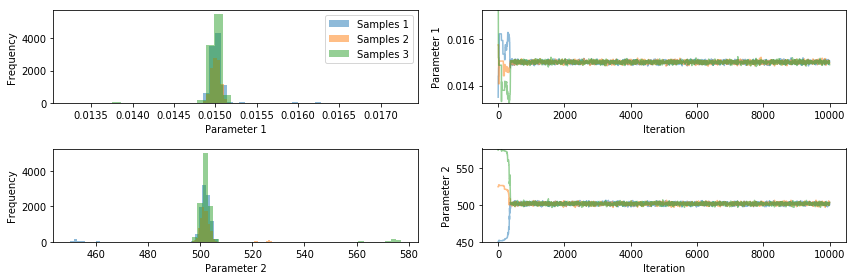

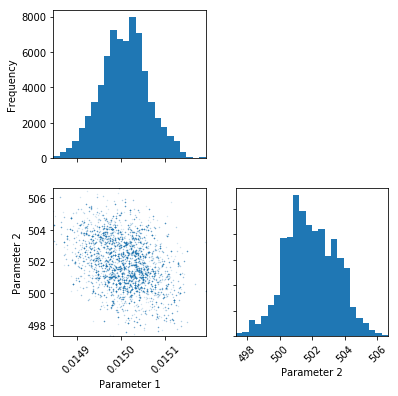

In [27]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

R-hat:
[2.390585775619825, 4.471331584013454]


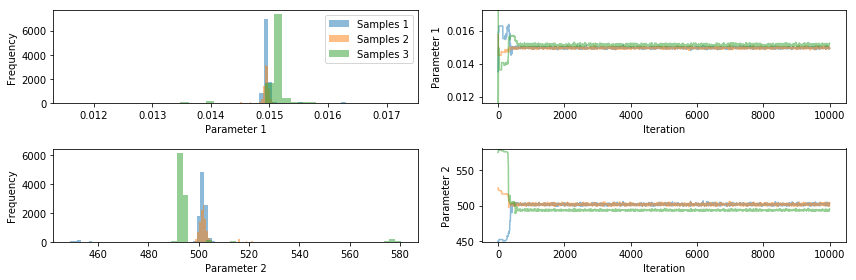

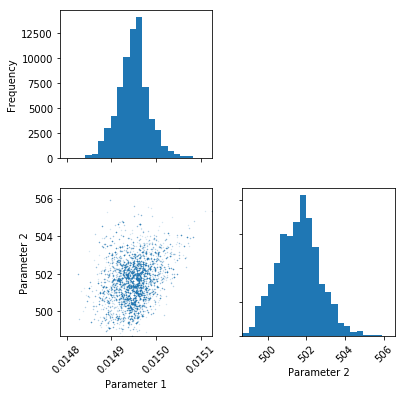

In [28]:
# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

In [29]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

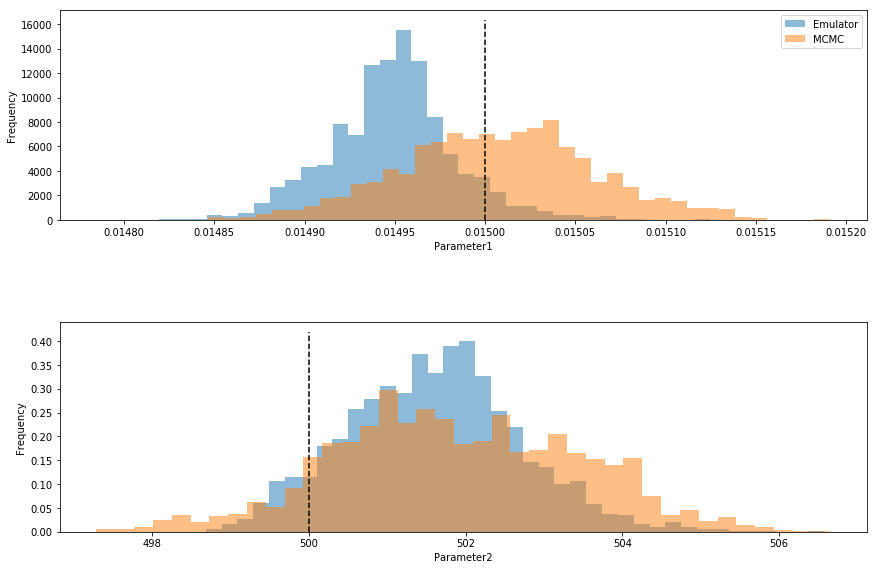

In [30]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

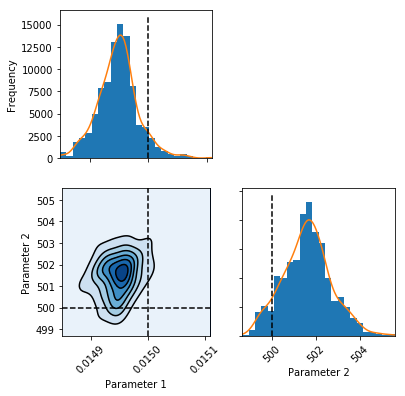

In [31]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

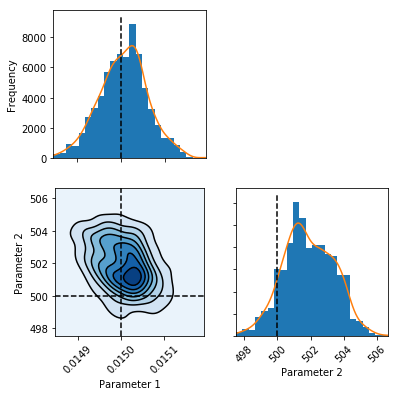

In [32]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

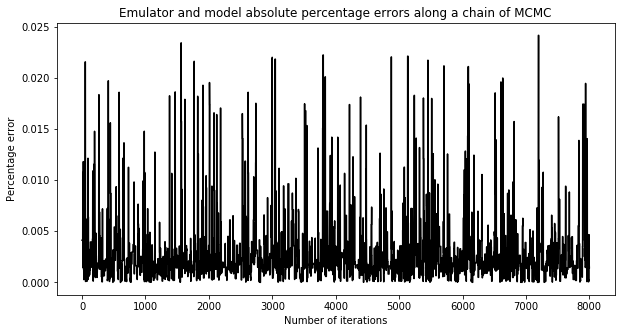

0.0028399896358548052

In [33]:
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

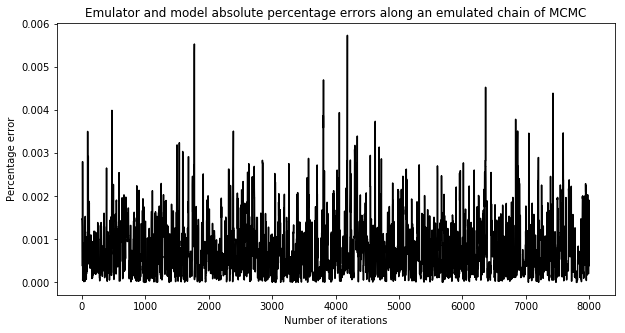

0.000753664506447063

In [34]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

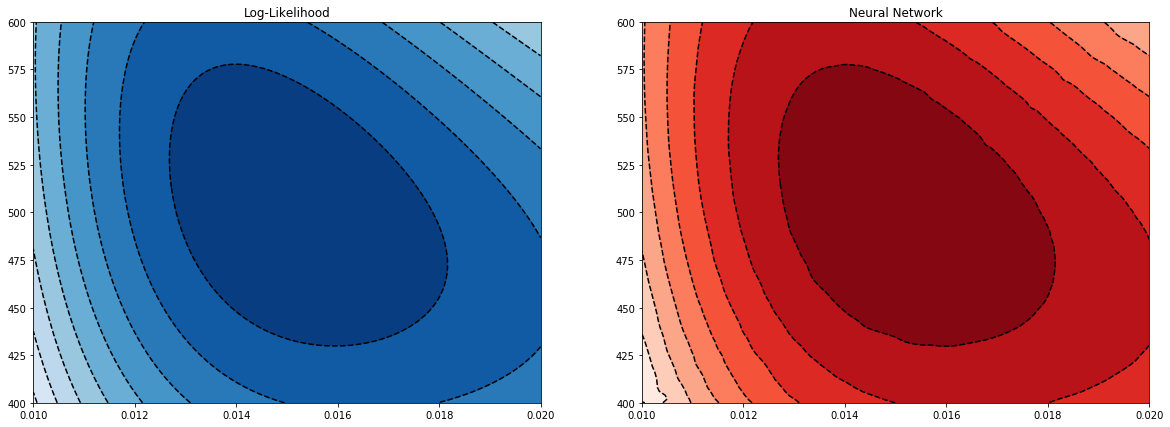

In [35]:
# Create grid of parameters
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

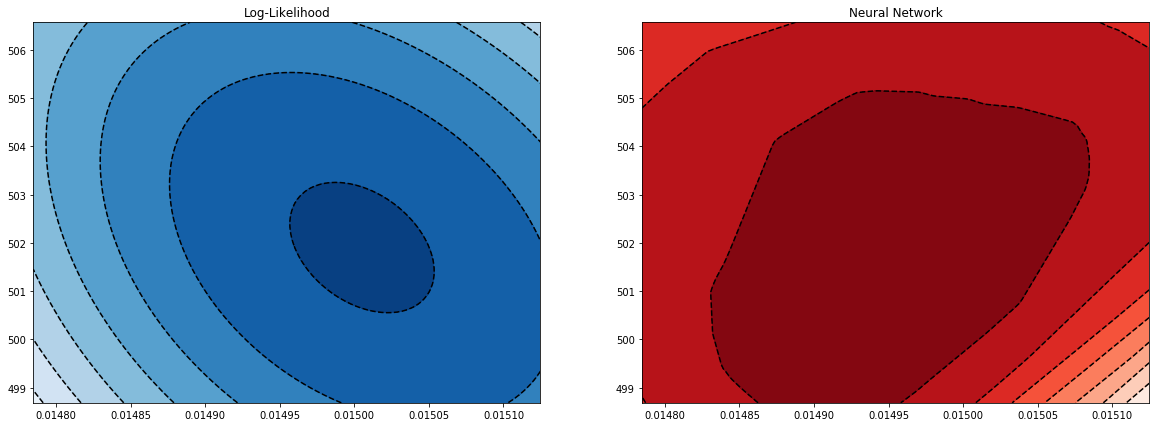

In [36]:
# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

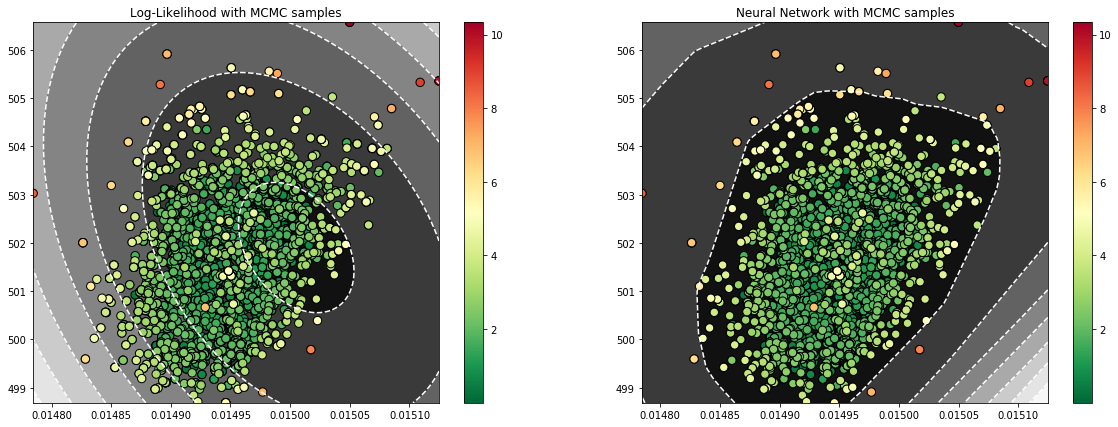

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

fig.savefig("figures/nn-test-contours-old-1000-20.png", bbox_inches='tight', dpi=600)

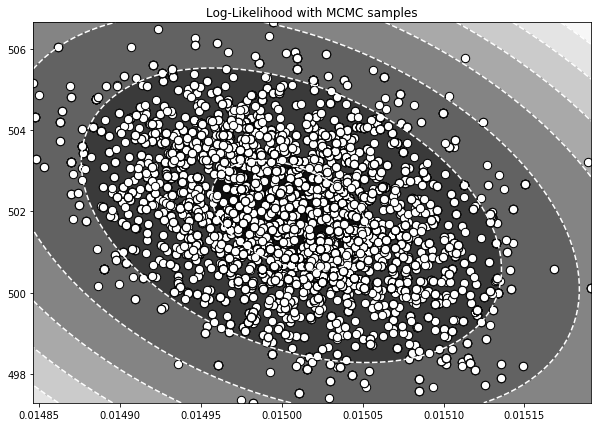

In [38]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')                                                                   

# Plot chain
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', color='w')
plt.show()